EVALUATION SAMPLE
- SingleTurnSample: a single-turn interaction between a user, LLM and expected results for evaluation. question-answer pair
- MultiTurnSample: multi-turn interaction between Human, AI  and optionally a Tool, and expected results for evaluation

EVALUATION DATASET
- data samples designed to assess the performance and capabilities of an AI application: EvaluationDataset class
    - samples: a collection of SingleTurnSample or MultiTurnSample instances. Each sample represents a unique interaction or scenario. All samples within the dataset should be of the same type

1 - evaluate results
2 - evaluate sql policy conformance (no INSERT/UPDATE/DELETE, tables in allowed tables (and candidate tables), joins, ...)
3 - evaluate behavioral compliance (the bot declines or asks for clarification when it should, answer in the user language)
4 - evaluate candidate tables quality (does it select the right tables)

In [1]:
import re
import asyncio
import os, json, hashlib, datetime
import ast
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import LLMSQLEquivalence
from ragas.llms import LangchainLLMWrapper # Wrapper to use our llm for eval
from typing import Any, Iterable
import pandas as pd
from ragas.metrics import Faithfulness, AnswerRelevancy
from ragas import evaluate
import bert_score
from bert_score import score
from itertools import product
import uuid
import nest_asyncio

In [2]:
nest_asyncio.apply()

In [3]:
load_dotenv()
azure_openai_api_key = os.getenv("AZURE_OPENAI_KEY")
azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
# fabric_sql_endpoint = os.getenv("FABRIC_SQL_ENDPOINT")
# fabric_database = os.getenv("FABRIC_DATABASE")

/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/torch/cuda/__init__.py:1034: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
2025-11-25 11:20:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:20:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.

✅ Added /home/jupyter-mmartins/.conda/envs/aivents-clean-env/bin to PATH
📍 neato found at: /home/jupyter-mmartins/.conda/envs/aivents-clean-env/bin/neato


/tmp/ipykernel_1850085/2630130853.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


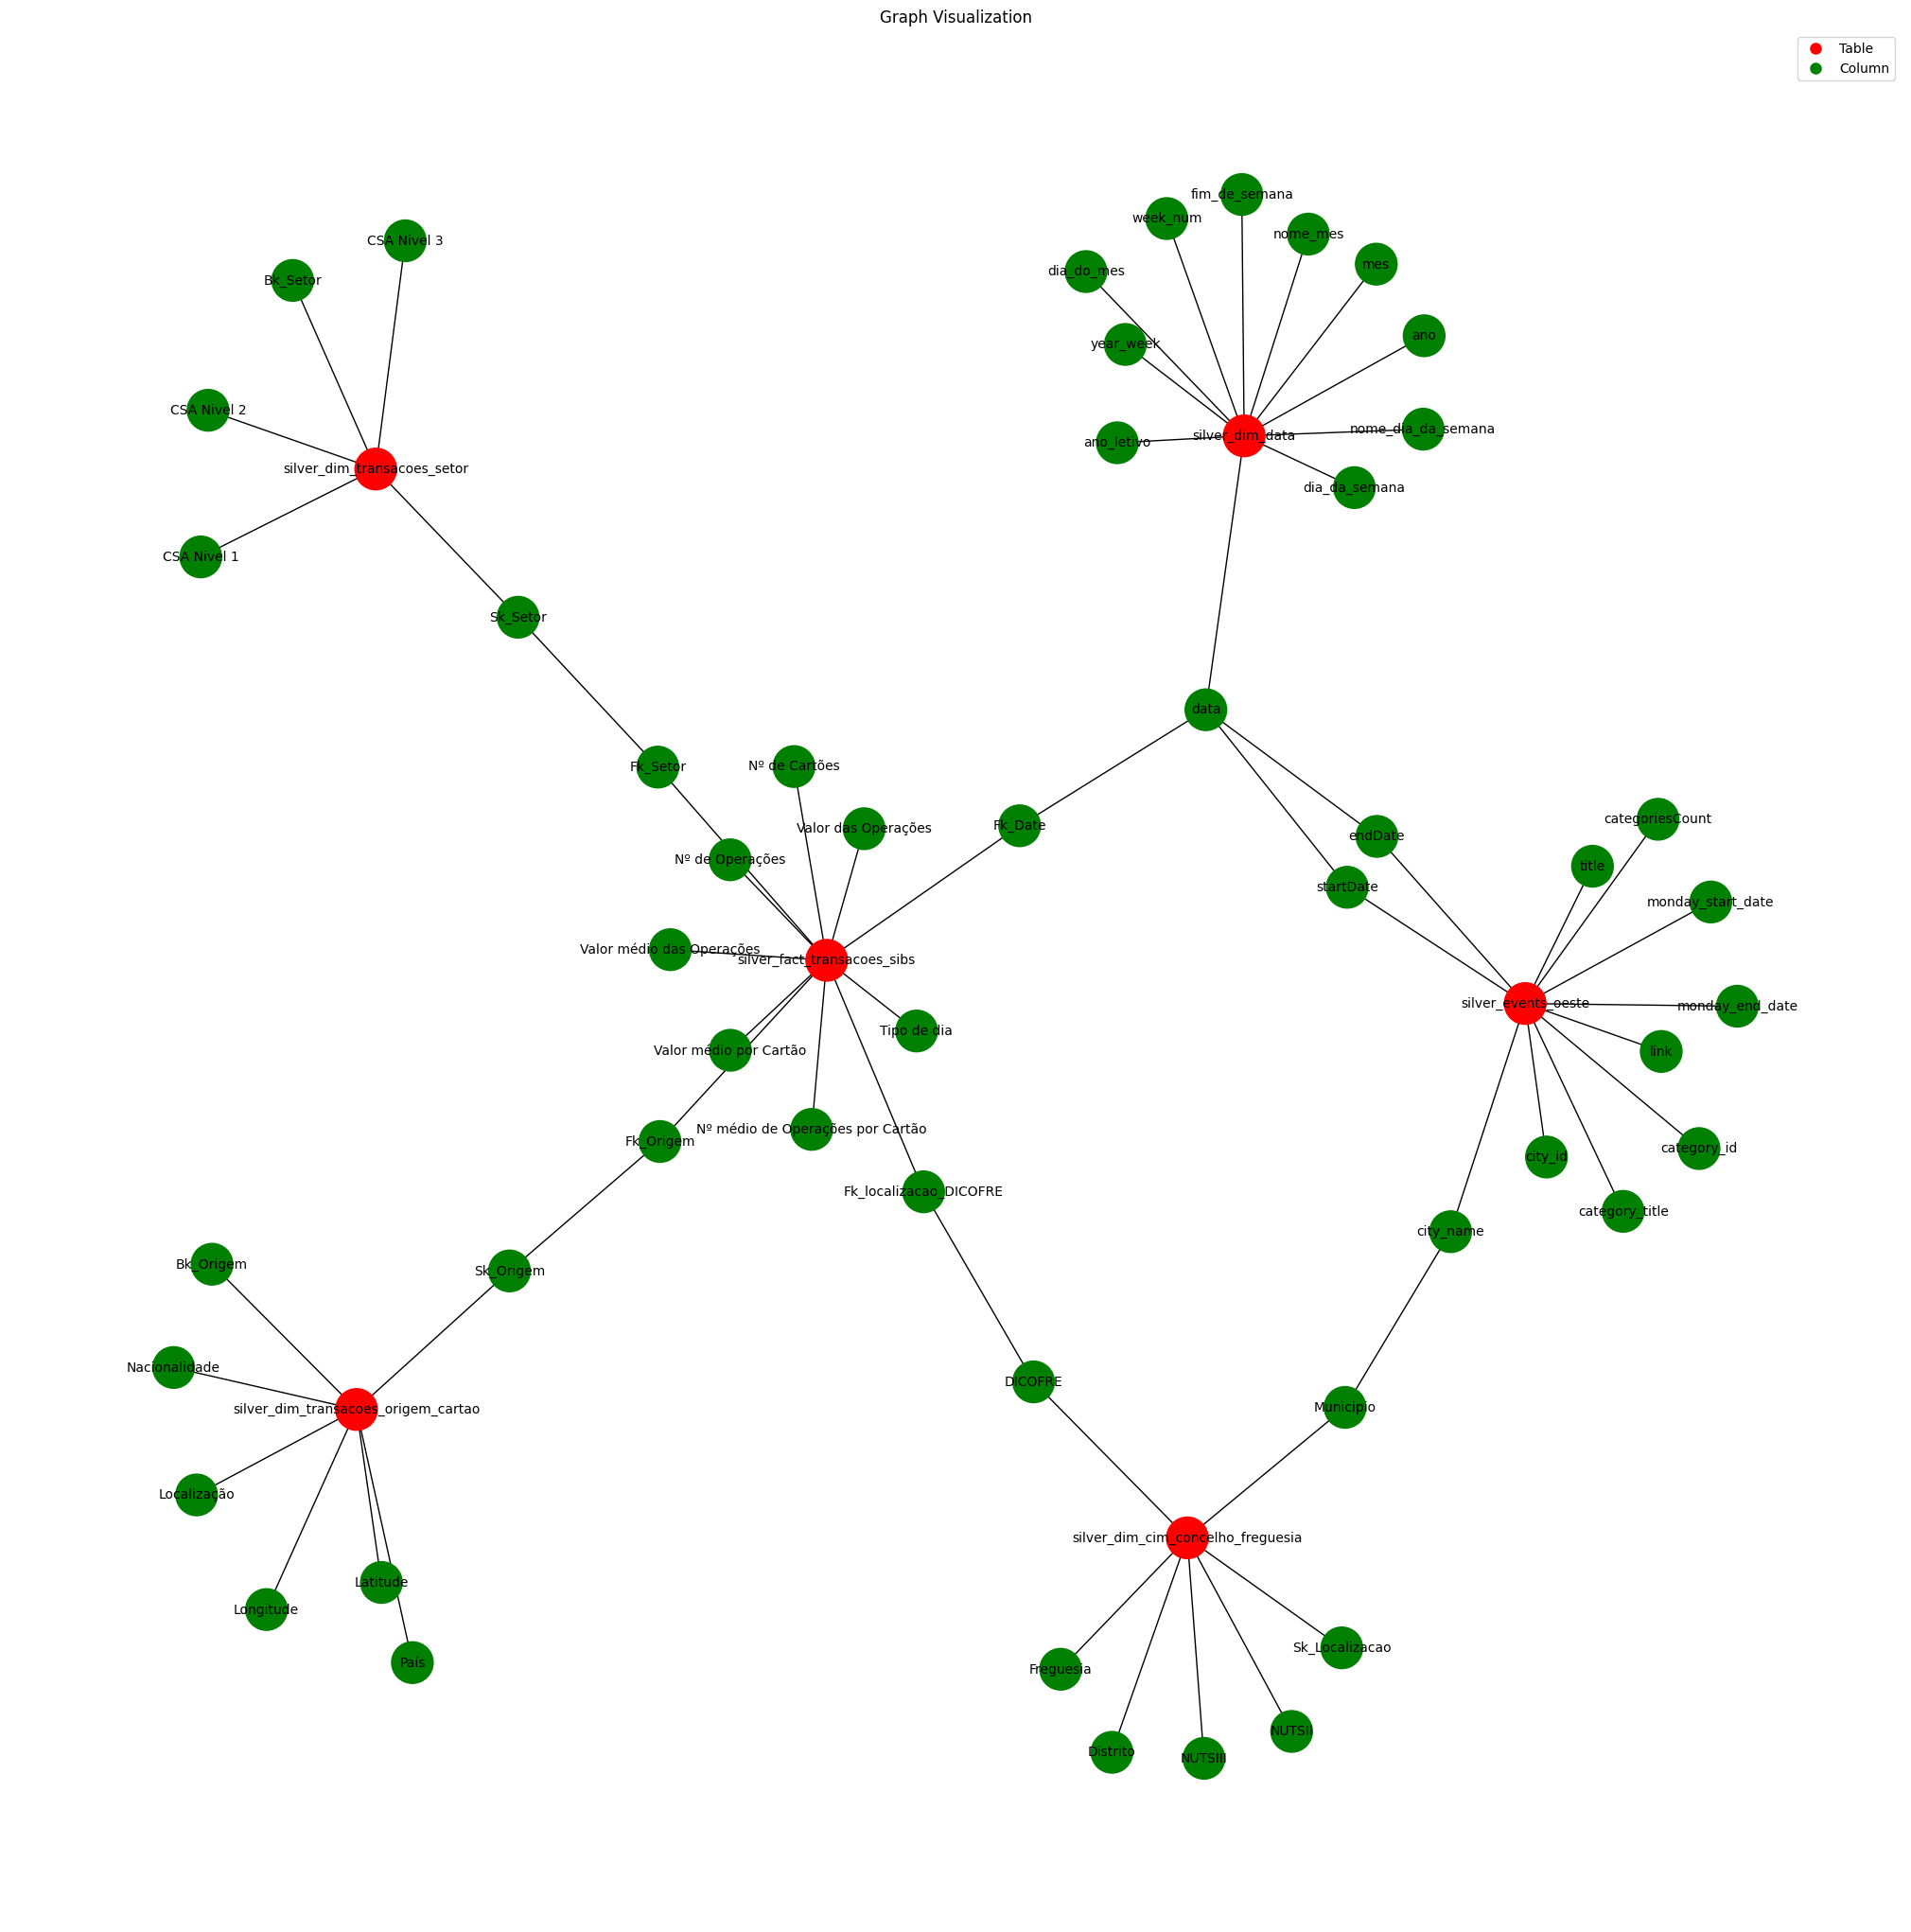

2025-11-25 11:20:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:20:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:20:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4e068a5d-c73d-4086-be7f-5983d1491c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

In [4]:
# IMPORT CHATBOT AND RUN IT
%run chatbot.ipynb

### Configuration

In [5]:
# Role-specific candidate lists
ROLE_MODEL_CANDIDATES = {
    "inference": ["gpt-4o", "gpt-4.1", "gpt-4o-2"],  
    "planner": ["gpt-4o", "gpt-4.1", "gpt-4o-2"],
    "supervisor": ["gpt-4o", "gpt-4.1", "gpt-4o-2"],
    "classifier": ["gpt-4o", "gpt-4.1", "gpt-4o-2"],
}

TEMP_VALUES = [0.0, 0.5, 1.0] 

# DEFAULT_MAX_TOKENS = 512

# This global will be set before each run
CURRENT_ROLE_DEPLOY = {
    "planner":    ROLE_MODEL_CANDIDATES["planner"][0],
    "inference":  ROLE_MODEL_CANDIDATES["inference"][0],
    "supervisor": ROLE_MODEL_CANDIDATES["supervisor"][0],
    "classifier": ROLE_MODEL_CANDIDATES["classifier"][0],
}

DEFAULT_TEMP = 0.0

### Evaluation Data

In [6]:
# EVALUATION DATA

questions = [
    "Quantas transações foram feitas em Óbidos?",
    # "How many transactions were made in Torres Vedras?",
    # "Quantas transações foram feitas em maio de 2022?",
    # "Quantas transações foram feitas no concelho de Peniche, em maio de 2022?",
    # "How many alojamentos are there in Bombarral?",
    "How many transactions were made in the municipality of Peniche in August 2024?",
    "Quantos cartões de crédito foram utilizados nas Caldas da Rainha?",
    "Em maio de 2022, quantas transações ocorreram em fins de semana versus em dias de semana?",
    "What are the top 5 municipalities by number of transactions made in 2023?",
    "Which had more transactions in May 2022: Óbidos or Torres Vedras?",
    "Qual o valor médio das transações efetuadas por mês no ano de 2023?",
    "Que eventos terminaram entre 2024-05-01 e 2024-05-31 no concelho de Torres Vedras?",
    "Quantos eventos ocorreram, por categoria, no concelho de Alcobaça?",
    "Compare the number of cards used during the “Experiência do Oeste em Aula Aberta” and the previous week.",
    "Quantas transações foram feitas em eventos culturais?",
    "Durante o evento Aljubarrota Medieval, quais foram os 3 principais países de origem de cartões de transações realizadas, tendo em conta o número de operações?",
    "For all happenings in 2024, list the top 5 events by average amount per operation during their event windows."
]

# ground_sql_queries = [
#     """SELECT COALESCE(SUM(F.[Nº de Operações]), 0) AS total_transactions 
# FROM silver_fact_transacoes_sibs AS F 
# JOIN silver_dim_cim_concelho_freguesia AS G 
# ON F.Fk_localizacao_DICOFRE = G.DICOFRE 
# WHERE UPPER(G.Municipio) COLLATE Latin1_General_CI_AI = UPPER(N'Óbidos');""",
    # """SELECT SUM(n_operacoes)
    #     FROM silver_fact_transacoes_sibs_oeste
    #     WHERE UPPER(fk_concelho) COLLATE Latin1_General_CI_AI = UPPER(N'Torres Vedras');""",
    # """SELECT SUM(n_operacoes)
    #     FROM silver_fact_transacoes_sibs_oeste
    #     WHERE fk_data BETWEEN '2022-05-01' AND '2022-05-31';""",
    # """SELECT SUM(n_operacoes)
    #     FROM silver_fact_transacoes_sibs_oeste
    #     WHERE UPPER(fk_concelho) COLLATE Latin1_General_CI_AI = UPPER(N'Peniche') AND fk_data BETWEEN '2022-05-01' AND '2022-05-31';""",
    # """
# ]

ground_truths = [
    3880750,
#     59650756,
#     62961113,
#     5094774,
#     None
    789716,
    46642636,
    [("Fim de semana", 1227964), ("Dia de Semana", 3130319)],
    [("Torres Vedras", 18582863), ("Caldas da Rainha", 13657499), ("Alcobaça", 7983117), ("Alenquer", 6982540), ("Peniche", 5987202)],
    [("Óbidos", 58877),	("Torres Vedras", 1255295)],
    [("Janeiro", 49.51), ("Fevereiro", 48.19), ("Março", 48.03), ("Abril", 47.74), ("Maio", 48.27), ("Junho", 47.82), ("Julho", 50.24), ("Agosto", 49.44), ("Setembro", 49.37), ("Outubro", 48.88), ("Novembro", 49.03), ("Dezembro", 51.60)],
    None,
    [("Desporto", 31), ("Geral", 88), ("Património", 22), ("Ambiente", 27), ("Feiras", 2), ("Cultura", 105), ("", 21)],
    [("previous_week", 14312), ("event_week", 14715)],
    11566328545,
    [("Portugal", 268670), ("France", 9298), ("Spain", 2374)],
    [("Experiência do Oeste em Aula Aberta", 59.75), ("Eco-Percurso | Caminhada da Maçã de Alcobaça", 54.40), ("Oficina - Pratos da Guerra, Pratos de Paz", 52.34), ("BMA :: Música para Bebés", 52.34), ("BMA :: Oficina “Tu e Eu e Todos”, por Ana Moreira", 50.92)]
]

expected_responses = [
    "Foram feitas 3,880,750 transações em Óbidos.",
    # "The total number of transactions made in Torres Vedras is 59650756.",
    # "Em maio de 2022, foram feitas um total de 62961113 transações.",
    # "Em maio de 2022, foram feitas um total de 5094774 transações no concelho de Peniche.",
    # "The dataset does not contain the necessary data to answer that question."
    "789,716 transactions were made in the municipality of Peniche in August 2024.",
    "Foram utilizados 46,642,636 cartões de crédito nas Caldas da Rainha.",
    "Em maio de 2022 foram feitas 1,227,964 transações em fins de semana e 3,130,319 em dias de semana.",
    "These are the top 5 municipalities by number of transactions made in 2023: Torres Vedras: 18,582,863; Caldas da Rainha: 13,657,499; Alcobaça: 7,983,117; Alenquer: 6,982,540; Peniche: 5,987,202",
    "In May 2022, Torres Vedras (1,255,295) had more transactions than Óbidos (58,877).",
    "Estes são os valores médios das transações efetuadas por mês no ano de 2023: Janeiro: 49.51€; Fevereiro: 48.19€; Março: 48.03€; Abril: 47.74€; Maio: 48.27€; Junho: 47.82€; Julho: 50.24€; Agosto: 49.44€; Setembro: 49.37€; Outubro: 48.88€; Novembro: 49.03€; Dezembro: 51.60€",
    "Não há registo de eventos que tenham terminado entre 2024-05-01 e 2024-05-31 no concelho de Torres Vedras.",
    "O número de eventos que ocorreram por categoria, no concelho de Alcobaça foi: Desporto: 31; Geral: 88; Património: 22; Ambiente: 27; Feiras: 2; Cultura: 105; Sem categoria: 21.",
    "During the week of the “Experiência do Oeste em Aula Aberta”, there were used 14,715 cards in the municipality of Óbidos, which represents an increase of 403 cards compared to the previous week, where 14,312 cards were used. This corresponds roughly to a 2.8% growth in card usage during the event period.",
    "Foram feitas 11,566,328,545 transações em semanas de eventos culturais.",
    "Durante o evento “Aljubarrota Medieval”, os 3 principais países de origem dos cartões utilizados em transações foram Portugal, com 268,670 transações, França, com 9,298, e Espanha, com 2,374 transações. Atenção que os dados das transações realizadas são relativos à semana e ao município do evento.",
    "In 2024, these were the top 5 events by average amount spent per operation during their event windows: Experiência do Oeste em Aula Aberta: 59.75€; Eco-Percurso | Caminhada da Maçã de Alcobaça: 54.40€; Oficina - Pratos da Guerra, Pratos de Paz: 52.34€; BMA :: Música para Bebés: 52.34€; BMA :: Oficina “Tu e Eu e Todos”, por Ana Moreira: 50.92€"
]

contexts = [
    """
    Table silver_fact_transacoes_sibs:
    - Fk_Date: DATE
    - Tipo de dia: VARCHAR
    - Nº de Cartões: INT
    - Nº de Operações: INT
    - Valor das Operações: INT
    - Nº médio de Operações por Cartão: DECIMAL
    - Valor médio por Cartão: DECIMAL
    - Valor médio das Operações: DECIMAL
    - Fk_localizacao_DICOFRE: VARCHAR
    - FK_Setor: INT
    - FK_Origem: INT
    """,
    """
    Table silver_dim_cim_concelho_freguesia:
    - DICOFRE: VARCHAR
    - Freguesia: VARCHAR
    - Municipio: VARCHAR
    - Distrito: VARCHAR
    - NUTSIII: VARCHAR
    - NUTSII: VARCHAR
    """,
    """
    Table silver_dim_transacoes_origem_cartao:
    - Sk_Origem: INT
    - Localização: VARCHAR    
    - País: VARCHAR
    - Latitude: FLOAT
    - Longitude: FLOAT
    - Nacionalidade: VARCHAR
    """,
    """
    Table silver_dim_transacoes_setor:
    - Sk_Setor: INT
    - CSA Nível 3: VARCHAR
    - CSA Nível 2: VARCHAR
    - CSA Nível 1: VARCHAR
    """,
    """
    Table silver_events_oeste:
    - title: VARCHAR
    - startDate: DATE
    - endDate: DATE
    - categoriesCount: INT
    - link: VARCHAR
    - city_name: VARCHAR
    - category_title: VARCHAR
    - monday_start_date: DATE
    - monday_end_date: DATE
    """,
    """
    Table silver_dim_data:
    - dim_de_semana: VARCHAR
    - dia_do_mes: INT
    - week_num: INT
    - year_week: VARCHAR
    - ano_letivo: VARCHAR
    - data: DATE
    - ano: INT
    - mes: INT
    - nome_mes: VARCHAR
    - dia_da_semana: INT
    - nome_dia_da_semana: VARCHAR
    """
]


# "('CALDAS DA RAINHA', 41622711), ('CADAVAL', 2873306), ('NAZARÉ', 13053292), ('ALENQUER', 23561801), ('SOBRAL DE MONTE AGRAÇO', 4534582), 
# ('ARRUDA DOS VINHOS', 10097988), ('TORRES VEDRAS', 59650756), ('LOURINHÃ', 14081421), ('ALCOBAÇA', 28074741), ('PENICHE', 18819696), 
# ('ÓBIDOS', 4495373), ('BOMBARRAL', 8919453)"

### Utility Functions

In [7]:
def detect_temperature_compatibility():
    """Test which temperatures work with each deployment from ROLE_MODEL_CANDIDATES"""
    # Get all unique deployments
    all_deployments = set()
    for role, deployments in ROLE_MODEL_CANDIDATES.items():
        all_deployments.update(deployments)
    
    deployments = list(all_deployments)
    test_temperatures = [0.0, 0.5, 1.0]
    
    compatibility = {}
    
    for deployment in deployments:
        compatibility[deployment] = []
        for temp in test_temperatures:
            try:
                test_llm = AzureChatOpenAI(
                    azure_deployment=deployment,
                    azure_endpoint=azure_openai_endpoint,
                    api_key=azure_openai_api_key,
                    api_version="2024-12-01-preview",
                    temperature=temp,
                )
                response = test_llm.invoke([("human", "Say hello")])
                compatibility[deployment].append(temp)
                print(f"✅ {deployment} supports temperature={temp}")
            except Exception as e:
                if "temperature" in str(e) and "unsupported" in str(e).lower():
                    print(f"❌ {deployment} doesn't support temperature={temp}")
                else:
                    # Other error - might be temporary, but assume incompatible
                    print(f"⚠️  {deployment} error with temperature={temp}: {e}")
    
    print(f"\n🎯 Temperature compatibility summary:")
    for dep, temps in compatibility.items():
        if temps:
            print(f"  {dep}: supports {temps}")
        else:
            print(f"  {dep}: only supports default temperature")
    
    return compatibility

In [8]:
# Group deployments by their temperature compatibility
def categorize_deployments(compatibility):
    flexible_deployments = []
    default_only_deployments = []
    
    for deployment, supported_temps in compatibility.items():
        if len(supported_temps) > 1:  # Supports multiple temperatures
            flexible_deployments.append(deployment)
        else:
            default_only_deployments.append(deployment)
    
    return flexible_deployments, default_only_deployments

In [9]:
def combo_hash(meta: dict) -> str:
    """Create a hash for model combinations"""
    return hashlib.sha1(json.dumps(meta, sort_keys=True).encode()).hexdigest()[:8]

In [10]:
def load_existing_questions(excel_path: str) -> set:
    """Load already evaluated questions from existing Excel file"""
    if os.path.exists(excel_path):
        df = pd.read_excel(excel_path)
        return set(df['question'].dropna().unique())
    return set()

def filter_evaluated_questions(questions, ground_truths, expected_responses, existing_questions: set):
    """Filter out questions that have already been evaluated"""
    new_questions = []
    #new_sql_queries = []
    new_truths = []
    new_responses = []
    
    # # Use zip to iterate through all lists simultaneously
    # for question, truth, response in zip(questions, ground_truths, expected_responses):
    #     if question not in existing_questions:
    #         new_questions.append(question)
    #         new_truths.append(truth)
    #         new_responses.append(response)

    for i, question in enumerate(questions):
        if question not in existing_questions:
            new_questions.append(question)
            #new_sql_queries.append(ground_sql_queries[i])
            new_truths.append(ground_truths[i])
            new_responses.append(expected_responses[i])
    
    print(f"Filtered: {len(questions) - len(new_questions)} already evaluated, {len(new_questions)} new to evaluate")
    return new_questions, new_truths, new_responses

In [11]:
# Parse the last_answer field into a usable format
def parse_last_answer(last_answer):
    """
    - If last_answer looks like [(4495373,)] -> 4495373 (int)
    - If last_answer looks like [('A', 1), ('B', 2)] -> "('A', 1), ('B', 2)" (str)
    - Otherwise: tries to return a sensible scalar or a cleaned string.
    """
    if last_answer is None:
        return None

    s = last_answer if isinstance(last_answer, str) else repr(last_answer)
    s = s.strip()

    # Try safe Python parsing first
    try:
        obj = ast.literal_eval(s)
    except Exception:
        obj = None

    if obj is not None:
        # Sequence cases
        if isinstance(obj, (list, tuple)):
            if len(obj) == 1:
                first = obj[0]
                # Case: [(4495373,)] or [(4495373, 'extra')] -> prefer first value if numeric-only 1-tuple
                if isinstance(first, (list, tuple)):
                    if len(first) == 1 and isinstance(first[0], (int, float)):
                        return first[0]
                    # If it's a single 2-tuple, fall through to generic join below

            # Case: list of 2-tuples (e.g., [('NAME', 123), ...]) -> return without outer brackets
            # if all(isinstance(x, (list, tuple)) and len(x) == 2 for x in obj):
            #     return ", ".join(f"({repr(x[0])}, {x[1]})" for x in obj)      #-> this returns a string
            if all(isinstance(x, (list, tuple)) and len(x) == 2 for x in obj):
                return obj  # ← Return the actual list/tuple object!

            # Case: list of 1-tuples (e.g., [(123,), (456,)]) -> return comma-joined numbers/values
            if all(isinstance(x, (list, tuple)) and len(x) == 1 for x in obj):
                vals = [x[0] for x in obj]
                # if single numeric, return numeric; else join as string
                if len(vals) == 1 and isinstance(vals[0], (int, float)):
                    return vals[0]
                return ", ".join(repr(v) for v in vals)

            # Fallback: join items as string
            return ", ".join(repr(x) for x in obj)

        # Scalar numeric
        if isinstance(obj, (int, float)):
            return obj

        # Anything else (dict, str, ...) -> string
        return str(obj)

    # If we couldn't parse, try regex fallbacks:

    # 1) Strip outer brackets from a list of tuples: "[ (..), (..) ]" -> "(..), (..)"
    m_list = re.search(r"^\s*\[\s*(\(.*\))\s*\]\s*$", s, flags=re.S)
    if m_list:
        return m_list.group(1)

    # 2) First number fallback (handles "4,495,373" etc.)
    m_num = re.search(r"[-+]?\d[\d.,]*", s)
    if m_num:
        num_txt = m_num.group(0)
        # remove thousand separators
        num_norm = re.sub(r"[,\s]", "", num_txt)
        try:
            return int(num_norm)
        except ValueError:
            # try float if it has decimals
            num_norm = num_norm.replace(".", "").replace(",", ".")
            try:
                return float(num_norm)
            except ValueError:
                pass

    # Last resort: return original string
    return s

In [12]:
def is_number(x: Any) -> bool:
    return isinstance(x, (int, float))

def canon_rows(x: Any) -> Any:
    """
    Canonicalize nested list/tuple structures to enable unordered comparison.
    - Convert lists/tuples to tuples
    - Recursively canonicalize children
    """
    if isinstance(x, (list, tuple)):
        return tuple(canon_rows(y) for y in x)
    return x

# def score_equal(pred: Any, truth: Any, *, unordered: bool = False, float_tol: float = 0.0) -> int:
#     """
#     Returns 1 if equal per chosen policy, else 0.
#     - unordered=True ignores row order for list/tuple results.
#     - float_tol allows a small tolerance for floats.
#     """

#     # Handle None cases
#     if pred is None and truth is None:
#         return 1
#     if pred is None or truth is None:
#         return 0
    
#     # numeric with tolerance
#     if is_number(pred) and is_number(truth):
#         return 1 if abs(float(pred) - float(truth)) <= float_tol else 0

#     if unordered and isinstance(pred, (list, tuple)) and isinstance(truth, (list, tuple)):
#         p = canon_rows(pred)
#         t = canon_rows(truth)
#         # sort if possible (works well for tuples of simple types)
#         try:
#             return 1 if sorted(p) == sorted(t) else 0
#         except Exception:
#             # fallback: strict equality if not sortable
#             return 1 if p == t else 0

#     # default: strict equality
#     return 1 if pred == truth else 0

def extract_categorical_numerical_pairs(data):
    """
    Extract (categorical, numerical) pairs from various data structures
    Handles: [("cat", 123)], [(123, "cat")], [(["cat1", "cat2"], 123)], etc.
    """
    pairs = []
    
    if not isinstance(data, (list, tuple)):
        return pairs
    
    for item in data:
        if isinstance(item, (list, tuple)) and len(item) >= 2:
            # Handle different orderings: (categorical, numerical) or (numerical, categorical)
            item1, item2 = item[0], item[1]
            
            # Case 1: (categorical, numerical)
            if isinstance(item1, str) and isinstance(item2, (int, float)):
                pairs.append((item1.lower(), item2))
            # Case 2: (numerical, categorical)  
            elif isinstance(item2, str) and isinstance(item1, (int, float)):
                pairs.append((item2.lower(), item1))
            # Case 3: Both could be categorical or numerical, try to identify
            else:
                # If one is string and other is numeric, use that
                if isinstance(item1, str) and isinstance(item2, (int, float)):
                    pairs.append((item1.lower(), item2))
                elif isinstance(item2, str) and isinstance(item1, (int, float)):
                    pairs.append((item2.lower(), item1))
                # Fallback: treat as (string_repr, value)
                else:
                    str_repr = str(item1).lower()
                    pairs.append((str_repr, item2))
        
        elif isinstance(item, (list, tuple)) and len(item) == 1:
            # Single item tuple/list - might be just a number or string
            if isinstance(item[0], (int, float)):
                pairs.append(("single_value", item[0]))
            else:
                pairs.append((str(item[0]).lower(), None))
    
    return pairs

def categorical_numerical_match(pred, truth, float_tol=0.0):
    """
    Check if all categorical parts from ground_truth are present in predicted
    and their corresponding numerical values match
    """
    try:
        # Extract pairs from both prediction and ground truth
        pred_pairs = extract_categorical_numerical_pairs(pred)
        truth_pairs = extract_categorical_numerical_pairs(truth)
        
        if not truth_pairs:
            return 0
        
        # Create dictionaries for easy lookup
        pred_dict = dict(pred_pairs)
        truth_dict = dict(truth_pairs)
        
        # Check if all categorical keys from ground truth are in prediction
        truth_categories = set(truth_dict.keys())
        pred_categories = set(pred_dict.keys())
        
        if truth_categories != pred_categories:
            return 0
        
        # Check if all numerical values match (with tolerance)
        for category, truth_value in truth_dict.items():
            if category not in pred_dict:
                return 0
            
            pred_value = pred_dict[category]
            
            # Handle None values
            if truth_value is None and pred_value is None:
                continue
            if truth_value is None or pred_value is None:
                return 0
            
            # Numerical comparison with tolerance
            if isinstance(truth_value, (int, float)) and isinstance(pred_value, (int, float)):
                if abs(float(truth_value) - float(pred_value)) > float_tol:
                    return 0
            else:
                # Non-numeric comparison
                if truth_value != pred_value:
                    return 0
        
        return 1
        
    except Exception as e:
        # If anything goes wrong in the fallback matching, return 0
        print(f"Fallback matching error: {e}")
        return 0

def score_equal(pred: Any, truth: Any, *, unordered: bool = False, float_tol: float = 0.0, question: str = "") -> int:
    """
    Enhanced equality scoring with fallback to categorical-numerical matching
    """
    # Handle None cases
    if pred is None and truth is None:
        return 1
    if pred is None or truth is None:
        return 0
    
    # Numeric comparison with tolerance
    if isinstance(pred, (int, float)) and isinstance(truth, (int, float)):
        return 1 if abs(float(pred) - float(truth)) <= float_tol else 0
    
    # Handle list/tuple structures
    if isinstance(pred, (list, tuple)) and isinstance(truth, (list, tuple)):
        # First try the original comparison
        try:
            if unordered:
                p = canon_rows(pred)
                t = canon_rows(truth)
                try:
                    if sorted(p) == sorted(t):
                        return 1
                except Exception:
                    if p == t:
                        return 1
            else:
                if canon_rows(pred) == canon_rows(truth):
                    return 1
        except Exception:
            pass
        
        # If original comparison failed and ground_truth has tuples, try categorical-numerical matching
        if truth and any(isinstance(item, (list, tuple)) for item in truth):
            return categorical_numerical_match(pred, truth, float_tol)
    
    # Default: strict equality for other types
    return 1 if pred == truth else 0

In [13]:
# pred_ = "(1227964, Fim de semana), (3130319, Dia de Semana)"
# truth_ = [('Fim de semana', 1227964), ('Dia de Semana', 3130319)]

# score_equal(pred=pred_, truth=truth_)

### Model Setup

In [14]:
# Run the compatibility test
temp_compatibility = detect_temperature_compatibility()

flexible_deployments, default_only_deployments = categorize_deployments(temp_compatibility)

print(f"Flexible deployments (multiple temps): {flexible_deployments}")
print(f"Default-only deployments: {default_only_deployments}")

✅ gpt-4o-2 supports temperature=0.0
✅ gpt-4o-2 supports temperature=0.5
✅ gpt-4o-2 supports temperature=1.0
✅ gpt-4o supports temperature=0.0
✅ gpt-4o supports temperature=0.5
✅ gpt-4o supports temperature=1.0
✅ gpt-4.1 supports temperature=0.0
✅ gpt-4.1 supports temperature=0.5
✅ gpt-4.1 supports temperature=1.0

🎯 Temperature compatibility summary:
  gpt-4o-2: supports [0.0, 0.5, 1.0]
  gpt-4o: supports [0.0, 0.5, 1.0]
  gpt-4.1: supports [0.0, 0.5, 1.0]
Flexible deployments (multiple temps): ['gpt-4o-2', 'gpt-4o', 'gpt-4.1']
Default-only deployments: []


In [15]:
# 1) Keep a handle to the original class
OriginalConfig = Config

# 2) Define a patched Config that only overrides the LLM
class PatchedConfig(OriginalConfig):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        def make_llm(deployment: str, desired_temperature: float):
            # Check what temperatures this deployment actually supports
            supported_temps = temp_compatibility.get(deployment, [])
            
            # If deployment doesn't support the desired temperature, use what it does support
            if supported_temps and desired_temperature not in supported_temps:
                # Use the first supported temperature (usually most conservative)
                effective_temp = supported_temps[0] if supported_temps else 1.0
                if deployment in default_only_deployments:
                    print(f"📝 {deployment}: Using default temperature (doesn't support {desired_temperature})")
                else:
                    print(f"🔄 {deployment}: Using {effective_temp} instead of {desired_temperature}")
            else:
                effective_temp = desired_temperature
            
            return AzureChatOpenAI(
                azure_deployment=deployment,
                azure_endpoint=self.azure_openai_endpoint,
                api_key=self.azure_openai_api_key,
                api_version="2024-12-01-preview",
                temperature=effective_temp,
                # max_tokens=DEFAULT_MAX_TOKENS,
            )

        # Role-specific LLMs (read from CURRENT_ROLE_DEPLOY)
        self.llm_planner    = make_llm(CURRENT_ROLE_DEPLOY["planner"], DEFAULT_TEMP)
        self.llm_inference  = make_llm(CURRENT_ROLE_DEPLOY["inference"], DEFAULT_TEMP)
        self.llm_supervisor = make_llm(CURRENT_ROLE_DEPLOY["supervisor"], DEFAULT_TEMP)
        self.llm_classifier = make_llm(CURRENT_ROLE_DEPLOY["classifier"], DEFAULT_TEMP)

In [16]:
# Initialize LLM and embeddings for evaluation
llm = AzureChatOpenAI(
            azure_deployment="gpt-4o-2",
            azure_endpoint=azure_openai_endpoint,
            api_version="2024-12-01-preview",
            api_key=azure_openai_api_key,
            temperature=0,
        )

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small",   # <- your deployment name
    api_key=os.environ["AZURE_OPENAI_KEY"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version="2024-02-15-preview",            # embeddings API version (adjust to your workspace)
)

In [17]:
# ---------- Ragas metric objects (reuse across items) ----------
ragas_llm = LangchainLLMWrapper(llm)
sql_metric = LLMSQLEquivalence()
sql_metric.llm = ragas_llm
faith_metric = Faithfulness(llm=ragas_llm)                       # needs retrieved_contexts
relev_metric = AnswerRelevancy(llm=ragas_llm, embeddings=embeddings)

/tmp/ipykernel_1850085/1184246094.py:2: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  ragas_llm = LangchainLLMWrapper(llm)


### Evaluation Function

In [18]:
def evaluate_dataset_sync(items, graph, contexts, print_each=True):
    """
    Synchronous wrapper that runs the async evaluate_dataset function
    """
    return asyncio.run(
        evaluate_dataset_async(items, graph, contexts, print_each)
    )

# ---------- Main evaluation ----------
async def evaluate_dataset_async(
    items: list[dict],
    graph,
    contexts: list[str],
    #excel_path: str = "eval_results.xlsx",
    print_each: bool = True,
):

    rows = []
    uid = str(uuid.uuid4())

    # START WITH EMPTY STATE
    current_state = {
        "user_id": uid,
        "question": "",
        # ... other empty fields
    }

    for idx, item in enumerate(items, start=1):
        q = item["question"]
        #ref_sql = item.get("ground_sql")
        ref_num_answer = item.get("ground_truth")
        ref_txt_answer = item.get("expected_response")

        # 1) Run the chatbot WITH PERSISTENT STATE
        current_state = graph.invoke({
            **current_state,
            "question": q
            })

        pred_sql     = current_state.get("last_sql")
        pred_answer  = parse_last_answer(current_state.get("last_answer"))
        response_txt = current_state.get("response", "")
        db_trace     = current_state.get("db_results", "")

        # # 2) SQL equivalence score (0/1), if both sides exist
        # sql_equiv = None
        # if pred_sql and ref_sql:
        #     sample_sql = SingleTurnSample(
        #         response=pred_sql,
        #         reference=ref_sql,
        #         reference_contexts=contexts
        #     )
        #     try:
        #         sql_equiv = await sql_metric.single_turn_ascore(sample_sql)
        #     except Exception as e:
        #         sql_equiv = None

        # 3) Answer match (exact/structural)
        unordered = isinstance(ref_num_answer, (list, tuple))
        ans_match = score_equal(pred_answer, ref_num_answer, unordered=unordered, float_tol=0.0)

        # 4) BERTScore
        try:
            if detect_lang(q) == 'en':
                P, R, F1 = score([response_txt], [ref_txt_answer], lang='en', verbose=True)
            elif detect_lang(q) == 'pt':
                P, R, F1 = score([response_txt], [ref_txt_answer], lang='pt', verbose=True)
            bert_p, bert_r, bert_f1 = float(P[0]), float(R[0]), float(F1[0])
        except Exception as e:
            bert_p, bert_r, bert_f1 = 0.0, 0.0, 0.0

        # 5) Faithfulness - Use pred_answer as the database evidence
        faith_contexts = []

        # pred_answer IS the actual database result, so use it directly
        if pred_answer is not None:
            # Format it clearly for the faithfulness metric
            if isinstance(pred_answer, (int, float)):
                faith_contexts.append(f"Database result: {pred_answer}")
            elif isinstance(pred_answer, (list, tuple)):
                if len(pred_answer) == 1:
                    faith_contexts.append(f"Database result: {pred_answer[0]}")
                else:
                    faith_contexts.append(f"Database results: {pred_answer}")
            else:
                faith_contexts.append(f"Database result: {pred_answer}")

        # Also include the SQL for context
        if pred_sql:
            faith_contexts.append(f"SQL query: {pred_sql}")

        # Fallback if no database result
        if not faith_contexts:
            faith_contexts = ["No database result available"]

        sample_resp_faith = SingleTurnSample(
            user_input=q,
            response=response_txt,
            retrieved_contexts=faith_contexts
        )

        try:
            faith_score = await faith_metric.single_turn_ascore(sample_resp_faith)
        except Exception as e:
            print(f"❌ Faithfulness error for Q{idx}: {e}")
            faith_score = None

        # 5) Faithfulness & Answer Relevancy
        # #    Provide the DB trace and SQL as "retrieved_contexts"
        # sample_resp_faith = SingleTurnSample(
        #     user_input=q,
        #     response=response_txt,
        #     #retrieved_contexts= [str(pred_answer)]
        #     retrieved_contexts=[db_trace, f"SQL: {pred_sql or ''}"]         
        # )
        # try:
        #     faith_score = await faith_metric.single_turn_ascore(sample_resp_faith)
        # except Exception:
        #     faith_score = None

        # 6) Answer Relevancy
        sample_resp_relev = SingleTurnSample(
            user_input=q,
            response=response_txt,
        )

        try:
            relev_score = await relev_metric.single_turn_ascore(sample_resp_relev)
        except Exception as e:
            relev_score = None

        # 7) Collect row
        rows.append({
            "idx": idx,
            "question": q,
            "pred_sql": pred_sql,
            "pred_answer": pred_answer,
            "response_text": response_txt,
            #"ground_sql": ref_sql,
            "ground_truth": ref_num_answer,
            "expected_response": ref_txt_answer,
            #"sql_equiv": sql_equiv,
            "answer_match": ans_match,
            "BERTScore P": bert_p,
            "BERTScore R": bert_r,
            "BERTScore F1": bert_f1,
            "faithfulness": faith_score,
            "answer_relevancy": relev_score,
        })

        # Pretty print (optional)
        if print_each:
            print(f"{idx}. {q}\n"
                  #f"  sql_equiv: {sql_equiv}\n"
                  f"  answer_match: {ans_match}\n"
                  f"  BERTScore P: {bert_p}\n"
                  f"  BERTScore R: {bert_r}\n"
                  f"  BERTScore F1: {bert_f1}\n"
                  f"  faithfulness: {faith_score}\n"
                  f"  answer_relevancy: {relev_score}\n")

    df = pd.DataFrame(rows)
    return df, rows

### Main Evaluation Loop

In [ ]:
def main():
    """Main evaluation function"""
    # Check for existing results and filter
    existing_questions = load_existing_questions("eval_results.xlsx")
    filtered_questions, filtered_truths, filtered_responses = filter_evaluated_questions(
        questions, ground_truths, expected_responses, existing_questions
    )

    if not filtered_questions:
        print("No new questions to evaluate! Add new questions or delete eval_results.xlsx to re-run everything.")
        return

    # # Only proceed if there are new questions to evaluate
    # if filtered_questions:
    
    # Build eval_items from filtered data
    eval_items = [
        {
            "question": filtered_questions[i],
            #"ground_sql": filtered_sql[i],
            "ground_truth": filtered_truths[i],
            "expected_response": filtered_responses[i]
        }
        for i in range(len(filtered_questions))
    ]

    all_rows = []

    # loop over different temperatures and model combinations
    for desired_temp in TEMP_VALUES:
        DEFAULT_TEMP = desired_temp

        # Iterate every combination: planner × inference × supervisor × classifier
        for dep_pl, dep_inf, dep_sup, dep_cls in product(
            ROLE_MODEL_CANDIDATES["inference"],
            ROLE_MODEL_CANDIDATES["planner"],
            ROLE_MODEL_CANDIDATES["supervisor"],
            ROLE_MODEL_CANDIDATES["classifier"],
        ):
            # 5.1 configure current role→deployment for this run
            CURRENT_ROLE_DEPLOY.update({
                "planner":    dep_pl,
                "inference":  dep_inf,
                "supervisor": dep_sup,
                "classifier": dep_cls,
            })

            print(f"\n🧪 Testing: temp={desired_temp}, models=({dep_pl}, {dep_inf}, {dep_sup}, {dep_cls})")

            # Check actual temperatures being used
            actual_temps = {}
            for role, deployment in CURRENT_ROLE_DEPLOY.items():
                supported = temp_compatibility.get(deployment, [])
                actual_temp = desired_temp if desired_temp in supported else (supported[0] if supported else 1.0)
                actual_temps[role] = actual_temp
            
            if actual_temps != {role: desired_temp for role in CURRENT_ROLE_DEPLOY}:
                print(f"   Actual temperatures: {actual_temps}")

            # 5.2 temporarily patch Config so create_graph() uses our role models
            globals()["Config"] = PatchedConfig

            # 5.3 build graph exactly like main app
            graph = create_graph()

            # Run evaluation
            try:
                # 5.4 run your existing evaluation (don’t write Excel per run)
                df_run, rows_run = evaluate_dataset_sync(
                    eval_items, graph, contexts, print_each=False
                )

                # 5.5 tag each row with model provenance and a stable combo id
                meta = {
                    "planner_llm": dep_pl,
                    "inference_llm": dep_inf,
                    "supervisor_llm": dep_sup,
                    "classifier_llm": dep_cls,
                    "desired_temperature": desired_temp,
                    "planner_temp": actual_temps.get("planner", desired_temp),
                    "inference_temp": actual_temps.get("inference", desired_temp),
                    "supervisor_temp": actual_temps.get("supervisor", desired_temp),
                    "classifier_temp": actual_temps.get("classifier", desired_temp),
                    "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
                }
                meta["combo_id"] = combo_hash(meta)
                #meta["run_timestamp"] = datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z"

                for r in rows_run:
                    r.update(meta)

                all_rows.extend(rows_run)

            except Exception as e:
                print(f"❌ Error in evaluation: {e}")
                continue

    # 5.6 restore original Config to avoid side effects later
    globals()["Config"] = OriginalConfig

    # Save results
    if all_rows:
        # Load existing results if they exist
        if os.path.exists("eval_results.xlsx"):
            existing_df = pd.read_excel("eval_results.xlsx")
            new_df = pd.DataFrame(all_rows)
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            final_df = pd.DataFrame(all_rows)

        # Save to Excel
        with pd.ExcelWriter("eval_results.xlsx", engine="openpyxl") as writer:
            final_df.to_excel(writer, sheet_name="results", index=False)

            # Create metrics_long sheet
            metric_cols = ["answer_match","BERTScore P","BERTScore R","BERTScore F1","faithfulness","answer_relevancy"]
            id_cols = [c for c in final_df.columns if c not in metric_cols]
            df_long = final_df.melt(id_vars=id_cols, value_vars=metric_cols,
                                var_name="metric_name", value_name="metric_value")
            df_long.to_excel(writer, sheet_name="metrics_long", index=False)

        # print(f"Saved eval_results.xlsx with {len(df_all)} rows")
        print(f"✅ Saved eval_results.xlsx with {len(final_df)} total rows ({len(all_rows)} new)")
    else:
        print("❌ No results to save!")

# Run the evaluation
if __name__ == "__main__":
    main()

2025-11-25 11:21:13 - INFO - Environment is configured for ClientSecretCredential


Filtered: 0 already evaluated, 13 new to evaluate

🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4o)


2025-11-25 11:21:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:21:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2a30d37-4ce8-414f-b12a-0c8938c10900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:21:13 GMT'
    'Con

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 11:21:36 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.04 seconds, 22.73 sentences/sec


2025-11-25 11:21:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:21:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:21:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2ddab2a6-914c-46ba-aa65-01a9390b7c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.53 sentences/sec


2025-11-25 11:21:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:21:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:21:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc96dbfa-2081-46e7-95c0-42563c660900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.30 sentences/sec


2025-11-25 11:22:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:22:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:22:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fb7db07a-5999-425e-a622-3e5e20206c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.22 sentences/sec


2025-11-25 11:22:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:22:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:22:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4558c0bb-0b49-4045-836b-510d047e7b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.34 sentences/sec


2025-11-25 11:22:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:22:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:22:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ba4e2b4f-8013-4492-801f-941f775d1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.15 sentences/sec


2025-11-25 11:23:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:23:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:23:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '32c99546-7d70-41c5-a1d7-c4fa0f6e7500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.07 sentences/sec


2025-11-25 11:23:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:23:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:23:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9bf39212-7c95-479d-9a10-afd1260b3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.90 sentences/sec


2025-11-25 11:23:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:23:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:24:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '120636f2-3d6a-482c-908a-304574420a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.26 sentences/sec


2025-11-25 11:24:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:24:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:24:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4c021b85-b289-4908-8c82-8062b1212800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.08 sentences/sec


2025-11-25 11:24:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:24:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:24:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a5f8b492-43a2-423a-a799-d0a48a9a3000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.19 sentences/sec


2025-11-25 11:24:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:24:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:24:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5f33335a-69a3-41e5-a9a3-4647fbb80d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.39 sentences/sec


2025-11-25 11:25:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:25:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:25:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54f4b035-7079-4285-99fd-94fa97734100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.29 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:25:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:25:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4.1)


2025-11-25 11:25:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '973e6fbc-b272-4172-9040-f4c75b5f5700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:25:54 GMT'
    'Content-Length': '1964'
2025-11-25 11:25:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.54 sentences/sec


2025-11-25 11:26:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:26:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:26:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f324950b-2171-4b42-a4e3-d5a8bf692000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.93 sentences/sec


2025-11-25 11:26:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:26:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:26:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f4b2c0ed-caef-486e-b5e3-830bdacd6b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.94 sentences/sec


2025-11-25 11:27:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:27:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:27:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dba13669-fe2b-4b48-8132-a58e6ada1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 11:27:41 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.04 seconds, 22.90 sentences/sec


2025-11-25 11:27:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:27:47 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-401' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-402' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:286: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for level in list(self.possible_simple_keys):
2025-11-25 11:27:47 - ERROR - Task was destroyed b

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.34 sentences/sec


2025-11-25 11:28:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:28:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:28:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b1aec12-0440-4712-b8df-3526b7e43a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.51 sentences/sec


2025-11-25 11:28:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:28:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:28:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aa187cde-a6ec-4a96-89bb-b0ccbbb98c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.83 sentences/sec


2025-11-25 11:29:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:29:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:29:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f60250c9-9ad4-488c-b394-12ace8c20900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.65 sentences/sec


2025-11-25 11:29:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:29:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:29:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10983a7e-9aa4-4551-a6ec-ca1bf1263000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.10 sentences/sec


2025-11-25 11:30:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:30:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:30:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6a0a8cb-9dfb-419d-a5f5-54285dee0a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.89 sentences/sec


2025-11-25 11:30:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:30:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:30:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aef5333c-7d44-4ee3-82b5-856b5be03400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.80 sentences/sec


2025-11-25 11:31:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:31:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:31:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd1a4c00-01a6-4841-9484-1cfc5e654200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.44 sentences/sec


2025-11-25 11:31:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:31:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:31:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0f9971b0-24d4-4081-9c6c-5b2db7e92a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.86 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:32:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:32:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4o-2)


2025-11-25 11:32:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd249e0cd-15f0-4c21-b31f-8aff530e1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:32:15 GMT'
    'Content-Length': '1964'
2025-11-25 11:32:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.58 sentences/sec


2025-11-25 11:32:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:32:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:32:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6703cb92-b39f-4e2a-a73c-7f6711798f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.49 sentences/sec


2025-11-25 11:33:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:33:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:33:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '921a6b66-0e08-4803-a3a4-8af6fa4f1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.63 sentences/sec


2025-11-25 11:33:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:33:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:33:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b76c9cc4-ba48-4f9a-af10-17391dfa1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.55 sentences/sec


2025-11-25 11:33:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:33:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:33:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '843e8eb3-d759-4ed3-a635-7ac3c84c3c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.64 sentences/sec


2025-11-25 11:34:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:34:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:34:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d5e9d84-7c46-4499-a4f4-8a9e60998200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.61 sentences/sec


2025-11-25 11:34:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:34:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:34:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b0ce899-a908-49ec-b525-c4bec7231100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.40 sentences/sec


2025-11-25 11:35:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:35:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:35:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0d65ad76-610a-487d-9da9-5079ba618200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.44 sentences/sec


2025-11-25 11:35:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:35:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:35:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '09ed4f76-ef59-4082-9ecd-a1e431d16900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.36 sentences/sec


2025-11-25 11:36:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:36:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:36:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee0d3df3-b325-4efc-abb8-83b19cc52b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.18 sentences/sec


2025-11-25 11:36:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:36:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:36:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5a5bf6a7-8228-42e3-bdcb-a568c2216b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.87 sentences/sec


2025-11-25 11:37:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:37:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:37:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8693f02f-c4db-4d24-91d7-fdc50a497f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.71 sentences/sec


2025-11-25 11:37:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:37:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:37:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e047f062-16d3-45b0-8089-189eba7f1e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.82 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:38:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:38:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4.1, gpt-4o)


2025-11-25 11:38:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b8f8fa4-d679-4f0a-a4e1-5163b6655800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:38:10 GMT'
    'Content-Length': '1964'
2025-11-25 11:38:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.96 sentences/sec


2025-11-25 11:38:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:38:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:38:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '773fa6d2-c77d-4b03-93a7-07bc59059700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.68 sentences/sec


2025-11-25 11:39:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:39:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:39:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ed600ef1-1b3d-4a4c-aefe-971f6c9a0900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.01 sentences/sec


2025-11-25 11:39:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:39:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:39:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0445d47d-cd98-4913-adf9-e2491a661d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.83 sentences/sec


2025-11-25 11:39:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:39:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:39:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '491f449d-43c4-4994-8776-9a01c5181800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.70 sentences/sec


2025-11-25 11:40:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:40:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:40:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '12d38ee7-326a-467e-9199-420f00173600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.97 sentences/sec


2025-11-25 11:40:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:40:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:40:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd9f76694-5ae7-4dd8-b34e-eda25e483b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.35 sentences/sec


2025-11-25 11:41:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:41:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:41:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '77e02670-79fa-46b8-bf26-e59e133d2d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.92 sentences/sec


2025-11-25 11:41:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:41:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:41:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39465f6e-fc89-40a1-94e8-ccb0fafe8300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.95 sentences/sec


2025-11-25 11:41:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:41:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:41:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5898d277-9600-4b67-82e4-5f6bfd652800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.07 sentences/sec


2025-11-25 11:42:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:42:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:42:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'df20557e-b861-4ede-9a45-ba47927e7400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.05 sentences/sec


2025-11-25 11:42:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:42:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:42:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9fefb651-4801-4f31-891b-65e5e45f4700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.51 sentences/sec


2025-11-25 11:43:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:43:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:43:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'add80d98-218c-40e3-90b2-64aaf20f4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.34 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:43:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:43:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4.1, gpt-4.1)


2025-11-25 11:43:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '26a0f9ec-98ab-4c63-86f1-ca8c990a8500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:43:45 GMT'
    'Content-Length': '1964'
2025-11-25 11:43:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.57 sentences/sec


2025-11-25 11:44:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:44:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:44:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e092b86-477e-454e-b891-e06709467600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.48 sentences/sec


2025-11-25 11:44:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:44:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:44:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a093bba3-f0e3-4697-ade2-cc1771597200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.51 sentences/sec


2025-11-25 11:45:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:45:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:45:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3eaca53f-b6d6-4fcc-a2e3-31b7c1220800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.03 sentences/sec


2025-11-25 11:45:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:45:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:45:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0192475a-05e4-482b-ab50-261565e30800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.81 sentences/sec


2025-11-25 11:45:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:45:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:45:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f25d1e3e-b2d5-4842-8906-e42a96f02100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.80 sentences/sec


2025-11-25 11:46:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:46:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:46:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '740cb146-1056-43ed-bc01-353c2b9c4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.83 sentences/sec


2025-11-25 11:46:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:46:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:47:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4505b749-a972-4524-bb31-bdd249a54700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.35 sentences/sec


2025-11-25 11:47:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:47:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:47:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee92d876-6f07-4a82-81ea-8d4242551c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.81 sentences/sec


2025-11-25 11:47:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:47:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:47:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a43525ba-0080-4a60-b135-b8dbdf613600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.00 sentences/sec


2025-11-25 11:48:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:48:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:48:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ab3d20eb-a04a-4e2e-84bb-7d6a90f58e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.31 sentences/sec


2025-11-25 11:48:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:48:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:48:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6703cb92-b39f-4e2a-a73c-7f6752ed8f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.66 sentences/sec


2025-11-25 11:49:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:49:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:49:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '18f41314-1681-4579-ba2a-d2634b493a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.57 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:49:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:49:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4.1, gpt-4o-2)


2025-11-25 11:49:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48c13447-48d0-4047-85d3-533d7d942d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:49:38 GMT'
    'Content-Length': '1964'
2025-11-25 11:49:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.42 sentences/sec


2025-11-25 11:50:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:50:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:50:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '874a3758-d2a2-4595-8574-63c0618b0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.99 sentences/sec


2025-11-25 11:50:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:50:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:50:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd16606c4-641d-4112-a720-3ec5bb8f1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.59 sentences/sec


2025-11-25 11:50:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:50:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:51:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '858d4cab-35d6-46e5-8fe9-ca398ffa6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.27 sentences/sec


2025-11-25 11:51:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:51:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:51:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '18ba021b-e251-4722-9dc1-3e876c646b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.55 sentences/sec


2025-11-25 11:51:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:51:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:51:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2375cf58-04f7-4fa6-acb2-5bacfe380b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.00 sentences/sec


2025-11-25 11:52:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:52:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:52:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fcff03ea-9cce-49ce-b0a6-6015c7766e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.87 sentences/sec


2025-11-25 11:52:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:52:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:52:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9423886f-5765-44f3-96ec-bdc5b24c1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.73 sentences/sec


2025-11-25 11:53:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:53:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:53:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2cdd643c-609f-45fa-8840-c03b5c868c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.46 sentences/sec


2025-11-25 11:53:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:53:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:53:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ed600ef1-1b3d-4a4c-aefe-971fc8f40900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-25 11:53:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:53:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:53:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f05ec758-78cc-49fc-9525-6e1598e71500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.68 sentences/sec


2025-11-25 11:54:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:54:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:54:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0c8869-3112-48d9-93ac-a07e6f9d2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.29 sentences/sec


2025-11-25 11:55:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:55:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:55:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0e94078d-305e-4c25-b50f-42ae180a6200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.45 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 11:55:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:55:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o-2, gpt-4o)


2025-11-25 11:55:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6f889cf2-ddcd-4328-8477-4160f1417000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 11:55:51 GMT'
    'Content-Length': '1964'
2025-11-25 11:55:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.62 sentences/sec


2025-11-25 11:56:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:56:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:56:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cdd14b4d-95f9-4ddf-860e-706a84c42900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.09 sentences/sec


2025-11-25 11:56:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:56:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:56:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '759fa57f-b3ed-4d3a-8ce4-5bad4a0b4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.13 sentences/sec


2025-11-25 11:57:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:57:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:57:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a6524201-a74d-4661-ae28-0314eb776800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.83 sentences/sec


2025-11-25 11:57:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:57:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:57:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0211bca8-a513-450f-820b-f6153ec20700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.54 sentences/sec


2025-11-25 11:58:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:58:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:58:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3738cb53-3b49-4e19-aeec-eee35c997200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.19 sentences/sec


2025-11-25 11:58:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:58:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:58:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db79ec66-e19d-469d-8a51-a61897e38600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.48 sentences/sec


2025-11-25 11:59:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:59:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:59:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e08336d-983f-4ee1-8213-0891b8892700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.78 sentences/sec


2025-11-25 11:59:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:59:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:59:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b56984dd-cb09-4cfe-8925-c6e4b1d53700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.14 sentences/sec


2025-11-25 11:59:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 11:59:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 11:59:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '982fd36a-38c4-41ee-bd03-99263d7b1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.88 sentences/sec


2025-11-25 12:00:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:00:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:00:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8931b888-7a24-422b-86ed-6ac7f6db0900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.75 sentences/sec


2025-11-25 12:00:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:00:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:00:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b67c125c-e3ad-4766-b2d8-d7ebdcc47100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.41 sentences/sec


2025-11-25 12:01:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:01:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:01:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '85a134fb-792d-4552-810d-3b8f0a821100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.72 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:01:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:01:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o-2, gpt-4.1)


2025-11-25 12:01:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5f33335a-69a3-41e5-a9a3-4647b5ab0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:01:43 GMT'
    'Content-Length': '1964'
2025-11-25 12:01:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.50 sentences/sec


2025-11-25 12:02:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:02:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:02:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '36ce7e00-d2f8-41e6-be9e-c7d586200c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.40 sentences/sec


2025-11-25 12:02:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:02:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:02:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02624a33-1a70-4247-8622-cfa42b5d0500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.86 sentences/sec


2025-11-25 12:02:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:02:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:02:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3cd03ab-67f5-4353-a2a4-4a61f3e46700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.91 sentences/sec


2025-11-25 12:03:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:03:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:03:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b67c125c-e3ad-4766-b2d8-d7eb36d77100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.45 sentences/sec


2025-11-25 12:03:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:03:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:03:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aee0401d-0b3a-47e8-95b0-615184713000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.70 sentences/sec


2025-11-25 12:04:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:04:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:04:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'abf27081-e455-4f19-ac88-5ea672393300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.65 sentences/sec


2025-11-25 12:04:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:04:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:04:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e20f7a4-0d48-43e9-98e4-6863c74f4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.75 sentences/sec


2025-11-25 12:05:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:05:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:05:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad93bb60-a3d1-4e01-ab1f-19618c383500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.06 sentences/sec


2025-11-25 12:05:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:05:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:05:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '485e1d5f-d67d-4fb3-88e1-ea134b426d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.00 sentences/sec


2025-11-25 12:05:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:05:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:05:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0445d47d-cd98-4913-adf9-e24996231e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.51 sentences/sec


2025-11-25 12:06:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:06:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:06:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dc50dfbd-253c-4381-abed-38447dce0000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.18 sentences/sec


2025-11-25 12:06:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:06:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:06:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7bb73cd7-ce7f-4eab-ad9a-6828efd00b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.72 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:07:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:07:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o, gpt-4o-2, gpt-4o-2)


2025-11-25 12:07:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd9f76694-5ae7-4dd8-b34e-eda252163c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:07:06 GMT'
    'Content-Length': '1964'
2025-11-25 12:07:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.63 sentences/sec


2025-11-25 12:07:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:07:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:07:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e7bcaec1-afc7-48b6-b46c-e90beb9d1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.53 sentences/sec


2025-11-25 12:08:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:08:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:08:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9b8c90b5-c023-4c94-8a65-50afbb0e1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.74 sentences/sec


2025-11-25 12:08:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:08:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:08:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a43525ba-0080-4a60-b135-b8db4b063700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.96 sentences/sec


2025-11-25 12:08:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:08:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:08:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd05fc0f7-1790-4c3a-84ea-0480d3a31100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.57 sentences/sec


2025-11-25 12:09:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:09:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:09:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '321c5fa4-2087-4901-8b47-8e351c311100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.93 sentences/sec


2025-11-25 12:09:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:09:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:09:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '215186b3-6e8d-44fe-a782-19c921160a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.13 sentences/sec


2025-11-25 12:10:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:10:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:10:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b9c0d60a-c0ef-44ce-82cc-bd48354a3f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.90 sentences/sec


2025-11-25 12:10:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:10:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:10:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd755e49a-55fc-489f-8e20-4753308d0200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.46 sentences/sec


2025-11-25 12:11:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:11:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:11:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '53b2d48e-9c14-40a6-aad5-cc51374c1100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.67 sentences/sec


2025-11-25 12:11:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:11:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:11:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b785d116-a9a6-47c5-bce1-44713e623e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.45 sentences/sec


2025-11-25 12:11:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:11:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:11:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dae32054-c948-406c-bc1b-dacd19580b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.72 sentences/sec


2025-11-25 12:12:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:12:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:12:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6d11c3a8-13ea-4a14-9a6f-715c0d6e8700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.43 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:12:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:12:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4o, gpt-4o)


2025-11-25 12:12:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '61c0b985-a0a2-4494-a034-130960ef1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:12:33 GMT'
    'Content-Length': '1964'
2025-11-25 12:12:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.77 sentences/sec


2025-11-25 12:13:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:13:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:13:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3e2720a8-f37f-4773-8a30-401d63d10900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.30 sentences/sec


2025-11-25 12:13:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:13:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:13:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '843c4ede-90b9-4aa3-aa28-78280e5c0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.66 sentences/sec


2025-11-25 12:13:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:13:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:13:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37dbb895-85e3-4f30-ad98-27cc3ca47200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.38 sentences/sec


2025-11-25 12:14:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:14:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:14:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '470568bf-ea8e-4a66-87e5-0a2702b23700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.39 sentences/sec


2025-11-25 12:14:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:14:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:14:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ba3fdf92-4347-4ca2-94c1-c0a7ff551100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.21 sentences/sec


2025-11-25 12:14:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:14:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:14:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a6f1111e-ef97-4d0c-a737-470659853600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.51 sentences/sec


2025-11-25 12:15:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:15:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:15:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ef0c133f-0e7f-46b4-b959-8fc7a9321000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.33 sentences/sec


2025-11-25 12:15:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:15:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:15:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '554b79dd-d040-4a60-b4bb-c751d14d0100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.94 sentences/sec


2025-11-25 12:15:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:15:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:15:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7bfcaef0-3b13-4d20-b561-6c51fdf34e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.64 sentences/sec


2025-11-25 12:16:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:16:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:16:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e2bc957e-c6f7-42cb-b96a-f5dc37306c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.19 sentences/sec


2025-11-25 12:16:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:16:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:16:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a02105e6-f93d-40cb-bc11-86b3e5661300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.00 sentences/sec


2025-11-25 12:17:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:17:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:17:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8a7998c1-0e7a-4cf2-b4c8-bbe47f577400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.25 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:17:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:17:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4o, gpt-4.1)


2025-11-25 12:17:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '24521931-d3d4-44b3-bd27-59a59f7f5f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:17:17 GMT'
    'Content-Length': '1964'
2025-11-25 12:17:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.82 sentences/sec


2025-11-25 12:17:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:17:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:17:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5afd981d-35cb-456b-89cc-a1bb3b0c3c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.17 sentences/sec


2025-11-25 12:18:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:18:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:18:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce5a3a01-f12c-4da2-9bb3-e4a7aa7a1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.98 sentences/sec


2025-11-25 12:18:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:18:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:18:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bb556a0c-d57e-45cf-a0ce-fc285cf73d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.72 sentences/sec


2025-11-25 12:18:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:18:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:18:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1b27b570-7a17-4829-bfdb-503f65736f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.20 sentences/sec


2025-11-25 12:19:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:19:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:19:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd3f4e5-8d1b-44fc-84f8-9ad1fb831200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.53 sentences/sec


2025-11-25 12:19:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:19:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:19:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10ba02c4-5eba-480f-8b62-adc1c09c4500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.78 sentences/sec


2025-11-25 12:19:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:19:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:19:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e883633-ae1c-4f68-9dc7-8ae830811a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.20 sentences/sec


2025-11-25 12:20:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:20:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:20:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '17d360f2-9d49-44d7-a0f9-f1bac09c3f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.07 sentences/sec


2025-11-25 12:20:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:20:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:20:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5423a959-0e20-456f-96c4-c0c65f990400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.21 sentences/sec


2025-11-25 12:21:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:21:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:21:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '843e8eb3-d759-4ed3-a635-7ac3b8b93d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.12 sentences/sec


2025-11-25 12:21:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:21:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:21:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f0aae8e1-a1d0-4be9-b85b-791108370c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.46 sentences/sec


2025-11-25 12:21:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:21:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:21:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e9f698a6-425b-4ab1-8abc-29180faf2c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 4.03 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:22:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:22:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4o, gpt-4o-2)


2025-11-25 12:22:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9473d356-ced0-4532-8b44-fdedcb270c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:22:16 GMT'
    'Content-Length': '1964'
2025-11-25 12:22:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.16 sentences/sec


2025-11-25 12:22:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:22:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:22:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '764e60b1-fb86-4be2-85c4-7fdd135c0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.17 sentences/sec


2025-11-25 12:23:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:23:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:23:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6ae46599-9bf5-48e0-a9a4-833764b47600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.81 sentences/sec


2025-11-25 12:23:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:23:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:23:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '967038b3-8609-4879-b528-c59a66ac0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.20 sentences/sec


2025-11-25 12:23:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:23:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:23:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2e36bf67-ba72-49bb-852d-2dcb5fb27500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.33 sentences/sec


2025-11-25 12:24:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:24:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:24:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '975933b5-f1a3-4635-bf1f-e2c50db70500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.84 sentences/sec


2025-11-25 12:24:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:24:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:24:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bb556a0c-d57e-45cf-a0ce-fc28b9213e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.14 sentences/sec


2025-11-25 12:25:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:25:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:25:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd3f4e5-8d1b-44fc-84f8-9ad1b2b31200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.35 sentences/sec


2025-11-25 12:25:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:25:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:25:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '47eeccf5-dec8-4d68-930f-3c57eb3c1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.12 sentences/sec


2025-11-25 12:25:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:25:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:25:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dfbed63e-46de-414b-881a-02ded94a3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.65 sentences/sec


2025-11-25 12:26:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:26:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:26:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71d187d5-7e44-454a-a177-f09ba5356000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.80 sentences/sec


2025-11-25 12:26:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:26:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:26:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '07305de5-33c8-4f55-afc7-de8e25980a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.87 sentences/sec


2025-11-25 12:26:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:26:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:26:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d6d913b-82ff-4eda-b7dd-603917510d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.51 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:27:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:27:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4.1, gpt-4o)


2025-11-25 12:27:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02624a33-1a70-4247-8622-cfa4041a0600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:27:22 GMT'
    'Content-Length': '1964'
2025-11-25 12:27:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.30 sentences/sec


2025-11-25 12:27:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:27:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:27:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '78af8fcd-b500-4f35-a55d-45102b883200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.24 sentences/sec


2025-11-25 12:28:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:28:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:28:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '512f3fda-c85e-480c-8c4c-e7b9f64f7a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.29 sentences/sec


2025-11-25 12:28:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:28:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:28:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3731efa7-7fb2-413d-af01-596f0b601300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.08 sentences/sec


2025-11-25 12:28:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:28:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:28:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b3043d4-36aa-48e1-abc2-7f17a5656d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-25 12:29:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:29:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:29:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3d744c2e-fe49-4823-847e-d6096dd14300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.07 sentences/sec


2025-11-25 12:29:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:29:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:29:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a1b883da-eda0-4308-a412-34c0aef82b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.41 sentences/sec


2025-11-25 12:30:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:30:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:30:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ea8afbe-d9bb-448a-a3e4-571da8ad0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.22 sentences/sec


2025-11-25 12:30:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:30:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:30:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1b0088b1-bc39-4e89-82a6-8a49af651300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-25 12:30:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:30:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:30:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cd2f10a0-b839-4741-a133-91b84e253500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.83 sentences/sec


2025-11-25 12:31:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:31:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:31:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b919dbc3-91ee-4d05-bd24-0f8d445b1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.08 sentences/sec


2025-11-25 12:31:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:31:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:31:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6b215389-4c81-46b7-8dc6-85ca90373200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.38 sentences/sec


2025-11-25 12:31:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:31:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:31:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6fd6651a-d44c-41c8-9a53-7d7d4d113400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.82 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:32:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:32:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4.1, gpt-4.1)


2025-11-25 12:32:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6a78127a-97a5-4ae2-9a08-90e5a5484400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:32:00 GMT'
    'Content-Length': '1964'
2025-11-25 12:32:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.74 sentences/sec


2025-11-25 12:32:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:32:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:32:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d444417-d863-497a-aba2-62c549963f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.07 sentences/sec


2025-11-25 12:32:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:32:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:32:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b3e3a31-1160-4fe7-ad42-3d219de70a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.70 sentences/sec


2025-11-25 12:33:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:33:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:33:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5c106f3d-b9ac-4635-8402-e086edec3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.76 sentences/sec


2025-11-25 12:33:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:33:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:33:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '79451d05-0400-4abf-9272-763a7c733100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 6.98 sentences/sec


2025-11-25 12:33:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:33:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:33:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9b0ac760-ee1e-43ea-bebe-5fb28bb67b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.85 sentences/sec


2025-11-25 12:34:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:34:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:34:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '460b0295-a587-41da-8906-00471d420500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.86 sentences/sec


2025-11-25 12:34:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:34:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:34:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8d37a321-e0d0-41ea-8c6e-8cec67502d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.50 sentences/sec


2025-11-25 12:34:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:34:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:34:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34438675-0d4c-4d18-970d-f9777e1c2c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.12 sentences/sec


2025-11-25 12:35:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:35:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:35:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7808877f-73de-4354-a847-49c6f3942b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.11 sentences/sec


2025-11-25 12:35:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:35:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:35:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '36ce7e00-d2f8-41e6-be9e-c7d552320d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.00 sentences/sec


2025-11-25 12:35:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:35:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:35:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '70593747-48c8-439b-96a9-81d801371e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.84 sentences/sec


2025-11-25 12:36:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:36:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:36:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '42a2b654-acfc-419c-b80a-2ba76baa2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.61 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:36:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:36:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4.1, gpt-4o-2)


2025-11-25 12:36:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a80dbdce-6668-44ae-9ba0-233804a00900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:36:33 GMT'
    'Content-Length': '1964'
2025-11-25 12:36:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.34 sentences/sec


2025-11-25 12:37:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:37:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:37:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '171f1c3a-d3a7-40db-af40-26afc31d1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.02 sentences/sec


2025-11-25 12:37:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:37:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:37:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '15a744f2-c483-4125-a483-e804b0937700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.86 sentences/sec


2025-11-25 12:37:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:37:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:37:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d5e9d84-7c46-4499-a4f4-8a9e725c8400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.42 sentences/sec


2025-11-25 12:38:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:38:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:38:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad93bb60-a3d1-4e01-ab1f-1961123a3600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.82 sentences/sec


2025-11-25 12:38:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:38:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:38:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e5f53730-bed3-437f-a733-b3ec93640a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.02 sentences/sec


2025-11-25 12:38:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:38:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:38:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '11a58c42-83b1-42c4-ad50-81f785bd0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.68 sentences/sec


2025-11-25 12:39:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:39:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:39:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c0d10e6d-fafa-4513-9dac-07ce702c0500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.19 sentences/sec


2025-11-25 12:39:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:39:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:39:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08c4124e-008d-4efb-b73d-bac924c36a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.24 sentences/sec


2025-11-25 12:40:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:40:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:40:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e3cf380-7e89-4ce2-b456-f9d4f1312100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 6.90 sentences/sec


2025-11-25 12:40:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:40:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:40:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '519bb819-25a6-48a1-877f-db2734132200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.73 sentences/sec


2025-11-25 12:40:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:40:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:40:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06684caf-3f34-4160-bf68-616c6be31d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.52 sentences/sec


2025-11-25 12:41:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:41:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:41:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '874bc2b6-f2e5-4228-b601-cb88ef605a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.60 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 12:41:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:41:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4.1, gpt-4o-2, gpt-4o)


2025-11-25 12:41:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '66762036-bdcc-4ce7-ab33-8156b60b4500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 12:41:47 GMT'
    'Content-Length': '1964'
2025-11-25 12:41:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.46 sentences/sec


2025-11-25 12:42:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:42:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:42:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48537cb8-3795-4a9f-8355-03cd81861f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.76 sentences/sec


2025-11-25 12:42:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:42:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:42:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '63460e3f-49d8-4992-a279-335f36ef0c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.89 sentences/sec


2025-11-25 12:42:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:42:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:42:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7583590a-356d-47b3-baed-2dfa87bf1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.88 sentences/sec


2025-11-25 12:43:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:43:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:43:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8cdafefa-b869-49f9-8faa-d04c55fe9000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.28 sentences/sec


2025-11-25 12:43:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:43:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:43:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '86ce3bcd-89d3-4c64-b5e4-ebef3cb93600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.81 sentences/sec


2025-11-25 12:44:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:44:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:44:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '73eb4e26-3edf-4542-9a60-40e2de671400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.31 sentences/sec


2025-11-25 12:44:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:44:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:44:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f8bfbc35-29bf-4fe2-825e-2cda14287800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.87 sentences/sec


2025-11-25 12:44:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:44:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:44:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd755e49a-55fc-489f-8e20-475399a50300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.51 sentences/sec


2025-11-25 12:45:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:45:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:45:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a501d317-339a-4a71-b106-6e1b28b87b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.76 sentences/sec


2025-11-25 12:45:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:45:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:45:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '151a232e-d0ef-4aca-80e2-c62baf131e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.59 sentences/sec


2025-11-25 12:46:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:46:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:46:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ca5cc3e0-c3f8-4b14-9b31-4c3be1dd7100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.22 sentences/sec


2025-11-25 12:46:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 12:46:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 12:46:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a92d8d77-3793-4513-9b91-ffeb6bf40a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.40 sentences/sec


2025-11-25 13:23:37 - INFO - Input classified as: DATABASE_QUERY
2025-11-25 13:23:37 - INFO - Creating plan for question: Quantos eventos ocorreram, por categoria, no concelho de Alcobaça?
2025-11-25 13:23:38 - INFO - Generated plan:
2025-11-25 13:23:38 - INFO - Inference Steps:
2025-11-25 13:23:38 - INFO -   1. Inference: Count the number of events grouped by category from silver_events_oeste, filtered for city_name = 'Alcobaça' (case/accent-insensitive).
2025-11-25 13:23:38 - INFO - General Steps:
2025-11-25 13:23:38 - INFO -   1. General: Provide the result in a friendly way, showing the number of events per category in Alcobaça.
2025-11-25 13:23:44 - INFO - Generating final response


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 13:23:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.05 seconds, 19.18 sentences/sec


2025-11-25 13:23:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:23:56 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-6825' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-6826' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:286: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for level in list(self.possible_simple_keys):
2025-11-25 13:23:56 - ERROR - Task was destroyed

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.36 sentences/sec


2025-11-25 13:24:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:24:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:24:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e7ce9d2-a3fd-4723-bf1c-c0e6fcfd3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.92 sentences/sec


2025-11-25 13:24:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:24:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:24:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f4b2c0ed-caef-486e-b5e3-830b29036f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.98 sentences/sec


2025-11-25 13:25:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:25:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:25:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06878c50-8c48-4a63-b7ce-6defd4501300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.76 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:25:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:25:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o-2, gpt-4.1, gpt-4o-2)


2025-11-25 13:25:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e392169-96d9-48ee-b9ae-86eafdcf6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:25:31 GMT'
    'Content-Length': '1964'
2025-11-25 13:25:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.66 sentences/sec


2025-11-25 13:26:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:26:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:26:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ca1b9349-2fcd-4503-9c18-430b75973d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.11 sentences/sec


2025-11-25 13:26:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:26:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:26:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '24521931-d3d4-44b3-bd27-59a5553e6000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.33 sentences/sec


2025-11-25 13:26:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:26:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:26:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '70d0f1f3-cf87-4e6b-a8a9-9fd67f358400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.50 sentences/sec


2025-11-25 13:27:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:27:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:27:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e092b86-477e-454e-b891-e06798017900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.73 sentences/sec


2025-11-25 13:27:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:27:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:27:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5f3e1a5f-dd61-416d-afdc-743ba2073500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.65 sentences/sec


2025-11-25 13:28:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:28:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:28:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e2577dd6-3292-4550-a13a-c897976e0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.96 sentences/sec


2025-11-25 13:29:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:29:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:29:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0f0c2cdd-bbef-4487-895d-35b7c37b3c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.94 sentences/sec


2025-11-25 13:29:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:29:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:29:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '512f3fda-c85e-480c-8c4c-e7b958c27b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.47 sentences/sec


2025-11-25 13:29:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:29:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:29:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'df20557e-b861-4ede-9a45-ba4742b37700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.27 sentences/sec


2025-11-25 13:30:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:30:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:30:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9bf39212-7c95-479d-9a10-afd1d6db3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.01 sentences/sec


2025-11-25 13:30:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:30:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:30:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c01e0141-e022-4a2e-97ef-a6e937301600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.09 sentences/sec


2025-11-25 13:31:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:31:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:31:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '78af8fcd-b500-4f35-a55d-4510a4653400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.09 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:31:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:31:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o-2, gpt-4o-2, gpt-4o)


2025-11-25 13:31:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e6a91224-f6cc-4306-bfca-e411e6897100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:31:43 GMT'
    'Content-Length': '1964'
2025-11-25 13:31:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.85 sentences/sec


2025-11-25 13:32:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:32:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:32:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30d772bf-84e4-43e7-8e20-f8e5e8f63400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.27 sentences/sec


2025-11-25 13:32:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:32:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:32:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c580dff31d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.98 sentences/sec


2025-11-25 13:33:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:33:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:33:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6afde5f5-ab94-4bbb-b862-d9fffa1f7300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.86 sentences/sec


2025-11-25 13:33:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:33:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:33:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '593b9251-6f6e-42a0-8f2a-ddc94c9c4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.40 sentences/sec


2025-11-25 13:33:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:33:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:33:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '116b966e-e5c6-4c52-a864-f43a28123e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.41 sentences/sec


2025-11-25 13:34:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:34:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:34:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e1bcbdd-0870-487b-b104-3aa4ef400e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.71 sentences/sec


2025-11-25 13:35:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:35:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:35:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ab69ea3f-dea5-43c5-999d-165b44c44a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.39 sentences/sec


2025-11-25 13:35:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:35:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:35:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0d29d1b-aa21-4095-8687-76a7167f5400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.95 sentences/sec


2025-11-25 13:35:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:35:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:35:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '98185048-5ce2-45ea-9571-6772cf6f0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.46 sentences/sec


2025-11-25 13:36:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:36:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:36:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a46e369f-bc93-4929-94f9-f61e56441600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.20 sentences/sec


2025-11-25 13:36:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:36:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:36:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0654fe82-3b6d-412f-a72c-70e058243600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.77 sentences/sec


2025-11-25 13:37:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:37:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:37:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d252dab-6c4f-4d62-8204-818b0b2b1500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.45 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:37:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:37:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o-2, gpt-4o-2, gpt-4.1)


2025-11-25 13:37:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0f603912-dc5b-4127-b7d0-4469f8bc1500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:37:38 GMT'
    'Content-Length': '1964'
2025-11-25 13:37:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.75 sentences/sec


2025-11-25 13:38:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:38:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:38:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3096ca73-cae9-44c5-999a-4c9bec900d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.28 sentences/sec


2025-11-25 13:38:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:38:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:38:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '52dd6b24-fd81-4044-8119-c8493ae03500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.27 sentences/sec


2025-11-25 13:39:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:39:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:39:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08b6b05b-4a48-4724-a1a1-edefdb103000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.49 sentences/sec


2025-11-25 13:39:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:39:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:39:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f13f5a8-549c-4d2e-94f7-59fa09661d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.58 sentences/sec


2025-11-25 13:40:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:40:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:40:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'de18b148-39a4-4896-a812-5ab04e210a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.19 sentences/sec


2025-11-25 13:40:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:40:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:40:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5e908a72-e845-433b-a8c8-26003b796f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.72 sentences/sec


2025-11-25 13:41:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:41:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:41:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48cb1913-0bb5-4074-909e-c90ed9597e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.19 sentences/sec


2025-11-25 13:41:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:41:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:41:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bc3026c1-3ad2-4618-8612-3cc3f7364600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.11 sentences/sec


2025-11-25 13:41:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:41:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:41:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5905bfe9-46a6-4aa2-8298-99cc64cc0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.59 sentences/sec


2025-11-25 13:42:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:42:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:42:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08987bae-ec0a-4dcd-b332-5cb7e0301a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.28 sentences/sec


2025-11-25 13:42:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:42:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:42:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '70362039-94af-4754-b885-3e3bd8d50700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.45 sentences/sec


2025-11-25 13:43:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:43:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:43:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4314d80c-819a-4293-befc-e37076a60b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.70 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:44:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:44:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o, gpt-4o-2, gpt-4o-2, gpt-4o-2)


2025-11-25 13:44:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c900238-eafb-4ac2-9bcd-8d41d8073d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:44:02 GMT'
    'Content-Length': '1964'
2025-11-25 13:44:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.47 sentences/sec


2025-11-25 13:44:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:44:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:44:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0c8869-3112-48d9-93ac-a07ec8032800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.05 sentences/sec


2025-11-25 13:44:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:44:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:44:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '03b6d1fd-981b-462d-a341-4bf588620e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.23 sentences/sec


2025-11-25 13:45:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:45:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:45:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'da044342-36be-439c-b2ca-5f9aff806d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.39 sentences/sec


2025-11-25 13:46:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:46:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:46:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c09dba71-dc7f-4b07-8c9e-2ffdade14200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.69 sentences/sec


2025-11-25 13:46:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:46:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:46:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '42e93e43-971e-4447-bfd0-2330cf1a8a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.62 sentences/sec


2025-11-25 13:47:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:47:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:47:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f1db2e3-691c-46fc-81c3-27bc52417c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.61 sentences/sec


2025-11-25 13:47:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:47:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:47:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'feac23ac-1a94-4355-aec3-5dad381e4f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.12 sentences/sec


2025-11-25 13:48:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:48:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:48:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1ad8522c-a4da-42aa-ad99-8a37d8b21600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.05 sentences/sec


2025-11-25 13:48:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:48:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:48:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6cbb0ac2-5d83-4ea6-8046-2cf243907c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.40 sentences/sec


2025-11-25 13:48:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:48:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:48:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e9f698a6-425b-4ab1-8abc-29188fe22e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.63 sentences/sec


2025-11-25 13:49:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:49:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:49:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '438a3a70-036d-4c4f-bc19-ec598ce37000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.99 sentences/sec


2025-11-25 13:49:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:49:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:49:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e553fe25-f46c-4074-a79a-0bb131012300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.82 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:50:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:50:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o, gpt-4o)


2025-11-25 13:50:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'af3f9aa7-1ab8-4074-a82e-225cd91b1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:50:29 GMT'
    'Content-Length': '1964'
2025-11-25 13:50:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.62 sentences/sec


2025-11-25 13:51:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:51:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:51:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f53c0e8e-6841-430f-b064-608477000c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.17 sentences/sec


2025-11-25 13:51:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:51:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:51:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0a16e26c-857f-46b6-8e53-cca512ce3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.92 sentences/sec


2025-11-25 13:52:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:52:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:52:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '224d74e0-5550-4b04-b1a9-253debad2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.23 sentences/sec


2025-11-25 13:52:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:52:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:52:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '793b264f-7753-4e95-9d56-2160164c1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.57 sentences/sec


2025-11-25 13:52:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:52:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:52:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0dea6a6-b11d-4670-9684-7c23b6653000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.94 sentences/sec


2025-11-25 13:53:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:53:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:53:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '491bc23e-096d-45f5-99de-b03a7f120e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.88 sentences/sec


2025-11-25 13:53:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:53:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:53:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0e94078d-305e-4c25-b50f-42ae9b0c6500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.70 sentences/sec


2025-11-25 13:54:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:54:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:54:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '118823b1-d7f9-44de-ba47-293e468a7300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.87 sentences/sec


2025-11-25 13:54:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:54:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:54:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '277497f7-27cf-41a7-9edf-701bd4391d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.30 sentences/sec


2025-11-25 13:55:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:55:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:55:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bc46f18f-2519-48a0-b33e-82b84f426a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.58 sentences/sec


2025-11-25 13:55:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:55:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:55:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a4a660cb-5b3b-4152-b206-c6bfc8a84800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.07 sentences/sec


2025-11-25 13:56:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:56:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:56:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0b654c1f-62fe-4cd9-b140-f7d4da224e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.15 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 13:57:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:57:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o, gpt-4.1)


2025-11-25 13:57:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad52e8e1-6a2e-4a49-afef-379a677f1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 13:57:06 GMT'
    'Content-Length': '1964'
2025-11-25 13:57:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.15 sentences/sec


2025-11-25 13:57:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:57:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:57:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e63739d-ce0c-46bf-820b-93f493427400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.97 sentences/sec


2025-11-25 13:57:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:57:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:57:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f9dd363c-57d2-4aff-842d-83a64ee25d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.77 sentences/sec


2025-11-25 13:58:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:58:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:58:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '294209a3-ab56-47f6-b059-cc4eeaa61500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.18 sentences/sec


2025-11-25 13:58:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:58:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:59:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dba15f9d-f571-4adc-8a02-c25c80f01600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.62 sentences/sec


2025-11-25 13:59:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:59:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:59:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '64056715-5d03-4aeb-a574-45a4c79e0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.73 sentences/sec


2025-11-25 13:59:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 13:59:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 13:59:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '670b4731-3087-4d41-9a4c-2c33da390000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.93 sentences/sec


2025-11-25 14:00:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:00:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:00:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6d10a38c-0037-4f5f-a1d0-ce3a7c042f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.69 sentences/sec


2025-11-25 14:00:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:00:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:00:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7bfcaef0-3b13-4d20-b561-6c51e5975200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.44 sentences/sec


2025-11-25 14:01:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:01:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:01:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd590fd34-0dd5-405c-a64a-8403b3be1800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.81 sentences/sec


2025-11-25 14:01:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:01:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:01:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '889c35ed-a190-4f80-b554-7221d89b7500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.79 sentences/sec


2025-11-25 14:02:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:02:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:02:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '87eccede-e224-46c5-b86e-232598a64f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.29 sentences/sec


2025-11-25 14:02:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:02:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:02:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e05543c3-30c2-4a33-b34a-597119a23800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.28 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:03:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:03:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o, gpt-4o-2)


2025-11-25 14:03:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f7475cee-454f-42d2-9dfd-9b52fafc6100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:03:15 GMT'
    'Content-Length': '1964'
2025-11-25 14:03:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 28.06 sentences/sec


2025-11-25 14:03:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:03:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:03:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '598837b6-230f-41b9-bb9d-c87fa2b92200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.20 sentences/sec


2025-11-25 14:04:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:04:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:04:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '83998c2c-9eca-458b-a945-72334f9a1600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.64 sentences/sec


2025-11-25 14:04:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:04:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:04:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0a7b280c-08ac-4a9f-bc21-d10d94621e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.43 sentences/sec


2025-11-25 14:05:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:05:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:05:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6a588c3-384d-483a-adcb-69d8ae791600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.29 sentences/sec


2025-11-25 14:05:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:05:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:05:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1006b739-f777-4fa1-946b-c8a97ce81700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.13 sentences/sec


2025-11-25 14:06:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:06:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:06:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e60287e0-2cbd-49da-8922-848ed2423300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.94 sentences/sec


2025-11-25 14:07:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:07:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:07:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '915fad6c-a322-4408-a5f0-dcdc46575900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.87 sentences/sec


2025-11-25 14:07:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:07:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:07:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bdf444dd-11df-46ee-bc6b-6843288c3100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.07 sentences/sec


2025-11-25 14:07:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:07:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:07:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f1316ec-e9e8-4577-b9bd-6fd8b9867000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.71 sentences/sec


2025-11-25 14:08:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:08:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:08:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5e088f27-98ab-427f-b3b4-1772bb165d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.33 sentences/sec


2025-11-25 14:08:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:08:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:08:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c400149d-88c9-492f-b728-7d397bb11000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.86 sentences/sec


2025-11-25 14:09:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:09:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:09:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c580e2cd1e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 3.06 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:10:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:10:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4.1, gpt-4o)


2025-11-25 14:10:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '62aeeee2-ad3c-4b04-9b1e-ccdf086a7200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:10:04 GMT'
    'Content-Length': '1964'
2025-11-25 14:10:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.53 sentences/sec


2025-11-25 14:12:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:12:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:12:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd33bbec9-7457-4312-b585-2664698c0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.80 sentences/sec


2025-11-25 14:12:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:12:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:12:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '11129f4e-e0bb-4e5d-97a6-2e5e95b60e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.34 sentences/sec


2025-11-25 14:13:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:13:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:13:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7808877f-73de-4354-a847-49c615722e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.11 sentences/sec


2025-11-25 14:13:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:13:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:13:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0ecf98-c7e7-4eef-923d-e1061eeb4000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.49 sentences/sec


2025-11-25 14:14:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:14:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:14:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ff66b880-8136-4a2e-be02-09ab92371500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.36 sentences/sec


2025-11-25 14:14:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:14:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:14:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd249e0cd-15f0-4c21-b31f-8aff7b871f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.40 sentences/sec


2025-11-25 14:15:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:15:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:15:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c5f9044-47cc-4b0a-9063-3c5aa1562400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.23 sentences/sec


2025-11-25 14:15:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:15:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:15:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eb68bde9-4d7a-4330-8ab0-5df434e48300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.74 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:16:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:16:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4.1, gpt-4.1)


2025-11-25 14:16:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7005f489-32dc-4140-bf08-fab152df0300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:16:20 GMT'
    'Content-Length': '1964'
2025-11-25 14:16:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.10 sentences/sec


2025-11-25 14:16:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:16:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:16:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '05ecd1ce-c4a1-46d9-9eb1-754b6ee48700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.30 sentences/sec


2025-11-25 14:17:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:17:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:17:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ede6f465-9e02-4b88-b339-7d13d4ef3000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.75 sentences/sec


2025-11-25 14:17:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:17:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:17:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3663ddec-3895-4c64-933c-141989fd1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.08 sentences/sec


2025-11-25 14:18:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:18:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:18:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34438675-0d4c-4d18-970d-f977dc322f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.64 sentences/sec


2025-11-25 14:18:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:18:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:18:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fcff03ea-9cce-49ce-b0a6-6015bd3d7200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.05 sentences/sec


2025-11-25 14:19:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:19:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:19:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a881f8ab-b022-4392-9713-7cd14ce84200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.90 sentences/sec


2025-11-25 14:19:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:19:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:19:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ca32d3d-34b0-42f2-92b2-6a7b07693a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.01 sentences/sec


2025-11-25 14:20:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:20:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:20:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '368ad962-74f2-494b-a734-22bb36172b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.10 sentences/sec


2025-11-25 14:20:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:20:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:20:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aa187cde-a6ec-4a96-89bb-b0cceb8b9100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.75 sentences/sec


2025-11-25 14:21:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:21:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:21:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d4a151f-1297-47aa-b9a3-a2ac75844700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.82 sentences/sec


2025-11-25 14:21:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:21:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:21:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc63e6bb-561c-409a-bf7f-dfd759b12d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.38 sentences/sec


2025-11-25 14:22:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:22:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:22:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fdcd9778-b274-45e1-9b1f-6b7d99cb2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.25 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:22:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:22:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4.1, gpt-4o-2)


2025-11-25 14:22:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '442dffbc-8d04-4e9e-b256-db05b1191500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:22:37 GMT'
    'Content-Length': '1964'
2025-11-25 14:22:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.70 sentences/sec


2025-11-25 14:23:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:23:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:23:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c87bc17e-1c08-4142-aa97-257754e76100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.00 sentences/sec


2025-11-25 14:23:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:23:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:23:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '868df2a2-5092-4db9-ba81-c996608d7600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.36 sentences/sec


2025-11-25 14:23:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:23:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:23:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2375cf58-04f7-4fa6-acb2-5bac7ea30f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 14:24:20 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.04 seconds, 22.32 sentences/sec


2025-11-25 14:24:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:24:29 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-9686' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-9687' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/error.py:6: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(self, name, index, line, column, buffer, pointer):
2025-11-25 14:24:29 - ERROR - Task

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-25 14:24:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:24:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:24:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '18f41314-1681-4579-ba2a-d263e7483e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.88 sentences/sec


2025-11-25 14:25:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:25:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:25:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cd829326-ba88-46fb-a8dc-49852dc41600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.09 sentences/sec


2025-11-25 14:25:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:25:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:25:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '012dcd76-137b-422a-b65d-0008b6160400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.47 sentences/sec


2025-11-25 14:26:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:26:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:26:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ca5ff6e-17e6-49a8-81ba-5f6ee3473600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.12 sentences/sec


2025-11-25 14:26:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:26:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:26:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cb606bf5-07ed-4633-bcc9-e7b368160e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.70 sentences/sec


2025-11-25 14:27:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:27:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:27:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '45ab9f3a-e028-46e0-bc2d-8dd2a5e43000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.08 sentences/sec


2025-11-25 14:27:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:27:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:27:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '27606a53-a344-4ed0-b7c2-d6d4cab82700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.08 sentences/sec


2025-11-25 14:28:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:28:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:28:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c4456628-3969-4a88-b082-167f4fe83a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.16 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:28:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:28:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o-2, gpt-4o)


2025-11-25 14:28:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '63465a88-846f-43b6-ae4c-575e48032700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:28:38 GMT'
    'Content-Length': '1964'
2025-11-25 14:28:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.95 sentences/sec


2025-11-25 14:29:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:29:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:29:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e047f062-16d3-45b0-8089-189e0dc62300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.05 sentences/sec


2025-11-25 14:29:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:29:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:29:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '87e3570d-640a-40f7-bdb2-69132a8e8b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.11 sentences/sec


2025-11-25 14:30:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:30:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:30:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aa0b0ae9-3f68-4bd2-b431-eda515ff2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.94 sentences/sec


2025-11-25 14:30:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:30:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:30:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '656dcfca-1d7f-45a6-9397-2a14c1a74500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.46 sentences/sec


2025-11-25 14:31:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:31:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:31:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ff685d8-c40f-4ec6-bd56-c4b787278900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.46 sentences/sec


2025-11-25 14:31:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:31:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:31:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02624a33-1a70-4247-8622-cfa473c10900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.11 sentences/sec


2025-11-25 14:32:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:32:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:32:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '50525b73-8b24-4a24-b0be-d26dc8ec1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.70 sentences/sec


2025-11-25 14:32:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:32:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:32:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4e2f7643-6525-46e8-a203-2e68d87e0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.88 sentences/sec


2025-11-25 14:33:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:33:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:33:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f328abc6-f723-4b16-bab3-9567ffab3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.91 sentences/sec


2025-11-25 14:33:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:33:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:33:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a8a8ca00-5751-4922-95ef-e58b2a5a0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.29 sentences/sec


2025-11-25 14:33:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:33:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:33:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a5bf4cd-c655-4f01-a839-33ebdd872c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.88 sentences/sec


2025-11-25 14:34:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:34:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:34:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71dc0088-57ef-4443-a6b1-5e0b3fd31f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 14:34:55 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.22 seconds, 4.48 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:35:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:35:06 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-10142' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-10143' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-e


🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o-2, gpt-4.1)


2025-11-25 14:35:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4d91164-b805-47c5-936f-a3f9d2297900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:35:06 GMT'
    'Content-Length': '1964'
2025-11-25 14:35:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.29 sentences/sec


2025-11-25 14:35:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:35:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:35:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eb760564-8ab4-481d-ac5b-8c1211bb0000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.59 sentences/sec


2025-11-25 14:36:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:36:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:36:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3738cb53-3b49-4e19-aeec-eee3358d7600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.32 sentences/sec


2025-11-25 14:36:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:36:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:36:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30df69a5-d3c6-46da-a094-eb76e07a2800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.33 sentences/sec


2025-11-25 14:37:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:37:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:37:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71dc0088-57ef-4443-a6b1-5e0be4e91f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.01 sentences/sec


2025-11-25 14:37:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:37:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:37:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ff6bab3e-0da5-44d0-b8aa-52f0062d0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.12 sentences/sec


2025-11-25 14:37:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:37:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:37:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '40f0a83e-f268-449a-bdd2-bbc4e7532200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.41 sentences/sec


2025-11-25 14:38:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:38:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:38:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0c392247-a28c-48b3-a7f1-a18c12038600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.86 sentences/sec


2025-11-25 14:38:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:38:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:38:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f2d63c31-4b4b-4ab4-b53a-25323a7b7c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.68 sentences/sec


2025-11-25 14:39:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:39:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:39:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1b11dbc6-92d7-4a19-ae32-a35344203d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 6.99 sentences/sec


2025-11-25 14:39:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:39:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:39:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '31154d16-9254-47ab-a7b2-f3bce4b91300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.73 sentences/sec


2025-11-25 14:39:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:39:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:39:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4de1bedb-7da7-4a9f-a412-ab8aa93e0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.78 sentences/sec


2025-11-25 14:40:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:40:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:40:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e047f062-16d3-45b0-8089-189ecf1e2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.37 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:41:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:41:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o, gpt-4o-2, gpt-4o-2)


2025-11-25 14:41:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f25d1e3e-b2d5-4842-8906-e42a660e2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:41:11 GMT'
    'Content-Length': '1964'
2025-11-25 14:41:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.26 sentences/sec


2025-11-25 14:41:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:41:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:41:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0c083ef9-63d9-4a0e-b183-657954ab2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.46 sentences/sec


2025-11-25 14:42:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:42:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:42:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e08336d-983f-4ee1-8213-0891ed242c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.15 sentences/sec


2025-11-25 14:42:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:42:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:42:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08987bae-ec0a-4dcd-b332-5cb7e9ea1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.29 sentences/sec


2025-11-25 14:43:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:43:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:43:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '953ade5b-e871-422c-b3d4-89c097684500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.22 sentences/sec


2025-11-25 14:43:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:43:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:43:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39cd8e8c-095b-433b-be6d-ba20c1bb4500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.01 sentences/sec


2025-11-25 14:44:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:44:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:44:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4b509e69-f792-4cc6-b8df-f14ecf472b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.90 sentences/sec


2025-11-25 14:44:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:44:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:44:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37dfc710-bb46-44dc-874b-936db3f03a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.16 sentences/sec


2025-11-25 14:45:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:45:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:45:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2ba383f1-bd5e-4c43-83e4-4a4e95683800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.87 sentences/sec


2025-11-25 14:45:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:45:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:45:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e2577dd6-3292-4550-a13a-c897128a1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-25 14:46:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:46:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:46:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '04798c66-ace0-4711-9c31-43a790a33600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.89 sentences/sec


2025-11-25 14:46:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:46:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:46:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9eb8bd4f-e0c9-42f4-8a5b-3ed039674c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.88 sentences/sec


2025-11-25 14:46:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:46:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:46:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99bfabea-80f6-43ba-a2c4-5628b01c4a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.49 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:47:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:47:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o, gpt-4o)


2025-11-25 14:47:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b848a416-3955-411d-9b29-59563a871a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:47:29 GMT'
    'Content-Length': '1964'
2025-11-25 14:47:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.96 sentences/sec


2025-11-25 14:48:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:48:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:48:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '80134086-384f-408a-a495-f21f98492c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.82 sentences/sec


2025-11-25 14:48:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:48:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:48:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5c7c4800-0859-4b22-8012-309a31509a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.92 sentences/sec


2025-11-25 14:48:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:48:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:48:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2adcea87-2a30-4411-87f5-187de7e21500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.53 sentences/sec


2025-11-25 14:49:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:49:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:49:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ec80fb1-7b74-47dd-b86e-dff8cd556900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.37 sentences/sec


2025-11-25 14:49:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:49:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:49:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '93770c05-b7da-4b96-93f9-6f666f453500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.19 sentences/sec


2025-11-25 14:49:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:49:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:49:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94f1d19f-a9d1-46b2-bedf-9b23a5692900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.91 sentences/sec


2025-11-25 14:50:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:50:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:50:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c7b21367-d6c0-4f3c-a7ff-c700edea3300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.91 sentences/sec


2025-11-25 14:50:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:50:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:50:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a0f48518-0071-4a89-9a2f-0955d4c31e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.10 sentences/sec


2025-11-25 14:51:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:51:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:51:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '688695c4-626f-4b6f-97db-3e1d3e6a0300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.01 sentences/sec


2025-11-25 14:51:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:51:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:51:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2381a72-1dc8-4342-862d-7e0ea9bd0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.66 sentences/sec


2025-11-25 14:51:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:51:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:51:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db342a3b-2e88-4b5a-b189-773150263b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.26 sentences/sec


2025-11-25 14:52:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:52:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:52:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4c134ab7-f6a4-48f4-8ddb-7b80f8e63500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.39 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:52:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:52:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o, gpt-4.1)


2025-11-25 14:52:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bbab5e00-019d-4d3c-8330-27c4e3097c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:52:47 GMT'
    'Content-Length': '1964'
2025-11-25 14:52:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.86 sentences/sec


2025-11-25 14:53:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:53:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:53:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f658cca-16a4-4aa0-adcf-751fd09c0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.75 sentences/sec


2025-11-25 14:53:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:53:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:53:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '62e652f2-e4cd-4735-a0bb-e0382f631900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.90 sentences/sec


2025-11-25 14:54:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:54:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:54:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9a13fce2-b04b-49c8-99af-2c19a4870d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.65 sentences/sec


2025-11-25 14:54:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:54:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:54:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd69c113-539c-43eb-b428-bca2b3c77600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.36 sentences/sec


2025-11-25 14:54:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:54:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:54:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bce12ae3-406e-4226-a699-2a67f0d53800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.23 sentences/sec


2025-11-25 14:55:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:55:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:55:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7af6f6c3-d339-42ca-bd46-f8d976d00700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.95 sentences/sec


2025-11-25 14:55:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:55:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:55:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'afc191c5-1721-41d1-a0f0-c315266e1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.15 sentences/sec


2025-11-25 14:56:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:56:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:56:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2f276a93-1c33-4f2c-b2a4-21783b9a2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.66 sentences/sec


2025-11-25 14:56:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:56:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:56:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10cdcd8e-4201-409b-98fd-81dc931b7900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.70 sentences/sec


2025-11-25 14:56:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:56:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:56:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4d3fda20-1cea-4776-8d10-e6aee9093500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.90 sentences/sec


2025-11-25 14:57:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:57:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:57:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b8f9e34-199c-4aee-8aa6-0d7afbb57100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.53 sentences/sec


2025-11-25 14:57:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:57:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:57:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '15c48cb7-9510-483d-9def-c3c1b3d94a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.37 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 14:58:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:58:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o, gpt-4o-2)


2025-11-25 14:58:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ccd27f8-9c83-4912-81a9-cd0841292a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 14:58:05 GMT'
    'Content-Length': '1964'
2025-11-25 14:58:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.09 sentences/sec


2025-11-25 14:58:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:58:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:58:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9a13fce2-b04b-49c8-99af-2c19ec9d0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.84 sentences/sec


2025-11-25 14:58:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:58:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:58:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37a8a990-e20a-4d57-9b8a-1848ebe16f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.30 sentences/sec


2025-11-25 14:59:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:59:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:59:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '973b6ba7-0c20-4d2d-b810-ce69bfe94500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.53 sentences/sec


2025-11-25 14:59:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:59:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:59:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e375522a-14ec-4632-a0b5-bd608dfb2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.63 sentences/sec


2025-11-25 14:59:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 14:59:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 14:59:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd1a4c00-01a6-4841-9484-1cfc28d04700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.77 sentences/sec


2025-11-25 15:00:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:00:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:00:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54f4b035-7079-4285-99fd-94fa12974700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.60 sentences/sec


2025-11-25 15:00:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:00:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:00:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d732896-5907-4de9-9f54-789b50fd1800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.34 sentences/sec


2025-11-25 15:01:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:01:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:01:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad52e8e1-6a2e-4a49-afef-379ae3541600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.83 sentences/sec


2025-11-25 15:01:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:01:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:01:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ca5ff6e-17e6-49a8-81ba-5f6ee1633700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.77 sentences/sec


2025-11-25 15:02:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:02:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:02:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '024d04c7-bcb1-469b-957b-7cdf71093300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.23 sentences/sec


2025-11-25 15:02:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:02:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:02:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '118823b1-d7f9-44de-ba47-293e3c5c7500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.97 sentences/sec


2025-11-25 15:02:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:02:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:02:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '731e7812-30df-42f1-9de3-29cfcd816f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.37 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:03:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:03:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4.1, gpt-4o)


2025-11-25 15:03:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '519bb819-25a6-48a1-877f-db27660c2600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:03:17 GMT'
    'Content-Length': '1964'
2025-11-25 15:03:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.15 sentences/sec


2025-11-25 15:03:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:03:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:03:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1cb31fc-5178-47a1-9c91-ee5ed0b21900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.91 sentences/sec


2025-11-25 15:04:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:04:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:04:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e4e69b6f-17be-4d9f-b975-bebc6d5c3500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.30 sentences/sec


2025-11-25 15:04:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:04:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:04:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'da56cbfe-f497-4452-96fe-6dc84d2e3e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.47 sentences/sec


2025-11-25 15:04:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:04:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:04:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bce48fea-735e-4175-a61d-f3854d380f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.38 sentences/sec


2025-11-25 15:05:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:05:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:05:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aef5333c-7d44-4ee3-82b5-856b44043a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.21 sentences/sec


2025-11-25 15:05:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:05:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:05:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b623666d-78b3-4c35-b950-2c71a7696f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.58 sentences/sec


2025-11-25 15:06:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:06:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:06:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39ad915b-7b19-4f6b-85ad-d4369e8f2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.28 sentences/sec


2025-11-25 15:06:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:06:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:06:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6ae46599-9bf5-48e0-a9a4-8337b5107b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.86 sentences/sec


2025-11-25 15:06:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:06:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:06:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b6aca906-2d7e-424f-a682-bd71f25c1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.70 sentences/sec


2025-11-25 15:07:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:07:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:07:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39465f6e-fc89-40a1-94e8-ccb0ec438900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.97 sentences/sec


2025-11-25 15:07:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:07:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:07:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b43dc596-7626-48aa-9e07-7377aeb73100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.70 sentences/sec


2025-11-25 15:07:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:07:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:07:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f9f79d2-e76c-4bf5-9d9b-3f5d81b72000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.61 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:08:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:08:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4.1, gpt-4.1)


2025-11-25 15:08:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2758a634-e72b-4e5e-bac6-79871ffe3000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:08:28 GMT'
    'Content-Length': '1964'
2025-11-25 15:08:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.42 sentences/sec


2025-11-25 15:08:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:08:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:08:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9905fd0e-90e5-4be7-b1eb-72e79e1a3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.10 sentences/sec


2025-11-25 15:09:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:09:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:09:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ff66b880-8136-4a2e-be02-09ab89fb1600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.98 sentences/sec


2025-11-25 15:09:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:09:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:09:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '32e4cbbf-2248-41c9-b8c5-d994379b1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.42 sentences/sec


2025-11-25 15:10:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:10:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:10:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8928c828-609a-41c7-93a9-009e19b44100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.62 sentences/sec


2025-11-25 15:10:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:10:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:10:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1b71a71-a761-4574-9cd4-a4e11fe35a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.70 sentences/sec


2025-11-25 15:11:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:11:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:11:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c8b15fc1-448a-425f-a606-ecea5a181200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.62 sentences/sec


2025-11-25 15:11:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:11:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:11:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2704b88d-d196-45ec-aa16-743809f51700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.96 sentences/sec


2025-11-25 15:12:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:12:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:12:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9016c6d9-b373-4e12-bb58-1ed1b01f3600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.56 sentences/sec


2025-11-25 15:12:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:12:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:12:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e9b267d-d7cd-4ce0-8082-999bdfad3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.52 sentences/sec


2025-11-25 15:12:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:12:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:12:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9016c6d9-b373-4e12-bb58-1ed160253600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.50 sentences/sec


2025-11-25 15:13:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:13:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:13:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f18241c2-0507-4cb0-8282-d55ee1aa3500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.87 sentences/sec


2025-11-25 15:13:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:13:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:13:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '858d4cab-35d6-46e5-8fe9-ca3917a07300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.76 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:14:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:14:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4.1, gpt-4o-2)


2025-11-25 15:14:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '27503f91-64b1-4fb8-b8f1-f32eb44b4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:14:03 GMT'
    'Content-Length': '1964'
2025-11-25 15:14:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.86 sentences/sec


2025-11-25 15:14:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:14:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:14:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1a8bf54e-b352-44bd-a1a4-82e6ec593600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.74 sentences/sec


2025-11-25 15:14:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:14:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:14:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c25a0087-4ef8-497f-9cce-eae77f506d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.48 sentences/sec


2025-11-25 15:15:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:15:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:15:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e3fb41ba-9fcf-487d-bd70-2b1b18bc4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.31 sentences/sec


2025-11-25 15:15:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:15:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:15:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '255c6a7c-4710-4941-8446-f718e62e1800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.75 sentences/sec


2025-11-25 15:16:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:16:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:16:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '63bb9d3f-fda0-4103-99fb-336f4f803800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.68 sentences/sec


2025-11-25 15:16:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:16:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:16:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a51bace2-825b-433d-bcaa-a2f8ffaf8d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.40 sentences/sec


2025-11-25 15:17:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:17:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:17:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e0f6bc25-74ab-4543-b0f2-2fac763a0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.71 sentences/sec


2025-11-25 15:17:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:17:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:17:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4d49ba33-e8fa-4658-9970-e6a622243500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.23 sentences/sec


2025-11-25 15:17:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:17:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:17:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '60d68dcb-3577-4d6a-935e-ff5424ec2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.75 sentences/sec


2025-11-25 15:18:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:18:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:18:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '76f1c67c-26b4-463f-a004-b0e9754d4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.52 sentences/sec


2025-11-25 15:18:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:18:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:18:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '61a3e196-1bbe-4dc1-a36e-12e1c9b41700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.20 sentences/sec


2025-11-25 15:18:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:18:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:18:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b58a078d-6c48-441b-bf05-bde64a971c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.55 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:19:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:19:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o-2, gpt-4o)


2025-11-25 15:19:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '889c35ed-a190-4f80-b554-722139727700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:19:40 GMT'
    'Content-Length': '1964'
2025-11-25 15:19:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.82 sentences/sec


2025-11-25 15:20:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:20:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:20:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8cdafefa-b869-49f9-8faa-d04c249e9500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.86 sentences/sec


2025-11-25 15:20:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:20:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:20:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92eb46c8-85d3-447a-b56e-e63d31161100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.19 sentences/sec


2025-11-25 15:20:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:20:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:20:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fbb01411-0f53-442e-ae38-dd255ac67300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.79 sentences/sec


2025-11-25 15:21:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:21:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:21:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37325f1a-a28c-4d8b-98e5-a1d407297d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.02 sentences/sec


2025-11-25 15:21:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:21:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:21:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd0456f5-f606-4f5b-91c7-468983674600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.99 sentences/sec


2025-11-25 15:21:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:21:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:21:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1235bc0-00b2-4b08-bfc5-988b6b131500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 11.86 sentences/sec


2025-11-25 15:22:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:22:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:22:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fbb01411-0f53-442e-ae38-dd257fcc7300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.74 sentences/sec


2025-11-25 15:23:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:23:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:23:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b919dbc3-91ee-4d05-bd24-0f8dd7911c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.24 sentences/sec


2025-11-25 15:23:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:23:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:23:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2381a72-1dc8-4342-862d-7e0efe970f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.62 sentences/sec


2025-11-25 15:24:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:24:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:24:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bf512973-b3fc-4a03-91d1-4bd516980700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.81 sentences/sec


2025-11-25 15:24:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:24:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:24:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2e128fd2-4880-4716-bfaa-03d8c5840f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.63 sentences/sec


2025-11-25 15:24:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:24:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:24:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b33cbd04-c80e-4917-9566-e3daf58d9500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.34 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:25:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:25:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o-2, gpt-4.1)


2025-11-25 15:25:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e5f53730-bed3-437f-a733-b3ecddad0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:25:36 GMT'
    'Content-Length': '1964'
2025-11-25 15:25:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-25 15:26:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:26:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:26:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e17a97d-7388-4083-8b7d-905becd11100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.78 sentences/sec


2025-11-25 15:26:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:26:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:26:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7272f32e-62ca-45db-997b-75125f7a1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.48 sentences/sec


2025-11-25 15:26:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:26:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:26:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4a4b0d0-55a0-4ba3-a203-ef7ffbc10600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.37 sentences/sec


2025-11-25 15:27:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:27:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:27:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd05fc0f7-1790-4c3a-84ea-0480f16f1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.05 sentences/sec


2025-11-25 15:27:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:27:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:27:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f19c7104-583a-4c4c-a77d-4320b7be6a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.17 sentences/sec


2025-11-25 15:28:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:28:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:28:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5c5ec416-c5f8-4804-8c11-ac4e14cd8600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.68 sentences/sec


2025-11-25 15:28:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:28:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:28:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '05ecd1ce-c4a1-46d9-9eb1-754b18cc8900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.42 sentences/sec


2025-11-25 15:28:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:28:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:28:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7cd80492-563c-49a1-8f57-d11668d52f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.95 sentences/sec


2025-11-25 15:29:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:29:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:29:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '350637f4-4093-475d-bdf0-9c8a7a394100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.64 sentences/sec


2025-11-25 15:29:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:29:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:29:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1ee13c2b-bcbd-43d6-8943-5d8148b27200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.55 sentences/sec


2025-11-25 15:30:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:30:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:30:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a84c5e6-3945-449b-b914-694cabb77a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.72 sentences/sec


2025-11-25 15:30:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:30:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:30:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dfbed63e-46de-414b-881a-02dee0163a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.85 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:31:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:31:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4.1, gpt-4o-2, gpt-4o-2)


2025-11-25 15:31:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '609762f4-eae9-4176-a2f7-3a9b14b03e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:31:04 GMT'
    'Content-Length': '1964'
2025-11-25 15:31:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.78 sentences/sec


2025-11-25 15:31:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:31:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:31:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a29a4ae7-b807-4f2b-961c-991879d12f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.71 sentences/sec


2025-11-25 15:32:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:32:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:32:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '139f31c5-d8cb-46dd-9b13-f064e8f70e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.85 sentences/sec


2025-11-25 15:32:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:32:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:32:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '227e8990-9c67-4ac1-9c83-11a9ba340800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.91 sentences/sec


2025-11-25 15:32:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:32:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:32:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f658cca-16a4-4aa0-adcf-751f02a21000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.07 sentences/sec


2025-11-25 15:33:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:33:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:33:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '683fc09b-75c7-4794-aae6-2167f2298200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.26 sentences/sec


2025-11-25 15:33:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:33:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:33:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '778cf222-a4d9-435a-8dc8-91de008d9200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.29 sentences/sec


2025-11-25 15:33:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:33:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:33:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e2649f13-b2bc-4b95-9af8-d4e012e01000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.08 sentences/sec


2025-11-25 15:34:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:34:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:34:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '16451605-5353-420b-ae6d-d16d3acb0700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.29 sentences/sec


2025-11-25 15:36:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:36:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:36:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'feac23ac-1a94-4355-aec3-5dade7f15100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.71 sentences/sec


2025-11-25 15:37:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:37:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:37:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48aa2fc6-12e5-4b70-8a34-9693e4a12900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.71 sentences/sec


2025-11-25 15:37:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:37:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:37:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34f45cd2-cfb0-4980-a398-5c9171ee1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.34 sentences/sec


2025-11-25 15:38:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:38:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:38:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '727b54d2-65a3-4f93-b650-6be8d85f5f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.69 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:39:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:39:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o, gpt-4o)


2025-11-25 15:39:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4e3e5498-5c83-4230-90a0-3e53bfa36f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:39:15 GMT'
    'Content-Length': '1964'
2025-11-25 15:39:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.66 sentences/sec


2025-11-25 15:39:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:39:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:39:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '52abde8c-c571-407a-89ce-904d9d377200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.01 sentences/sec


2025-11-25 15:40:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:40:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:40:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'afc496da-4f25-4441-888a-a6851c9a9200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.29 sentences/sec


2025-11-25 15:40:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:40:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:40:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b0ce899-a908-49ec-b525-c4bed51b1800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.91 sentences/sec


2025-11-25 15:41:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:41:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:41:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bf512973-b3fc-4a03-91d1-4bd590080800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.24 sentences/sec


2025-11-25 15:41:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:41:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:41:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c4dd6430-4419-4e7a-91f9-cc604ad58c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.70 sentences/sec


2025-11-25 15:42:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:42:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:42:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '754ca172-0054-457f-99bd-d54d89652600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.47 sentences/sec


2025-11-25 15:42:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:42:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:42:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f0d12073-593c-4938-ab9c-7ab37d756b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.21 sentences/sec


2025-11-25 15:43:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:43:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:43:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5ac4b8a7-9561-4c9e-90da-8097e1b34100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.39 sentences/sec


2025-11-25 15:43:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:43:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:43:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b9529331-ad26-44f8-832f-994e311e1900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.62 sentences/sec


2025-11-25 15:43:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:43:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:43:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5905bfe9-46a6-4aa2-8298-99cc76b10e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.23 sentences/sec


2025-11-25 15:44:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:44:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:44:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b0412bb-41d5-403b-9c21-31cbaea91900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.47 sentences/sec


2025-11-25 15:44:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:44:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:44:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a44b640d-6f43-4377-acba-a248f7cb1100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.13 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:45:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:45:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o, gpt-4.1)


2025-11-25 15:45:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c49c83a-7607-4170-9119-90e6f2b86d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:45:37 GMT'
    'Content-Length': '1964'
2025-11-25 15:45:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.12 sentences/sec


2025-11-25 15:46:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:46:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:46:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'da044342-36be-439c-b2ca-5f9a1f637000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.35 sentences/sec


2025-11-25 15:46:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:46:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:46:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '87cdfd24-3645-42bd-b63d-4f634fa00c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.58 sentences/sec


2025-11-25 15:47:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:47:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:47:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bdad5289-9cee-470b-8d98-a0a7e04b5f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.07 sentences/sec


2025-11-25 15:47:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:47:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:47:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d732896-5907-4de9-9f54-789b021e1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.38 sentences/sec


2025-11-25 15:48:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:48:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:48:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02864ae6-f71e-4206-9bc4-f385c8776b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.73 sentences/sec


2025-11-25 15:48:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:48:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:48:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '86253327-0c09-41aa-a005-f7a60af00c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.19 sentences/sec


2025-11-25 15:49:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:49:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:49:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2222ed8-56f1-480d-a54f-692f071a2f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.52 sentences/sec


2025-11-25 15:49:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:49:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:49:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'abe80cc1-4949-4a62-a67c-b11c96542700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.73 sentences/sec


2025-11-25 15:50:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:50:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:50:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a29a4ae7-b807-4f2b-961c-9918dc393000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.64 sentences/sec


2025-11-25 15:50:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:50:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:50:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59371e69-fbe5-43b6-96c6-fc3b1d1e6900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.62 sentences/sec


2025-11-25 15:51:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:51:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:51:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc082661-c285-4ad0-8988-27055a8f1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.81 sentences/sec


2025-11-25 15:52:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:52:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:52:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7899f6db-0c7c-40bc-8649-1c4b24b16700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 3.07 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 15:52:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:52:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o, gpt-4o-2)


2025-11-25 15:52:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9615bad5-1a24-4818-baf4-ebe317bf1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 15:52:58 GMT'
    'Content-Length': '1964'
2025-11-25 15:52:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.31 sentences/sec


2025-11-25 15:53:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:53:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:53:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39e261b1-1644-4994-93f7-560579d60800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.73 sentences/sec


2025-11-25 15:53:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:53:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:53:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd3769cb3-60e1-48bf-9673-46c977d95600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.98 sentences/sec


2025-11-25 15:54:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:54:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:54:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e04a08b1-1a55-4ae9-ad42-2d001ada7800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.01 sentences/sec


2025-11-25 15:55:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:55:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:55:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9bffb9c5-1bdd-4130-9f4f-9421e2e31300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.13 sentences/sec


2025-11-25 15:55:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:55:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:55:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4a0b7521-ad53-4875-b00f-705ef63a1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.91 sentences/sec


2025-11-25 15:56:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:56:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:56:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c900238-eafb-4ac2-9bcd-8d41bf5b4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 11.78 sentences/sec


2025-11-25 15:56:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:56:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:56:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '97cfb6cf-321f-44be-8f55-ea23a6dd1300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.39 sentences/sec


2025-11-25 15:57:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:57:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:57:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '858d4cab-35d6-46e5-8fe9-ca39a26e7400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.85 sentences/sec


2025-11-25 15:57:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:57:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:57:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc59dd06-393c-461f-8991-4a1a4c945b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-25 15:58:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:58:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:58:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '89ed6a25-1de4-47ca-9488-182fc25b7200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.27 sentences/sec


2025-11-25 15:58:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:58:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 15:58:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2db69e4-9826-4563-bc99-0879965f4b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 15:59:09 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 15:59:09 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.06 seconds, 16.42 sentences/sec


2025-11-25 15:59:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 15:59:20 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-14132' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14133' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:38: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(self, token_number, required, index, line, column, mark):
2025-11-25 15:59:20 - 

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 3.07 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:00:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:00:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4.1, gpt-4o)


2025-11-25 16:00:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aac436f6-94d5-46eb-a19d-f4dceefa7500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:00:01 GMT'
    'Content-Length': '1964'
2025-11-25 16:00:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 16:02:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 16:02:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:02:54 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-14279' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-14280' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> c

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.45 sentences/sec


2025-11-25 16:03:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:03:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:03:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b7c2b0f-d53b-499e-9758-943874427900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.18 sentences/sec


2025-11-25 16:04:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:04:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:04:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aeebe511-4339-49c6-8ce5-873e67d10e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.94 sentences/sec


2025-11-25 16:05:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:05:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:05:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b76c9cc4-ba48-4f9a-af10-17397e1b2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.96 sentences/sec


2025-11-25 16:05:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:05:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:05:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8786ebb5-ae09-4d42-b7ec-7e5292c61800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.51 sentences/sec


2025-11-25 16:05:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:05:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:05:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '97cfb906-3fe9-4939-9bbe-3bde9bc20300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.05 sentences/sec


2025-11-25 16:06:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:06:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:06:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2798b059-66d3-46fa-94ce-c9a954ed2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.10 sentences/sec


2025-11-25 16:06:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:06:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:06:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c782781-0582-4c10-900a-032886a93700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.64 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:07:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:07:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4.1, gpt-4.1)


2025-11-25 16:07:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2548597e-1c09-44e4-93d5-2a3fe32b1100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:07:33 GMT'
    'Content-Length': '1964'
2025-11-25 16:07:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.13 sentences/sec


2025-11-25 16:08:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:08:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:08:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f3ec0bd4-b889-4dbf-a70b-9a482ced3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.88 sentences/sec


2025-11-25 16:08:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:08:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:08:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dba15f9d-f571-4adc-8a02-c25c6faa1900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.49 sentences/sec


2025-11-25 16:09:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:09:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:09:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dba749ac-e2ab-45ad-ad92-b1cf9101a100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-25 16:09:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:09:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:09:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '21c9cecd-2eef-445b-a62b-76fe3bb54300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.46 sentences/sec


2025-11-25 16:09:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:09:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:09:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a81f97a7-9c13-4e5b-b8e4-adc3e1080f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.57 sentences/sec


2025-11-25 16:10:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:10:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:10:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b9c54ded-5813-4544-8ec6-62d5742c1800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.05 sentences/sec


2025-11-25 16:10:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:10:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:10:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c9cf6d0e-5c44-4cfb-ae1f-7380cc861100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.60 sentences/sec


2025-11-25 16:11:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:11:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:11:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a847e063-ec31-470d-9acc-8283b9e11800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.99 sentences/sec


2025-11-25 16:11:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:11:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:11:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3280a88a-b234-4f4d-b1b0-f74cf2776500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.68 sentences/sec


2025-11-25 16:12:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:12:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:12:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f0cda608-6d7e-41eb-80bc-4403dea57d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.37 sentences/sec


2025-11-25 16:12:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:12:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:12:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '93ffd3d8-a13d-4b62-bbac-66b842766900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.25 sentences/sec


2025-11-25 16:13:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:13:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:13:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '487679ac-9d30-45b7-9e69-6d768d6e8000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.58 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:13:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:13:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4.1, gpt-4o-2)


2025-11-25 16:13:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4cb634d-0124-43ed-a785-82e907693b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:13:48 GMT'
    'Content-Length': '1964'
2025-11-25 16:13:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.68 sentences/sec


2025-11-25 16:14:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:14:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:14:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '968e63c2-acce-4dd0-ac77-2618f9861100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.30 sentences/sec


2025-11-25 16:14:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:14:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:14:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2a751759-e06e-48b3-924d-dec371d41200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.23 sentences/sec


2025-11-25 16:15:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:15:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:15:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cfdd1397-600e-46dd-859b-ab0acd548e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.56 sentences/sec


2025-11-25 16:15:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:15:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:15:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2db69e4-9826-4563-bc99-087905b44b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.50 sentences/sec


2025-11-25 16:16:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:16:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:16:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2d942b4-4fea-4d12-8b87-73aa1b085300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.37 sentences/sec


2025-11-25 16:16:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:16:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:16:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2f635f6-b1db-4a89-a4c4-a24780086700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.48 sentences/sec


2025-11-25 16:17:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:17:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:17:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '709c30ef-e116-493d-b429-82fcc7747200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.95 sentences/sec


2025-11-25 16:17:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:17:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:17:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '945464d7-d586-4edd-808c-a39eb94c4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.75 sentences/sec


2025-11-25 16:17:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:17:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:17:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3cd03ab-67f5-4353-a2a4-4a61b9246e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.54 sentences/sec


2025-11-25 16:18:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:18:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:18:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1a45c74-1550-4b10-b56a-f7d534ae1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.38 sentences/sec


2025-11-25 16:18:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:18:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:18:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '42e93e43-971e-4447-bfd0-23304fe28d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.36 sentences/sec


2025-11-25 16:19:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:19:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:19:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '49abcf57-9da5-4eb2-9d30-446132802700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.66 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:19:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:19:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o-2, gpt-4o)


2025-11-25 16:19:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1d82cb3d-7429-4f22-9092-6a2305132200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:19:50 GMT'
    'Content-Length': '1964'
2025-11-25 16:19:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.76 sentences/sec


2025-11-25 16:20:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:20:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:20:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a49c310a-c573-4e7a-8ab4-a21e3cab2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.56 sentences/sec


2025-11-25 16:20:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:20:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:20:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f5b7ba39-d1f5-44f9-bfeb-e95b3f891c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.87 sentences/sec


2025-11-25 16:21:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:21:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:21:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '31bbf6d2-3c29-4e15-9f5e-7d97d49c4a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.39 sentences/sec


2025-11-25 16:21:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:21:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:21:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bbab40d5-ff89-4bab-bbab-9ad645d52e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.12 sentences/sec


2025-11-25 16:22:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:22:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:22:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eba2e5e3-867c-4c7d-b8c2-47d774591b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.78 sentences/sec


2025-11-25 16:22:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:22:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:22:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '85723831-dfd2-456b-a3f2-ace269b59f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.30 sentences/sec


2025-11-25 16:23:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:23:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:23:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'de678649-8163-4204-a70c-a973708b3000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.94 sentences/sec


2025-11-25 16:23:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:23:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:23:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b67c125c-e3ad-4766-b2d8-d7eb61d27800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.94 sentences/sec


2025-11-25 16:23:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:23:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:23:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '720fccce-718e-40ee-9a7d-48a5efc43300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.68 sentences/sec


2025-11-25 16:24:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:24:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:24:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '38d11be5-0f48-4089-af72-85e39d1a4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.56 sentences/sec


2025-11-25 16:24:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:24:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:24:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2222cf6f-3799-43af-a62c-b6071a201400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.35 sentences/sec


2025-11-25 16:25:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:25:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:25:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '366dd022-fea9-431b-aead-823e945e1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.34 seconds, 2.98 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:26:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:26:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o-2, gpt-4.1)


2025-11-25 16:26:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4594644c-e91b-4593-89ba-50e253f71800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:26:02 GMT'
    'Content-Length': '1964'
2025-11-25 16:26:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.51 sentences/sec


2025-11-25 16:26:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:26:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:26:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ca32d3d-34b0-42f2-92b2-6a7b63dc3d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.47 sentences/sec


2025-11-25 16:27:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:27:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:27:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9625f1f8-8198-4301-a47c-733a47096f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.21 sentences/sec


2025-11-25 16:27:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:27:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:27:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06684caf-3f34-4160-bf68-616c4d272400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-25 16:28:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:28:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:28:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b8f9e34-199c-4aee-8aa6-0d7a80c27300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.07 sentences/sec


2025-11-25 16:28:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:28:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:28:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c2518393-da2f-4bc6-a721-865f605f6300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.96 sentences/sec


2025-11-25 16:29:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:29:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:29:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '118823b1-d7f9-44de-ba47-293ea1587700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.64 sentences/sec


2025-11-25 16:29:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:29:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:29:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3fe21d9f-7cac-4e9b-8904-c76949567700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.44 sentences/sec


2025-11-25 16:30:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:30:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:30:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ece0f89-bf77-406f-b8eb-5615c9aa7c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.08 sentences/sec


2025-11-25 16:30:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:30:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:30:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4d61f1e-373d-4e52-9c52-6032ed5d4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.63 sentences/sec


2025-11-25 16:31:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:31:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:31:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a3d0d09-9835-4b0d-84b9-714b43e23400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.12 sentences/sec


2025-11-25 16:31:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:31:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:31:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2381a72-1dc8-4342-862d-7e0ec9131100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.16 sentences/sec


2025-11-25 16:32:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:32:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:32:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a3d52c35-8fce-4c4f-89d8-cb4b67613300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.12 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:32:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:32:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4.1, gpt-4o-2, gpt-4o-2, gpt-4o-2)


2025-11-25 16:32:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '00019f1c-bd83-4f6b-b207-63ef38887400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:32:37 GMT'
    'Content-Length': '1964'
2025-11-25 16:32:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.87 sentences/sec


2025-11-25 16:33:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:33:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:33:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1c3052c-587b-495f-814c-0f18c6b17700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.63 sentences/sec


2025-11-25 16:33:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:33:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:33:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '13371b5c-e6bc-42ab-b910-bd75176a3600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.81 sentences/sec


2025-11-25 16:34:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:34:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:34:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b63491b-0f02-46d7-85be-0a2d86b42100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-25 16:34:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:34:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:34:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cff65333-6d14-401d-baa9-492ec0474500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.12 sentences/sec


2025-11-25 16:35:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:35:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:35:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '86b8ca0c-be8c-46d2-af8a-b3c62f072000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.92 sentences/sec


2025-11-25 16:35:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:35:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:35:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '340869e0-d1c6-43da-8aa3-0551c8be8100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.28 sentences/sec


2025-11-25 16:35:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:35:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:35:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '86b8ca0c-be8c-46d2-af8a-b3c6d40d2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.13 sentences/sec


2025-11-25 16:36:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:36:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:36:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '945464d7-d586-4edd-808c-a39e31bc4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.92 sentences/sec


2025-11-25 16:36:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:36:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:36:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3738cb53-3b49-4e19-aeec-eee3a4337900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.83 sentences/sec


2025-11-25 16:37:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:37:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:37:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '21e31616-b691-4976-845a-700256a67600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.66 sentences/sec


2025-11-25 16:37:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:37:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:37:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ef95d3c-989c-43f8-817f-166d30370a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.97 sentences/sec


2025-11-25 16:38:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:38:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:38:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0a7cd982-2f82-4a92-bb8c-fa8f23132300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 3.25 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:38:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:38:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o, gpt-4o)


2025-11-25 16:38:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5fff5340-ce59-425d-8d61-3e895f8c7a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:38:42 GMT'
    'Content-Length': '1964'
2025-11-25 16:38:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.86 sentences/sec


2025-11-25 16:39:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:39:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:39:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4d49ba33-e8fa-4658-9970-e6a69e0e3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.06 sentences/sec


2025-11-25 16:39:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:39:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:39:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d98f2d3-b609-4a91-baab-9b8a51af4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.67 sentences/sec


2025-11-25 16:40:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:40:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:40:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0c8869-3112-48d9-93ac-a07ef8662c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.96 sentences/sec


2025-11-25 16:40:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:40:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:40:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dea7bb65-f4b5-4937-92e2-43352adf1500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.11 sentences/sec


2025-11-25 16:41:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:41:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:41:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '793b264f-7753-4e95-9d56-216072281f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.44 sentences/sec


2025-11-25 16:41:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:41:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:41:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10983a7e-9aa4-4551-a6ec-ca1b1b193800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.32 sentences/sec


2025-11-25 16:42:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:42:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:42:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3ed9dece-57b3-4ee5-bd2f-c930ab501e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.36 sentences/sec


2025-11-25 16:42:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:42:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:42:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c8d82a00-4c91-4739-a940-b64da0c54600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.54 sentences/sec


2025-11-25 16:42:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:42:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:42:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f2955c59-d111-4cf4-b658-f7fd436d1d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-25 16:43:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:43:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:43:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee8c07c7-03b4-470a-a930-342ff5ab0100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.47 sentences/sec


2025-11-25 16:44:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:44:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:44:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0928abd-959e-430e-a4e6-75c272083800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.19 sentences/sec


2025-11-25 16:44:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:44:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:44:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '768edae4-baad-4cac-abe8-c5f7158d7800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.82 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:45:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:45:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o, gpt-4.1)


2025-11-25 16:45:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99c18c6f-df4b-4a74-8a66-d021b5c73100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:45:14 GMT'
    'Content-Length': '1964'
2025-11-25 16:45:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.73 sentences/sec


2025-11-25 16:45:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:45:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:45:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ea86300-3c7c-434b-b1f9-f6579ad59a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.21 sentences/sec


2025-11-25 16:46:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:46:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:46:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02864ae6-f71e-4206-9bc4-f385ce196d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.32 sentences/sec


2025-11-25 16:46:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:46:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:46:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9904da03-5696-4c97-bb4e-d6fecf912800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.06 sentences/sec


2025-11-25 16:46:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:47:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:47:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fb2bea11-270b-4785-83ef-ff30e7fb4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.15 sentences/sec


2025-11-25 16:47:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:47:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:47:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '27503f91-64b1-4fb8-b8f1-f32eb4464b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.47 sentences/sec


2025-11-25 16:47:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:47:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:47:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2758a634-e72b-4e5e-bac6-7987d35d3300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.43 sentences/sec


2025-11-25 16:48:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:48:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:48:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '632612a2-0294-4211-a0e6-833121be0c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.29 sentences/sec


2025-11-25 16:48:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:48:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:48:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3738cb53-3b49-4e19-aeec-eee38e757900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.25 sentences/sec


2025-11-25 16:49:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:49:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:49:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd30e30d9-458a-43fe-bf4b-597d73d82a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.74 sentences/sec


2025-11-25 16:49:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:49:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:49:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '19d153a5-10ea-45a8-9ea7-c14f17d13e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.16 sentences/sec


2025-11-25 16:49:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:49:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:49:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c972452d-3861-4668-81ba-60a9ba900500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.55 sentences/sec


2025-11-25 16:50:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:50:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:50:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37aa87b3-b57e-4460-b503-74250b981300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.28 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:50:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:50:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o, gpt-4o-2)


2025-11-25 16:50:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6dc364bd-0724-4cce-89d5-fa8be33b1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:50:48 GMT'
    'Content-Length': '1964'
2025-11-25 16:50:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.01 sentences/sec


2025-11-25 16:51:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:51:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:51:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '368ad962-74f2-494b-a734-22bbf1e42e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.21 sentences/sec


2025-11-25 16:51:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:51:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:51:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ef2d91e0-ce64-480d-91b0-533f361b3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.95 sentences/sec


2025-11-25 16:51:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:51:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:51:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd352bd72-e323-4c57-aced-4486a5709300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.64 sentences/sec


2025-11-25 16:52:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:52:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:52:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '938004be-7d6f-4ee8-b11d-8eccdcbc0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.46 sentences/sec


2025-11-25 16:52:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:52:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:52:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '468c024a-194c-4c93-93b0-60a863c71500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.51 sentences/sec


2025-11-25 16:53:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:53:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:53:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'da01cc5c-45c9-49c9-805b-c0901cd97700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.02 sentences/sec


2025-11-25 16:53:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:53:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:53:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '764e60b1-fb86-4be2-85c4-7fdd5d301000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.63 sentences/sec


2025-11-25 16:53:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:53:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:53:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '227e8990-9c67-4ac1-9c83-11a9968c0900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.71 sentences/sec


2025-11-25 16:54:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:54:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:54:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '433f724e-546b-4965-918c-a4fb6ead3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.60 sentences/sec


2025-11-25 16:54:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:54:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:54:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce044897-ce40-4bb1-91be-55ed65187c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.50 sentences/sec


2025-11-25 16:55:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:55:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:55:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6f889cf2-ddcd-4328-8477-41600d5d7700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.39 sentences/sec


2025-11-25 16:55:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:55:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:55:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '491f449d-43c4-4994-8776-9a01ad192100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 3.18 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 16:56:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:56:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4.1, gpt-4o)


2025-11-25 16:56:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '430370f4-d5ab-43c4-9e35-bde94e1c1300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 16:56:19 GMT'
    'Content-Length': '1964'
2025-11-25 16:56:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.90 sentences/sec


2025-11-25 16:56:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:56:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:57:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84c1bb78-d3ea-4eb4-9bdb-b911a0a57c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.46 sentences/sec


2025-11-25 16:57:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:57:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:57:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4d91164-b805-47c5-936f-a3f916487c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.99 sentences/sec


2025-11-25 16:57:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:57:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:57:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '310f9c4c-d8a8-429b-ac52-703dbff51100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.82 sentences/sec


2025-11-25 16:58:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:58:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:58:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eb68bde9-4d7a-4330-8ab0-5df4039a8700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.10 sentences/sec


2025-11-25 16:58:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:58:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:58:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f20a6194-4de4-4a13-8130-4e55d3ae1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.23 sentences/sec


2025-11-25 16:59:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:59:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:59:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1948bcf9-6a93-4c3d-9197-dd012bef2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.64 sentences/sec


2025-11-25 16:59:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 16:59:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 16:59:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ebe01797-5fd5-4b6b-9449-740ab26e3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.55 sentences/sec


2025-11-25 17:00:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:00:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:00:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c2175908-7dab-459d-9a1c-48011c667800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.63 sentences/sec


2025-11-25 17:00:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:00:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:00:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9bad8085-add1-465e-8026-92dc3e189500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.50 sentences/sec


2025-11-25 17:00:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:00:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:00:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0c8869-3112-48d9-93ac-a07ed8df2c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.68 sentences/sec


2025-11-25 17:01:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:01:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:01:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b919dbc3-91ee-4d05-bd24-0f8d76e31e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.54 sentences/sec


2025-11-25 17:01:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:01:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:01:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd3f4e5-8d1b-44fc-84f8-9ad1e0841a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.25 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:02:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:02:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4.1, gpt-4.1)


2025-11-25 17:02:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1260eca1-b264-4c6e-b8b8-ab8146059000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:02:26 GMT'
    'Content-Length': '1964'
2025-11-25 17:02:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 27.86 sentences/sec


2025-11-25 17:03:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:03:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:03:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '17d360f2-9d49-44d7-a0f9-f1bacb3f4700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.19 sentences/sec


2025-11-25 17:03:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:03:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:03:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92ca70da-afbe-45cd-8611-3dfbe53d3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.85 sentences/sec


2025-11-25 17:03:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:03:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:03:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b56984dd-cb09-4cfe-8925-c6e4b8e93f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.63 sentences/sec


2025-11-25 17:03:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:03:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:03:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08981191-1d55-4a47-9959-0deba8d81700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.15 sentences/sec


2025-11-25 17:04:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:04:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:04:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd16606c4-641d-4112-a720-3ec589211b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.98 sentences/sec


2025-11-25 17:04:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:04:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:04:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e7bcaec1-afc7-48b6-b46c-e90b9fb82400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.97 sentences/sec


2025-11-25 17:05:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:05:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:05:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '89666160-4c97-40ff-bee7-bc1a06db4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.15 sentences/sec


2025-11-25 17:05:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:05:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:05:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '699c0f6d-b955-44e8-9299-50ef5b2c1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.49 sentences/sec


2025-11-25 17:06:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:06:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:06:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3734f54a-c196-41ee-bf12-c16bffad2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.76 sentences/sec


2025-11-25 17:06:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:06:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:06:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd626ec08-8ccc-41ec-80fb-f424c2431b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.59 sentences/sec


2025-11-25 17:07:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:07:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:07:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1cb31fc-5178-47a1-9c91-ee5ed32f1d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.89 sentences/sec


2025-11-25 17:07:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:07:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:07:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '33cf06bf-3896-4d9d-93c9-7c1ba20f1500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.53 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:08:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:08:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4.1, gpt-4o-2)


2025-11-25 17:08:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dac731e9-2632-46c1-9088-576920f02500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:08:08 GMT'
    'Content-Length': '1964'
2025-11-25 17:08:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.30 sentences/sec


2025-11-25 17:08:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:08:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:08:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd626ec08-8ccc-41ec-80fb-f42450511b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.83 sentences/sec


2025-11-25 17:09:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:09:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:09:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94774d37-a0fb-4b11-8fb8-3fefa3051b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.58 sentences/sec


2025-11-25 17:09:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:09:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:09:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ea6f5d90-7ba2-4caf-9c11-baa1e20f1300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-25 17:09:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:09:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:09:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84a76532-70cc-410f-8ef7-d3b290381b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.70 sentences/sec


2025-11-25 17:10:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:10:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:10:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '50525b73-8b24-4a24-b0be-d26d089c1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.22 sentences/sec


2025-11-25 17:10:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:10:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:10:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7bca7dd4-2a47-4099-aad5-fe9ac0340d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.98 sentences/sec


2025-11-25 17:11:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:11:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:11:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5265cda7-5a9a-40b9-bc99-2f7f75140f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.13 sentences/sec


2025-11-25 17:11:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:11:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:11:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd546388a-0d15-42b7-90e4-8bb71c4c4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.74 sentences/sec


2025-11-25 17:11:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:11:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:11:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '42e93e43-971e-4447-bfd0-2330ff068f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.49 sentences/sec


2025-11-25 17:11:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:11:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:11:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ea86300-3c7c-434b-b1f9-f657414b9b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.88 sentences/sec


2025-11-25 17:12:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:12:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:12:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4eebce86-f2b5-4567-9ef3-9fc680413800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.35 sentences/sec


2025-11-25 17:12:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:12:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:12:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3a4b8789-cc8f-4a17-a903-cc66ca404800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.24 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:13:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:13:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4o)


2025-11-25 17:13:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd4bdda53-f80d-4bab-b678-0172b9ad4a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:13:12 GMT'
    'Content-Length': '1964'
2025-11-25 17:13:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.01 sentences/sec


2025-11-25 17:13:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:13:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:13:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94cb9726-de69-4cfb-9f70-9031e4857600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.97 sentences/sec


2025-11-25 17:14:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:14:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:14:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94f1d19f-a9d1-46b2-bedf-9b23461d2d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.03 sentences/sec


2025-11-25 17:14:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:14:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:14:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37325f1a-a28c-4d8b-98e5-a1d491507f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.84 sentences/sec


2025-11-25 17:15:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:15:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:15:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30f22a14-0b0d-4798-91f0-57b2b71f9600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.65 sentences/sec


2025-11-25 17:15:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:15:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:15:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '271c2c63-9762-4d35-89c9-aadd44e44d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.25 sentences/sec


2025-11-25 17:15:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:15:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:15:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8d5ae3b9-45cd-4997-8ea9-aebfbebb1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.07 sentences/sec


2025-11-25 17:16:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:16:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:16:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cff65333-6d14-401d-baa9-492ede384600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.03 sentences/sec


2025-11-25 17:16:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:16:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:16:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0e94078d-305e-4c25-b50f-42ae4da66900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.75 sentences/sec


2025-11-25 17:17:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:17:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:17:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd626ec08-8ccc-41ec-80fb-f4243c7c1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.79 sentences/sec


2025-11-25 17:17:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:17:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:17:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '77b943e2-78b9-410f-9bcc-415019e79400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.07 sentences/sec


2025-11-25 17:17:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:17:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:17:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bce12ae3-406e-4226-a699-2a67f9d13b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.95 sentences/sec


2025-11-25 17:18:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:18:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:18:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '64954260-4c4b-4072-95fd-3a48f7b92300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.78 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:19:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:19:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4.1)


2025-11-25 17:19:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '97053932-90a3-4032-abb5-8dcb733a1900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:19:09 GMT'
    'Content-Length': '1964'
2025-11-25 17:19:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.21 sentences/sec


2025-11-25 17:19:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:19:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:19:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8a7ecdac-2dd0-49b4-8285-52d1b0614200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.10 sentences/sec


2025-11-25 17:19:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:20:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:20:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39465f6e-fc89-40a1-94e8-ccb0c0a58b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.36 sentences/sec


2025-11-25 17:20:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:20:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:20:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7fb1d903-fe8e-402a-818a-b8e0e7ca7b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.95 sentences/sec


2025-11-25 17:21:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:21:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:21:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a847e063-ec31-470d-9acc-8283fb741a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.78 sentences/sec


2025-11-25 17:21:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:21:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:21:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3e6dc7f-c146-49b0-96cb-6a6d5f638900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.88 sentences/sec


2025-11-25 17:22:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:22:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:22:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '699c0f6d-b955-44e8-9299-50efae7e1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.38 sentences/sec


2025-11-25 17:22:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:22:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:22:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7490b42e-fed4-4aab-995f-aa432490a100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.71 sentences/sec


2025-11-25 17:23:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:23:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:23:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06878c50-8c48-4a63-b7ce-6defaa101900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.67 sentences/sec


2025-11-25 17:23:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:23:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:23:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94375912-a714-4666-909a-3582bb371b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.80 sentences/sec


2025-11-25 17:24:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:24:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:24:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '637e6f8b-a8b1-46ce-9092-66f9e2db1900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.56 sentences/sec


2025-11-25 17:24:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:24:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:24:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '896e0829-0347-4b56-8cce-435e0d331e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.91 sentences/sec


2025-11-25 17:25:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:25:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:25:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6fa718e1-69fc-44cd-989e-0cc2cb4c7400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 3.02 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:25:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:25:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4o-2)


2025-11-25 17:25:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0c34fa92-e482-4943-977e-5a5cf1cc7500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:25:36 GMT'
    'Content-Length': '1964'
2025-11-25 17:25:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.19 sentences/sec


2025-11-25 17:26:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:26:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:26:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bd599101-5afc-497e-ac52-0d70f3ee3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.91 sentences/sec


2025-11-25 17:26:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:26:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:26:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2cf641fe-cd6b-4988-81c8-b53c74fb1f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.86 sentences/sec


2025-11-25 17:26:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:26:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:26:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f5b7ba39-d1f5-44f9-bfeb-e95b60181e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.87 sentences/sec


2025-11-25 17:27:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:27:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:27:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f45d178c-79d2-4beb-89de-556197541b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.14 sentences/sec


2025-11-25 17:27:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:27:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:27:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2beeeb97-d5f3-414a-8070-73eb6fee1200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.21 sentences/sec


2025-11-25 17:27:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:27:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:27:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f3ec0bd4-b889-4dbf-a70b-9a480b813900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.55 sentences/sec


2025-11-25 17:28:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:28:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:28:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d3010c5-65ef-4a2e-8824-1f29c1201e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.82 sentences/sec


2025-11-25 17:28:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:28:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:28:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '609762f4-eae9-4176-a2f7-3a9b973a4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.89 sentences/sec


2025-11-25 17:29:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:29:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:29:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '73e4f3eb-fe0e-4e85-ba8f-5e018b503900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.53 sentences/sec


2025-11-25 17:29:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:29:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:29:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3f9ce76a-9802-410d-8575-bd0168288700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.33 sentences/sec


2025-11-25 17:29:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:29:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:29:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b3a01cde-317c-472e-87f0-92bf2afd0000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.43 sentences/sec


2025-11-25 17:30:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:30:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:30:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2798b059-66d3-46fa-94ce-c9a91e552400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.35 seconds, 2.87 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:31:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:31:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4o)


2025-11-25 17:31:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'aea88a5c-da9e-424f-8efc-1d8fbd571a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:31:02 GMT'
    'Content-Length': '1964'
2025-11-25 17:31:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.70 sentences/sec


2025-11-25 17:31:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:31:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:31:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6edb886e-e12b-4854-852b-78c1e4828e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.42 sentences/sec


2025-11-25 17:31:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:31:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:31:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5265cda7-5a9a-40b9-bc99-2f7fb44d0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.08 sentences/sec


2025-11-25 17:32:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:32:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:32:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '70866cf8-89fe-452b-b8bd-d1d1f6c10d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.48 sentences/sec


2025-11-25 17:32:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:32:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:32:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6dfdedc-e7c6-4c06-9b9f-38cdc43a3400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.02 sentences/sec


2025-11-25 17:32:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:32:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:32:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '143321bd-2fb8-49e8-a964-b0043c4b7700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.90 sentences/sec


2025-11-25 17:33:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:33:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:33:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '46f56e04-c16a-4284-9350-cc9858b64800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.09 sentences/sec


2025-11-25 17:33:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:33:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:33:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dfbe645e-ffc5-4457-b129-7166c02e5e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.64 sentences/sec


2025-11-25 17:33:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:33:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:33:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '21d91bb2-f5dd-4aaf-8ef7-18eb8c360000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.39 sentences/sec


2025-11-25 17:34:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:34:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:34:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '89766955-8fc7-4c8e-8ddf-89ecca8f4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.54 sentences/sec


2025-11-25 17:34:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:34:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:34:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '33cf06bf-3896-4d9d-93c9-7c1be5971500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.57 sentences/sec


2025-11-25 17:34:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:34:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:34:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71324d34-3b0f-46f4-bbc0-8e03a7d95f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.59 sentences/sec


2025-11-25 17:35:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:35:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:35:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '00338b00-9201-4d7b-b5d4-a02326921000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.07 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:35:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:35:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4.1)


2025-11-25 17:35:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dace11c2-f3a0-45e2-9570-5c14743e5500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:35:32 GMT'
    'Content-Length': '1964'
2025-11-25 17:35:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.24 sentences/sec


2025-11-25 17:36:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:36:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:36:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3555f7e4-4940-4a79-8571-f8e6bd831500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.91 sentences/sec


2025-11-25 17:36:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:36:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:36:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b6cdcd9-6ad3-40be-842f-b6e24b141300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.57 sentences/sec


2025-11-25 17:36:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:36:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:36:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54166098-972a-4007-b1bd-8e0ba8f44900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.87 sentences/sec


2025-11-25 17:36:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:36:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:36:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd4fc4e79-be3a-4f33-9a87-02ed3a501200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.18 sentences/sec


2025-11-25 17:37:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:37:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:37:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '921a6b66-0e08-4803-a3a4-8af672451900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.75 sentences/sec


2025-11-25 17:37:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:37:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:37:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1efe2559-ad0c-40ab-b84f-da27c3ef7a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.05 sentences/sec


2025-11-25 17:38:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:38:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:38:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c713cea-da88-44c0-972c-69d8289f1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.78 sentences/sec


2025-11-25 17:38:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:38:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:38:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d6d913b-82ff-4eda-b7dd-60398a731500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.73 sentences/sec


2025-11-25 17:38:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:38:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:38:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a43525ba-0080-4a60-b135-b8dbccd14000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-25 17:38:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:38:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:38:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e2e97c3-9e29-421d-ae73-9332b8ba3800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.19 sentences/sec


2025-11-25 17:39:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:39:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:39:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '949c3c29-5ff1-4249-b9c9-231573a43000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.21 sentences/sec


2025-11-25 17:39:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:39:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:39:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3663ddec-3895-4c64-933c-14196a121a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.26 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:39:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:39:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4o-2)


2025-11-25 17:39:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f65a5bb4-479f-4ebb-9ddb-3784f6463e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:39:51 GMT'
    'Content-Length': '1964'
2025-11-25 17:39:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.92 sentences/sec


2025-11-25 17:40:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:40:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:40:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4314d80c-819a-4293-befc-e3705c791000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.71 sentences/sec


2025-11-25 17:40:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:40:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:40:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8c37c65a-e9cc-43cc-a229-931584592100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.53 sentences/sec


2025-11-25 17:40:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:40:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:40:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '18ba021b-e251-4722-9dc1-3e8762077300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.49 sentences/sec


2025-11-25 17:41:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:41:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:41:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e17a97d-7388-4083-8b7d-905b5d5a1400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 4.96 sentences/sec


2025-11-25 17:41:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:41:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:41:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6b630a5d-0ea2-4c9b-99f5-f0a4ae474000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.05 sentences/sec


2025-11-25 17:41:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:41:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:41:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6016386b-271c-44b7-a393-f64510b40700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.86 sentences/sec


2025-11-25 17:42:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:42:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:42:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ebff9e6-b679-424b-a529-73c271df7800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.76 sentences/sec


2025-11-25 17:42:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:42:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:42:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e883633-ae1c-4f68-9dc7-8ae8d2022100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.38 sentences/sec


2025-11-25 17:43:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:43:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:43:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '986f4c64-5ca7-4214-aa08-0e3006663f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.81 sentences/sec


2025-11-25 17:43:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:43:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:43:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4d49ba33-e8fa-4658-9970-e6a6b6693800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.46 sentences/sec


2025-11-25 17:43:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:43:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:43:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e5f53730-bed3-437f-a733-b3ec4f711100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.45 sentences/sec


2025-11-25 17:44:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:44:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:44:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cea698b3-ded2-4245-a7d0-596a35247700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.38 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:44:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:44:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4o)


2025-11-25 17:44:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c0661970-736e-415f-a8d9-b8b415fe6000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:44:28 GMT'
    'Content-Length': '1964'
2025-11-25 17:44:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.48 sentences/sec


2025-11-25 17:45:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:45:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:45:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e3fb41ba-9fcf-487d-bd70-2b1b92024700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.05 sentences/sec


2025-11-25 17:45:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:45:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:45:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c5803ecb2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.32 sentences/sec


2025-11-25 17:45:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:45:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:45:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8ccd2245-ec8d-4ad0-9158-d5c55d657500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.00 sentences/sec


2025-11-25 17:46:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:46:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:46:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '317c699d-0774-42ad-92de-c94b96951100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.12 sentences/sec


2025-11-25 17:46:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:46:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:46:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cddcefbf-2574-48e8-9070-c4a833bd4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.02 sentences/sec


2025-11-25 17:46:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:46:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:46:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bd4abb8e-4593-48f7-a3a3-5f917a9e4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.54 sentences/sec


2025-11-25 17:47:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:47:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:47:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dea7bb65-f4b5-4937-92e2-433547011700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.79 sentences/sec


2025-11-25 17:47:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:47:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:47:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c75df6c8-a674-46c3-88eb-438efd0b3500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.07 sentences/sec


2025-11-25 17:47:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:47:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:47:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db79ec66-e19d-469d-8a51-a6182f2d9000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.56 sentences/sec


2025-11-25 17:48:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:48:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:48:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '85723831-dfd2-456b-a3f2-ace22539a100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.71 sentences/sec


2025-11-25 17:48:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:48:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:48:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9d034c0c-45f5-49e8-b408-22f43ac51d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.26 sentences/sec


2025-11-25 17:48:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:48:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:48:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd09243d8-59e3-49a1-85ac-4ff36fa43400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.20 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:48:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:48:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4.1)


2025-11-25 17:48:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '81187f89-3a96-4e73-98b2-fd245b611100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:48:58 GMT'
    'Content-Length': '1964'
2025-11-25 17:48:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.28 sentences/sec


2025-11-25 17:49:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:49:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:49:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0058014-a0be-4adb-b226-a699da113300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.14 sentences/sec


2025-11-25 17:49:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:49:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:49:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10265e75-b1cc-42fe-884d-476721801e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.68 sentences/sec


2025-11-25 17:50:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:50:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:50:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e0f1caa-09e4-4264-b6a5-19f441971f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.68 sentences/sec


2025-11-25 17:50:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:50:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:50:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd9af0d-cb0b-48ad-bbea-49bab0d82f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.63 sentences/sec


2025-11-25 17:50:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:50:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:50:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '53cc1739-d37f-4755-9036-781532180800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.77 sentences/sec


2025-11-25 17:51:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:51:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:51:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '56f45a0b-6946-46f8-b9b0-41afd7c85900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.39 sentences/sec


2025-11-25 17:51:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:51:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:51:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '487679ac-9d30-45b7-9e69-6d76263f8200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.69 sentences/sec


2025-11-25 17:51:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:51:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:51:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dca968f1-16d4-4820-b625-e5834ec11c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.94 sentences/sec


2025-11-25 17:52:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:52:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:52:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '72fce5d5-fe8c-4e39-b443-ba055f146c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.05 sentences/sec


2025-11-25 17:52:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:52:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:52:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0d65ad76-610a-487d-9da9-5079ddaa8d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.76 sentences/sec


2025-11-25 17:52:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:52:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:52:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3308c5a8-9b71-44dc-a634-3b77859c1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.32 sentences/sec


2025-11-25 17:53:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:53:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:53:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02864ae6-f71e-4206-9bc4-f385d78d6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.22 seconds, 4.53 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:53:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:53:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4o-2)


2025-11-25 17:53:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '46f56e04-c16a-4284-9350-cc98ab0c4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:53:28 GMT'
    'Content-Length': '1964'
2025-11-25 17:53:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 26.31 sentences/sec


2025-11-25 17:54:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:54:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:54:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '09ed4f76-ef59-4082-9ecd-a1e4e9e57100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.96 sentences/sec


2025-11-25 17:54:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:54:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:54:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '20d98b7b-d875-4fe0-ba36-c79b14016f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.00 sentences/sec


2025-11-25 17:54:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:54:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:54:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee92d876-6f07-4a82-81ea-8d4261122600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.49 sentences/sec


2025-11-25 17:54:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:55:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:55:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'be7ccde2-837d-47f1-895a-fc28fcba0800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.57 sentences/sec


2025-11-25 17:55:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:55:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:55:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2df9d454-b333-4d3f-ba48-b5f92c941100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.71 sentences/sec


2025-11-25 17:55:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:55:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:55:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f7fa84e7-2fff-4522-9d5f-75e979f57200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.51 sentences/sec


2025-11-25 17:56:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:56:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:56:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2ba383f1-bd5e-4c43-83e4-4a4eb8983c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.09 sentences/sec


2025-11-25 17:56:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:56:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:56:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6cc5d8a-d2fa-4157-9ac0-fdcc7d780100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.12 sentences/sec


2025-11-25 17:56:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:56:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:56:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cbc2bf15-6fd5-444b-a1bb-97c68f9d0c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.90 sentences/sec


2025-11-25 17:57:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:57:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:57:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3fea0092-409f-4afd-9a7b-92d33b052800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.36 sentences/sec


2025-11-25 17:57:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:57:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:57:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f189a36-ad28-415f-8315-ea66ed9a0600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.63 sentences/sec


2025-11-25 17:58:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:58:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:58:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc0d2ea8-46e9-4e64-bee4-0923b86f9600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.22 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 17:58:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:58:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o-2, gpt-4o)


2025-11-25 17:58:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '64491710-4375-4555-a493-926f77481100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 17:58:16 GMT'
    'Content-Length': '1964'
2025-11-25 17:58:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.65 sentences/sec


2025-11-25 17:58:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:58:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:58:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '773fa6d2-c77d-4b03-93a7-07bc1de1a000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.38 sentences/sec


2025-11-25 17:58:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:58:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:59:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7808877f-73de-4354-a847-49c6d06d3300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.01 sentences/sec


2025-11-25 17:59:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:59:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:59:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3eea60e8-0da9-43c4-92c6-46c762093d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.07 sentences/sec


2025-11-25 17:59:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 17:59:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 17:59:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6c5b0dbc-3fcc-43cd-b38b-6461099b6b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.27 sentences/sec


2025-11-25 18:00:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:00:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:00:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39e261b1-1644-4994-93f7-5605280c0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 8.00 sentences/sec


2025-11-25 18:00:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:00:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:00:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3e87a39f-5e46-4324-a88a-1db27c9a7000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.78 sentences/sec


2025-11-25 18:01:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:01:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:01:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dfba27bc-29fd-4a58-8562-950bc6c25200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.27 sentences/sec


2025-11-25 18:01:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:01:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:01:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a05394aa-46d5-4d1d-88de-45d957483000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.61 sentences/sec


2025-11-25 18:01:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:01:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:01:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c28c9e0a-e00e-4cc0-a074-84e0bc433600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.66 sentences/sec


2025-11-25 18:02:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:02:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:02:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8b33d42d-8af7-44e2-a822-cd4b8f8d4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.76 sentences/sec


2025-11-25 18:02:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:02:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:02:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c580f9f02200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.82 sentences/sec


2025-11-25 18:02:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:02:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:02:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd9851ed8-9c8a-4bc1-aa8e-fd96fc424e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.22 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:03:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:03:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o-2, gpt-4.1)


2025-11-25 18:03:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e9c85b31-a1f7-48ba-82c4-dfbf653d0600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:03:05 GMT'
    'Content-Length': '1964'
2025-11-25 18:03:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.25 sentences/sec


2025-11-25 18:03:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:03:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:03:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37ac14f0-d388-406b-a1f3-e7edeb1c7700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.18 sentences/sec


2025-11-25 18:03:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:03:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:03:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e7c75e2b-60ae-445f-a0fd-5fc479414c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.23 sentences/sec


2025-11-25 18:04:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:04:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:04:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8c37c65a-e9cc-43cc-a229-9315ced42100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.66 sentences/sec


2025-11-25 18:04:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:04:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:04:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3742e348-1666-4abd-8acd-5af65a673500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.40 sentences/sec


2025-11-25 18:04:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:04:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:05:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39465f6e-fc89-40a1-94e8-ccb0f0568c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.44 sentences/sec


2025-11-25 18:05:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:05:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:05:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd8afa217-d29c-4b9d-ae57-b72ee0ad1b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.45 sentences/sec


2025-11-25 18:05:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:05:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:05:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e4d1f863-9025-42c6-86d8-c0c986c11400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.67 sentences/sec


2025-11-25 18:06:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:06:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:06:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a998d5be-6cc3-489d-9e24-b55b51e87100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.54 sentences/sec


2025-11-25 18:06:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:06:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:06:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4374177-3df9-4340-910f-f7f873011d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.07 sentences/sec


2025-11-25 18:06:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:06:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:06:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e2649f13-b2bc-4b95-9af8-d4e0a9b41300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.62 sentences/sec


2025-11-25 18:07:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:07:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:07:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c4456628-3969-4a88-b082-167f01823f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.73 sentences/sec


2025-11-25 18:07:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:07:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:07:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fdcd9778-b274-45e1-9b1f-6b7d51962900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.41 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:07:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:07:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4.1, gpt-4o-2, gpt-4o-2)


2025-11-25 18:07:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '20772f4d-202c-47ec-b132-12e448eb4400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:07:51 GMT'
    'Content-Length': '1964'
2025-11-25 18:07:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.53 sentences/sec


2025-11-25 18:08:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:08:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:08:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54e2770f-90cf-4822-a4a1-9bfa155a7d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.13 sentences/sec


2025-11-25 18:08:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:08:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:08:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a96fae54-4405-475f-948f-573465cb3500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.22 sentences/sec


2025-11-25 18:08:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:08:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:08:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1d35691e-7a6e-48c8-a79e-65bc02a26800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.78 sentences/sec


2025-11-25 18:09:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:09:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:09:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7705783c-0f63-4067-ac17-abba46d73600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.02 sentences/sec


2025-11-25 18:09:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:09:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:09:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '44cca320-0cf8-4b2d-9660-7ff35d637c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.34 sentences/sec


2025-11-25 18:09:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:09:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:09:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c8b24015-7c3e-40a2-98da-61204da31f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.16 sentences/sec


2025-11-25 18:10:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:10:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:10:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '52abde8c-c571-407a-89ce-904d0bc47400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.40 sentences/sec


2025-11-25 18:10:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:10:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:10:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c25a0087-4ef8-497f-9cce-eae7dc777000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.34 sentences/sec


2025-11-25 18:11:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:11:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:11:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ff9b4e76-a6e1-4413-ab82-813ccd943600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.76 sentences/sec


2025-11-25 18:11:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:11:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:11:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '65c1b95a-5e95-43b5-b9ba-ec342af80c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.66 sentences/sec


2025-11-25 18:11:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:11:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:11:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '38d11be5-0f48-4089-af72-85e322df4400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.50 sentences/sec


2025-11-25 18:12:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:12:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:12:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '986f4c64-5ca7-4214-aa08-0e30d4d63f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.37 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:12:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:12:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4o)


2025-11-25 18:12:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6e1b4db2-9aaa-4da2-99e7-410bd09a9200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:12:55 GMT'
    'Content-Length': '1964'
2025-11-25 18:12:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.08 sentences/sec


2025-11-25 18:13:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:13:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:13:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e20f7a4-0d48-43e9-98e4-68635eee4a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.42 sentences/sec


2025-11-25 18:13:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:13:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:13:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f2ff4550-34de-451c-adec-96332b927300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.77 sentences/sec


2025-11-25 18:14:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:14:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:14:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4cf9d91d-9c18-401f-868c-7d9e3f632400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.49 sentences/sec


2025-11-25 18:14:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:14:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:14:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '164cdba6-8a05-49ca-850c-162cebda3000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.24 sentences/sec


2025-11-25 18:15:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:15:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:15:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a930e40a-b05a-4886-a53f-f9357b370a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.83 sentences/sec


2025-11-25 18:15:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:15:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:15:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39465f6e-fc89-40a1-94e8-ccb0978b8c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.55 sentences/sec


2025-11-25 18:16:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:16:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:16:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d05c832-c83b-486c-a907-796b8a714900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.93 sentences/sec


2025-11-25 18:16:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:16:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:16:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1453b13-f9a2-4702-a351-e1d306529900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.79 sentences/sec


2025-11-25 18:17:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:17:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:17:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '730fd5b2-bb5b-4e91-a9bf-22d7de9d0800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.54 sentences/sec


2025-11-25 18:17:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:17:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:17:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a90e1019-d30f-447f-ba8b-3dc7d9e31300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.20 sentences/sec


2025-11-25 18:18:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:18:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:18:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '720fccce-718e-40ee-9a7d-48a5971f3500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.34 sentences/sec


2025-11-25 18:18:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:18:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:18:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a02105e6-f93d-40cb-bc11-86b359f91d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.42 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:19:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:19:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4.1)


2025-11-25 18:19:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2704b88d-d196-45ec-aa16-7438d1331c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:19:31 GMT'
    'Content-Length': '1964'
2025-11-25 18:19:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.24 sentences/sec


2025-11-25 18:20:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:20:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:20:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '55a7e949-7faf-4ceb-b3e0-d13372de7700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.10 sentences/sec


2025-11-25 18:20:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:20:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:20:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '17f1a248-e2af-4b91-b63d-a9600f2a0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.77 sentences/sec


2025-11-25 18:20:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:20:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:20:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b3043d4-36aa-48e1-abc2-7f1703b77300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.34 sentences/sec


2025-11-25 18:21:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:21:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:21:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d8c6342-eaec-4e8d-a2a5-c5c0361f0800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.56 sentences/sec


2025-11-25 18:21:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:21:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:21:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02721c08-8d18-40fc-8a98-73b80fbc2400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.14 sentences/sec


2025-11-25 18:22:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:22:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:22:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1b71a71-a761-4574-9cd4-a4e1eaee5d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.95 sentences/sec


2025-11-25 18:22:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:22:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:22:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7b91bb27-43ed-4f75-ad80-342c21e90300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.90 sentences/sec


2025-11-25 18:22:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:22:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:22:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b7c2b0f-d53b-499e-9758-94383f107c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.79 sentences/sec


2025-11-25 18:23:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:23:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:23:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '12499717-ce82-469b-8c73-5e5a12597300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.96 sentences/sec


2025-11-25 18:23:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:23:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:23:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dc8583ee-af9c-4c5e-85e3-7c40cc894a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.27 sentences/sec


2025-11-25 18:24:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:24:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:24:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3c27b2ed-0ddf-4ea5-8cdb-d4f9e5956f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.37 sentences/sec


2025-11-25 18:24:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:24:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:24:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fc018cf5-1e21-475f-9804-58b3df863d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.60 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:25:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:25:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4o-2)


2025-11-25 18:25:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b33ededb-51bf-46ba-80bf-342af1f31800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:25:22 GMT'
    'Content-Length': '1964'
2025-11-25 18:25:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.97 sentences/sec


2025-11-25 18:26:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:26:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:26:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9389c5d1-7a00-41b8-a88d-0013a4783d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.90 sentences/sec


2025-11-25 18:26:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:26:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:26:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c69ffb58-0fe6-48cc-9f7b-1023e5533f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.69 sentences/sec


2025-11-25 18:27:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:27:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:27:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '96bc0f8c-75ed-4136-a1da-dbee33951c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.93 sentences/sec


2025-11-25 18:27:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:27:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:27:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '951343f6-7d56-41fd-8542-299db64d1100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.16 sentences/sec


2025-11-25 18:27:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:27:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:27:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a62c0dae-742d-4218-a750-4404e99d3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.09 sentences/sec


2025-11-25 18:28:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:28:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:28:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '47dd1b0b-860f-4a1d-ada6-e6aa64c61400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.26 sentences/sec


2025-11-25 18:29:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:29:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:29:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ff66b880-8136-4a2e-be02-09abc5851b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.78 sentences/sec


2025-11-25 18:29:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:29:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:29:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08c15480-e3db-4959-b7ac-bdcb47f47600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.79 sentences/sec


2025-11-25 18:29:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:29:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:29:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '447bce5e-f80f-4ee1-9142-cbea07a30a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.52 sentences/sec


2025-11-25 18:30:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:30:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:30:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '70593747-48c8-439b-96a9-81d8cf5b2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.54 sentences/sec


2025-11-25 18:30:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:30:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:30:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd2db69e4-9826-4563-bc99-0879b9ce4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.60 sentences/sec


2025-11-25 18:31:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:31:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:31:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e6650897-2688-4a2b-8c64-be8e0c0d4000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.72 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:31:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:31:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4o)


2025-11-25 18:31:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'de6f0f4a-b4d3-4dda-8c5b-3072be565f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:31:39 GMT'
    'Content-Length': '1964'
2025-11-25 18:31:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.73 sentences/sec


2025-11-25 18:32:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:32:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:32:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cde6b888-ab57-4817-9eaa-12f4b0c43500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.67 sentences/sec


2025-11-25 18:32:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:32:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:32:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54d107c4-1b24-4d95-9a15-8add0d210700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.14 sentences/sec


2025-11-25 18:33:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:33:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:33:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6a04aae8-644e-4e6e-9ff6-b19ba2433800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.44 sentences/sec


2025-11-25 18:33:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:33:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:33:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ccd27f8-9c83-4912-81a9-cd08a4362d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.20 sentences/sec


2025-11-25 18:33:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:33:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:33:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94049bea-1464-42b5-a699-dfbee9230d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.28 sentences/sec


2025-11-25 18:34:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:34:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:34:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ac305e6-1f59-4864-8b60-3000cbed9d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.61 sentences/sec


2025-11-25 18:34:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:34:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:34:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '555b5e68-a366-470d-8912-5a0e737c0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.43 sentences/sec


2025-11-25 18:35:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:35:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:35:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5c5ec416-c5f8-4804-8c11-ac4e524d8a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.35 sentences/sec


2025-11-25 18:35:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:35:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:35:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '632612a2-0294-4211-a0e6-833151eb0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.50 sentences/sec


2025-11-25 18:35:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:35:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:35:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0d81f571-1350-4a81-810f-707e2f9d9100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.70 sentences/sec


2025-11-25 18:36:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:36:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:36:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a84c5e6-3945-449b-b914-694ca1c87d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.78 sentences/sec


2025-11-25 18:37:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:37:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:37:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '58ab2ea1-4728-4f82-8066-c00b304c1e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.16 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:37:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:37:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4.1)


2025-11-25 18:37:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54d83a15-13a0-4058-8042-61e7d65b3e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:37:19 GMT'
    'Content-Length': '1964'
2025-11-25 18:37:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.62 sentences/sec


2025-11-25 18:37:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:37:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:37:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2cf641fe-cd6b-4988-81c8-b53cc06e2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.84 sentences/sec


2025-11-25 18:38:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:38:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:38:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '793b264f-7753-4e95-9d56-2160576c2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.93 sentences/sec


2025-11-25 18:38:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:38:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:38:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f3405cb5-ad70-4920-86b0-7ed254197400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.70 sentences/sec


2025-11-25 18:39:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:39:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:39:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ccd27f8-9c83-4912-81a9-cd08004a2d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.08 sentences/sec


2025-11-25 18:39:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:39:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:39:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '51064be7-eb55-4213-86c8-dfe9e6438c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.53 sentences/sec


2025-11-25 18:40:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:40:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:40:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b1aec12-0440-4712-b8df-3526103c4400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.26 sentences/sec


2025-11-25 18:40:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:40:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:40:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1948bcf9-6a93-4c3d-9197-dd019be62700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.74 sentences/sec


2025-11-25 18:41:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:41:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:41:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2608f0e-c3fc-4804-8f58-96cb2e160c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.70 sentences/sec


2025-11-25 18:41:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:41:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:41:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3dc03dd-cfa1-40d9-9166-64abc4895400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.57 sentences/sec


2025-11-25 18:41:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:41:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:41:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b33ededb-51bf-46ba-80bf-342ae0221900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.29 sentences/sec


2025-11-25 18:42:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:42:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:42:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e62f7b6-8bb8-4dd7-8617-bedd870a4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.78 sentences/sec


2025-11-25 18:42:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:42:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:42:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7092a019-c79a-4b94-95a5-d8f3fc773300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.44 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:43:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:43:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4o-2)


2025-11-25 18:43:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '071e746d-5375-4ab5-9915-478100bb0600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:43:24 GMT'
    'Content-Length': '1964'
2025-11-25 18:43:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.34 sentences/sec


2025-11-25 18:44:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:44:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:44:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0c6a8c55-e3a3-49ff-9465-ac90b8d21100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.86 sentences/sec


2025-11-25 18:44:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:44:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:44:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37aa87b3-b57e-4460-b503-7425ccb21500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.66 sentences/sec


2025-11-25 18:44:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:44:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:44:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92eb46c8-85d3-447a-b56e-e63dd6381500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.47 sentences/sec


2025-11-25 18:45:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:45:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:45:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d5e9d84-7c46-4499-a4f4-8a9ecf368c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.02 sentences/sec


2025-11-25 18:45:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:45:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:45:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0c34fa92-e482-4943-977e-5a5c7aab7600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.32 sentences/sec


2025-11-25 18:46:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:46:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:46:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '11a9b052-6b9b-4a1a-9273-d66b98874200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.39 sentences/sec


2025-11-25 18:46:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:46:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:46:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd583fe8f-2bfc-4408-8182-a0481ec72600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.55 sentences/sec


2025-11-25 18:46:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:46:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:46:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f311e6c-34b4-40c1-b6d0-aa2e3d7a1e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.91 sentences/sec


2025-11-25 18:47:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:47:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:47:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a5933468-3b29-46ee-8550-b17002d17800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.57 sentences/sec


2025-11-25 18:47:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:47:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:47:50 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd583fe8f-2bfc-4408-8182-a048c0cc2600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.08 sentences/sec


2025-11-25 18:48:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:48:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:48:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c839591f-6eb0-4e56-be6f-bbed681e1000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.90 sentences/sec


2025-11-25 18:48:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:48:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:48:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '490b701a-50ec-44e2-9c16-a51ef6792600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.54 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:49:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:49:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4o)


2025-11-25 18:49:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db342a3b-2e88-4b5a-b189-773190c23f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:49:17 GMT'
    'Content-Length': '1964'
2025-11-25 18:49:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.99 sentences/sec


2025-11-25 18:49:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:49:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:49:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1527a41-9708-48bc-b64c-75190fea4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.56 sentences/sec


2025-11-25 18:50:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:50:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:50:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '519bb819-25a6-48a1-877f-db2726c62a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.15 sentences/sec


2025-11-25 18:50:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:50:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:50:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7cd80492-563c-49a1-8f57-d11687743300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.67 sentences/sec


2025-11-25 18:51:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:51:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:51:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3731efa7-7fb2-413d-af01-596f83da1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.00 sentences/sec


2025-11-25 18:51:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:51:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:51:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '63cd08ad-1924-4007-963c-f5a1d9e60f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.06 sentences/sec


2025-11-25 18:52:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:52:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:52:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad857108-a07e-439b-a01c-a46577134a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.45 sentences/sec


2025-11-25 18:52:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:52:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:52:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39a62dc2-f5ec-4d06-be62-8c56d4743c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.25 sentences/sec


2025-11-25 18:52:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:52:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:52:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5ec3ced6-d82c-4bc1-af6f-d39048631c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.71 sentences/sec


2025-11-25 18:53:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:53:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:53:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd0456f5-f606-4f5b-91c7-468952c54a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.56 sentences/sec


2025-11-25 18:53:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:53:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:53:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54d83a15-13a0-4058-8042-61e741ab3e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.00 sentences/sec


2025-11-25 18:53:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:53:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:53:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9016c6d9-b373-4e12-bb58-1ed1f67b3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.38 sentences/sec


2025-11-25 18:54:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:54:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:54:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5fc2ac51-f9d1-489d-a81d-dfc4806c0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.11 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 18:55:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:55:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4.1)


2025-11-25 18:55:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71dc0088-57ef-4443-a6b1-5e0baf612500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 18:55:08 GMT'
    'Content-Length': '1964'
2025-11-25 18:55:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.84 sentences/sec


2025-11-25 18:55:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:55:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:55:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34c82e58-3995-4f86-8ad6-9123a7240200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.29 sentences/sec


2025-11-25 18:56:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:56:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:56:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6e9e1259-6dd9-4679-a80e-36132c4a1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.31 sentences/sec


2025-11-25 18:56:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:56:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:56:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'de340cc2-1b46-43b0-bd3a-2460e0340500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.83 sentences/sec


2025-11-25 18:57:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:57:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:57:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8d5ae3b9-45cd-4997-8ea9-aebffc3f1d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.26 sentences/sec


2025-11-25 18:57:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:57:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:57:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '64f62604-586f-4251-b739-6d50e2e64200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.04 sentences/sec


2025-11-25 18:57:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:57:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:57:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1a32a32-bb70-4bbc-bf8c-1829ca668600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.56 sentences/sec


2025-11-25 18:58:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:58:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:58:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f46fb74-29f4-48bc-a46b-2042aa0f1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.16 sentences/sec


2025-11-25 18:58:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:58:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:58:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b2bbea1-196d-4d01-affa-48b554572600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.32 sentences/sec


2025-11-25 18:58:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:58:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:58:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99bfabea-80f6-43ba-a2c4-562837ad4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.22 sentences/sec


2025-11-25 18:59:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:59:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:59:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '98045d08-bd64-4b4a-8076-b5431bad4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-25 18:59:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 18:59:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 18:59:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b9199cb2-651a-4fb8-8c0f-9cea3ed83e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.11 sentences/sec


2025-11-25 19:00:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:00:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:00:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'afc496da-4f25-4441-888a-a6859eb09600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.35 seconds, 2.85 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 19:01:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:01:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.0, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4o-2)


2025-11-25 19:01:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b3a01cde-317c-472e-87f0-92bfe64b0200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 19:01:13 GMT'
    'Content-Length': '1964'
2025-11-25 19:01:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.99 sentences/sec


2025-11-25 19:01:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:01:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:01:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '11a9b052-6b9b-4a1a-9273-d66bf4d24200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.79 sentences/sec


2025-11-25 19:02:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:02:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:02:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd85c7f5a-c1b5-4f22-893d-92c0eac81c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.02 sentences/sec


2025-11-25 19:02:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:02:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:02:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc73493c-2386-4480-93eb-6618bd3f8200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.11 sentences/sec


2025-11-25 19:02:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:02:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:02:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '82a76c56-4d60-4d1c-88b5-d77f36639000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.05 sentences/sec


2025-11-25 19:03:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:03:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:03:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '951343f6-7d56-41fd-8542-299d1bcb1100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.50 sentences/sec


2025-11-25 19:03:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:03:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:03:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bbe79106-a74c-4a77-b654-ab75ea758000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.01 sentences/sec


2025-11-25 19:04:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:04:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:04:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5b0ce899-a908-49ec-b525-c4be104c1c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.90 sentences/sec


2025-11-25 19:04:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:04:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:04:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a3d7f50-08a8-48c8-8939-0ad64b234400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.61 sentences/sec


2025-11-25 19:04:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:04:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:04:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54e2770f-90cf-4822-a4a1-9bfa01427e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.51 sentences/sec


2025-11-25 19:05:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:05:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:05:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6703cb92-b39f-4e2a-a73c-7f6708049b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.48 sentences/sec


2025-11-25 19:05:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:05:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:05:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1e87eae1-6058-4030-a9aa-296a8d113800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.35 sentences/sec


2025-11-25 19:06:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:06:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:06:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1c0a1140-0f1c-45c5-a6c8-356e35812200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.75 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 19:06:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:06:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4o)


2025-11-25 19:06:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '95b3d566-2369-4318-8782-77bc6d8e5a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 19:06:57 GMT'
    'Content-Length': '1964'
2025-11-25 19:06:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.01 sentences/sec


2025-11-25 19:07:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:07:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:07:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6b215389-4c81-46b7-8dc6-85ca4cab3c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.22 sentences/sec


2025-11-25 19:07:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:07:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:07:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8c1a34ae-1e28-47c2-a6b8-c80cef302100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.51 sentences/sec


2025-11-25 19:08:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:08:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:08:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b2e4bd87-3488-4fdd-b633-8bcfe0392000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.99 sentences/sec


2025-11-25 19:08:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:08:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:08:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ed7cd275-4b3e-46c4-a4a8-38ccee1b1a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.16 sentences/sec


2025-11-25 19:08:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:08:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:08:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9964b18a-f875-446c-9693-ca816f5d0700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 19:51:12 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 19:51:12 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 19:51:12 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

done in 0.04 seconds, 23.43 sentences/sec


2025-11-25 19:51:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:51:19 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-26580' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-26581' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:286: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for level in list(self.possible_simple_keys):
2025-11-25 19:51:19 - ERROR - Task was destroy

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.55 sentences/sec


2025-11-25 19:51:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:51:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:51:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '485e1d5f-d67d-4fb3-88e1-ea13795a7600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.10 sentences/sec


2025-11-25 19:51:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:51:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:51:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '21d91bb2-f5dd-4aaf-8ef7-18ebfd6c0200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-25 19:52:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 19:52:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 19:52:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6c5b0dbc-3fcc-43cd-b38b-646181d86d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 20:00:04 - INFO - Input classified as: DATABASE_QUERY
2025-11-25 20:00:04 - INFO - Creating plan for question: Quantas transações foram feitas em eventos culturais?
2025-11-25 20:00:05 - INFO - Generated plan:
2025-11-25 20:00:05 - INFO - Inference Steps:
2025-11-25 20:00:05 - INFO -   1. Inference: Compute SUM([Nº de Operações]) from silver_fact_transacoes_sibs by joining with silver_events_oeste on city_name and filtering for events categorized as 'Cultura' (case/accent-insensitive).
2025-11-25 20:00:05 - INFO - General Steps:
2025-11-25 20:00:05 - INFO -   1. General: Provide the result in a friendly way.
2025-11-25 20:00:07 - INFO - Generating final response


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 20:00:10 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 20:00:10 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.05 seconds, 20.95 sentences/sec


2025-11-25 20:00:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:00:17 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-27063' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-27064' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:286: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for level in list(self.possible_simple_keys):
2025-11-25 20:00:17 - ERROR - Task was destroy

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.77 sentences/sec


2025-11-25 20:00:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:00:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:00:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c782781-0582-4c10-900a-0328dacc3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.13 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 20:00:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:00:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o, gpt-4.1, gpt-4o, gpt-4.1)


2025-11-25 20:00:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd583fe8f-2bfc-4408-8182-a04852fd2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 20:00:57 GMT'
    'Content-Length': '1964'
2025-11-25 20:00:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.64 sentences/sec


2025-11-25 20:01:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:01:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:01:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9ebc97bc-6a20-4e03-981e-f08dbee41d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.86 sentences/sec


2025-11-25 20:01:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:01:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:01:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c0dae6e5-ba6b-4f95-9229-912112347d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.88 sentences/sec


2025-11-25 20:01:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:01:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:01:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2820dbc9-ff74-4560-9d07-80cb90ed8200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 20:02:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:02:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:02:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '44852652-668f-4ae7-963b-3a83fa174800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.09 sentences/sec


2025-11-25 20:02:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:02:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:02:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4d91164-b805-47c5-936f-a3f991f87e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.55 sentences/sec


2025-11-25 20:03:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:03:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:03:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b76c9cc4-ba48-4f9a-af10-1739cf842400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.38 sentences/sec


2025-11-25 20:03:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:03:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:03:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6e30c89-b9b4-410a-88c5-3c02b1e36d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.98 sentences/sec


2025-11-25 20:04:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:04:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:04:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4c134ab7-f6a4-48f4-8ddb-7b8039063c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.39 sentences/sec


2025-11-25 20:04:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:04:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:04:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc73493c-2386-4480-93eb-6618c0418300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.83 sentences/sec


2025-11-25 20:04:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:04:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:04:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06684caf-3f34-4160-bf68-616cb7452800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.65 sentences/sec


2025-11-25 20:05:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:05:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:05:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9615bad5-1a24-4818-baf4-ebe3d05f2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.40 seconds, 2.51 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 20:05:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:05:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o, gpt-4.1, gpt-4o, gpt-4o-2)


2025-11-25 20:05:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e62f7b6-8bb8-4dd7-8617-bedd509f4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 20:05:45 GMT'
    'Content-Length': '1964'
2025-11-25 20:05:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.55 sentences/sec


2025-11-25 20:06:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:06:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:06:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0d29d1b-aa21-4095-8687-76a734e15b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.95 sentences/sec


2025-11-25 20:06:20 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 20:06:20 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 20:06:20 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.14 sentences/sec


2025-11-25 20:06:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:06:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:06:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c47032a9-b562-4b70-9312-1100dcf01b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.22 sentences/sec


2025-11-25 20:07:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:07:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:07:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92440221-2be0-4eed-87fb-ac7462494f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.01 sentences/sec


2025-11-25 20:07:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:07:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:07:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f50a2f0e-4781-4af6-a9e9-d55fb2922200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.50 sentences/sec


2025-11-25 20:07:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:07:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:07:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9462cbe5-ecad-4061-8a18-990840fa0500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.09 sentences/sec


2025-11-25 20:08:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:08:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:08:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7e08336d-983f-4ee1-8213-08917a063300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.53 sentences/sec


2025-11-25 20:08:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:08:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:08:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '096e696a-f128-4104-8d49-db7880c19e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.62 sentences/sec


2025-11-25 20:09:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:09:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:09:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e57aebd1-ff2d-4b77-b816-329761923a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.67 sentences/sec


2025-11-25 20:09:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:09:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:09:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3fe21d9f-7cac-4e9b-8904-c7697ea97b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.24 sentences/sec


2025-11-25 20:09:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:09:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:09:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '477bf1c3-5b47-4367-b1f3-6b2cc0a91300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.05 sentences/sec


2025-11-25 20:10:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:10:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:10:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '72fce5d5-fe8c-4e39-b443-ba058e306e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.91 sentences/sec


2025-11-25 20:23:29 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 20:23:29 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 20:23:29 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.37 sentences/sec


2025-11-25 20:23:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:23:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:23:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c9476741-a718-43b5-9be1-502fec357200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.94 sentences/sec


2025-11-25 20:24:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:24:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:24:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92ca70da-afbe-45cd-8611-3dfb377a3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.28 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-25 20:24:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:24:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o, gpt-4.1, gpt-4o-2, gpt-4o)


2025-11-25 20:24:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1453b13-f9a2-4702-a351-e1d354c69b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Tue, 25 Nov 2025 20:24:38 GMT'
    'Content-Length': '1964'
2025-11-25 20:24:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.37 sentences/sec


2025-11-25 20:32:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:32:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:32:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5c0709c1-09c1-449d-8a53-c6dff3b03100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.82 sentences/sec


2025-11-25 20:32:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:32:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:32:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '72191fc5-b5cb-4d40-987a-22636d382000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.18 sentences/sec


2025-11-25 20:32:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:32:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 20:32:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c900238-eafb-4ac2-9bcd-8d4149b44700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.76 sentences/sec


2025-11-25 20:33:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-25 20:33:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-25 22:49:45 - INFO - Input classified as: DATABASE_QUERY
2025-11-25 22:49:45 - INFO - Creating plan for question: Compare the number of cards used during the “Experiência do Oeste em Aula Aberta” and the previous week.
2025-11-25 22:49:47 - INFO - [planner] Dropping extra Inference step: Inference: Compute the number of distinct cards ([Cartão]) from silver_fact_transacoes_sibs for the week of the event (using monday_start_date) and for the previous week (monday_start_date minus 7 days).
2025-11-25 22:49:47 - INFO - Generated plan:
2025-11-25 22:49:47 - INFO - Infer

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.59 sentences/sec


2025-11-25 22:49:58 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 22:49:58 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 22:49:58 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.72 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-25 23:07:39 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-25 23:07:39 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.12 seconds, 8.53 sentences/sec


2025-11-26 00:05:44 - INFO - Generating final response


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 00:05:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 00:05:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.04 seconds, 23.30 sentences/sec


2025-11-26 00:05:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:05:53 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-41198' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-41199' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/error.py:6: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(self, name, index, line, column, buffer, pointer):
2025-11-26 00:05:53 - ERROR - Ta

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.52 sentences/sec


2025-11-26 00:06:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:06:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:06:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f0d12073-593c-4938-ab9c-7ab367887100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.64 sentences/sec


2025-11-26 00:06:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:06:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:06:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e375522a-14ec-4632-a0b5-bd6054252e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.57 sentences/sec


2025-11-26 00:06:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:06:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:06:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cd829326-ba88-46fb-a8dc-4985f0622200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.52 sentences/sec


2025-11-26 00:06:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:06:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:06:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1b71a71-a761-4574-9cd4-a4e1c5ba6200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.66 sentences/sec


2025-11-26 00:07:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:07:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:07:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b2824a87-28c1-4835-a28c-c68040ea3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.33 sentences/sec


2025-11-26 00:07:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:07:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:07:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a6e07cac-be18-45d9-a3d2-1a1fdaa13a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.93 sentences/sec


2025-11-26 00:07:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:07:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:07:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30f22a14-0b0d-4798-91f0-57b26e039c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.22 sentences/sec


2025-11-26 00:10:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:10:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:10:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '366dd022-fea9-431b-aead-823edfa52400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.30 sentences/sec


2025-11-26 00:10:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:10:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:10:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c75df6c8-a674-46c3-88eb-438e0e1c3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.93 sentences/sec


2025-11-26 00:10:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:10:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:10:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '442dffbc-8d04-4e9e-b256-db0564f61e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-26 00:11:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:11:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:11:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd815dbe9-a95a-4f8c-9c01-c71cc16d8d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.46 sentences/sec


2025-11-26 00:11:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:11:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:11:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94774d37-a0fb-4b11-8fb8-3fef5bcf2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.44 sentences/sec


2025-11-26 00:11:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:11:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:11:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6afde5f5-ab94-4bbb-b862-d9ffce5b7e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.76 sentences/sec


2025-11-26 00:12:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:12:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:12:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5f387b5c-28ba-4d7c-965c-c9ca967e7300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.09 sentences/sec


2025-11-26 00:12:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:12:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:12:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b76c9cc4-ba48-4f9a-af10-1739a5662900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.91 sentences/sec


2025-11-26 00:12:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:12:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:12:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '949c3c29-5ff1-4249-b9c9-2315991f3700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-26 00:13:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:13:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:13:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd4396576-0cc0-424d-861f-7630c2ab3c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.94 sentences/sec


2025-11-26 00:13:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:13:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:13:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5f119654-7f50-4947-ae8c-760c88d43e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.89 sentences/sec


2025-11-26 00:13:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:13:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:13:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e047f062-16d3-45b0-8089-189e67a62e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.42 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:14:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:14:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o, gpt-4.1, gpt-4o-2)


2025-11-26 00:14:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4e9d29c9-833e-4290-8566-000a238f2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:14:06 GMT'
    'Content-Length': '1964'
2025-11-26 00:14:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.73 sentences/sec


2025-11-26 00:14:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:14:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:14:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4e3e5498-5c83-4230-90a0-3e53e7677800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.73 sentences/sec


2025-11-26 00:14:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:14:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:14:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fa2e1b3a-3e8c-4729-b2c3-8b4d5cc94900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.53 sentences/sec


2025-11-26 00:15:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:15:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:15:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '39e261b1-1644-4994-93f7-56053a491000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.18 sentences/sec


2025-11-26 00:15:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:15:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:15:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '323c1c47-9db7-47c5-9367-aabd212e2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.49 sentences/sec


2025-11-26 00:16:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:16:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:16:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '793b264f-7753-4e95-9d56-2160de832700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.52 sentences/sec


2025-11-26 00:16:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:16:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:16:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0191f7e2-e840-4927-853a-1496449e7b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.26 sentences/sec


2025-11-26 00:17:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:17:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:17:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd16606c4-641d-4112-a720-3ec5f2c82100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.33 sentences/sec


2025-11-26 00:17:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:17:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:17:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bcd30ada-47e1-4261-aaca-b5b7e6222200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.01 sentences/sec


2025-11-26 00:17:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:17:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:17:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08172f35-82ff-4c9b-9701-9ec689d44700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.98 sentences/sec


2025-11-26 00:18:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:18:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:18:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4d41bc6d-f041-4245-9e3a-8ad6be045700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.71 sentences/sec


2025-11-26 00:18:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:18:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:18:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9ae89fbe-95fd-4fd2-99e9-919d23ac6800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.58 sentences/sec


2025-11-26 00:18:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:18:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:18:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '812f8135-773b-4e63-9235-bff2a1073e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.42 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:19:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:19:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4o)


2025-11-26 00:19:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f18241c2-0507-4cb0-8282-d55e2dcb3e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:19:04 GMT'
    'Content-Length': '1964'
2025-11-26 00:19:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.40 sentences/sec


2025-11-26 00:19:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:19:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:19:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '83998c2c-9eca-458b-a945-723307112300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.56 sentences/sec


2025-11-26 00:19:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:19:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:19:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f13f5a8-549c-4d2e-94f7-59fa1bce2a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.74 sentences/sec


2025-11-26 00:20:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:20:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:20:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '76a461b6-617c-497c-b321-1b49c45a2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.74 sentences/sec


2025-11-26 00:20:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:20:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:20:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '368ad962-74f2-494b-a734-22bb723d3600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.36 sentences/sec


2025-11-26 00:20:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:20:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:20:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc570785-3b0d-44c9-86ed-7a68ac102900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.14 sentences/sec


2025-11-26 00:21:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:21:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:21:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '501addcb-2f90-4463-90b9-211c5e218500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.91 sentences/sec


2025-11-26 00:21:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:21:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:21:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f3405cb5-ad70-4920-86b0-7ed267a77800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.17 sentences/sec


2025-11-26 00:21:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:21:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:21:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2cf641fe-cd6b-4988-81c8-b53ca5a42700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.79 sentences/sec


2025-11-26 00:22:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:22:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:22:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '19d153a5-10ea-45a8-9ea7-c14f265e4500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-26 00:22:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:22:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:22:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7b9d29d0-60d4-4ddb-a4f1-2d0fa6306c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.95 sentences/sec


2025-11-26 00:23:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:23:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:23:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8889a587-f5c6-4571-8c64-a31bb39d3600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.62 sentences/sec


2025-11-26 00:23:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:23:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:23:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '597dc41f-69f4-400c-9faa-3ade4ff34100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.65 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:24:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:24:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4.1)


2025-11-26 00:24:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e62f7b6-8bb8-4dd7-8617-bedd270d5200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:24:00 GMT'
    'Content-Length': '1964'
2025-11-26 00:24:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.90 sentences/sec


2025-11-26 00:24:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:24:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:24:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cbc2bf15-6fd5-444b-a1bb-97c6f1571200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.93 sentences/sec


2025-11-26 00:24:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:24:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:24:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3b7c2b0f-d53b-499e-9758-9438b7ee8100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.08 sentences/sec


2025-11-26 00:25:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:25:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:25:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c2fa02b4-2f22-40a6-b4b1-f33d4d228800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.12 sentences/sec


2025-11-26 00:25:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:25:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:25:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5bb9c65e-33e7-40f7-b773-bc3ef0aa5100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.31 sentences/sec


2025-11-26 00:25:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:25:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:25:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bd5d6e59-90d4-47d8-aacf-dfa7564a8d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.24 sentences/sec


2025-11-26 00:26:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:26:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:26:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d3010c5-65ef-4a2e-8824-1f296c542500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.81 sentences/sec


2025-11-26 00:26:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:26:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:26:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8a7ecdac-2dd0-49b4-8285-52d12b124900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.29 sentences/sec


2025-11-26 00:26:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:26:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:26:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94704fc3-31d9-437e-a1e7-aceb6d8a7d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.65 sentences/sec


2025-11-26 00:27:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:27:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:27:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9625f1f8-8198-4301-a47c-733aaa797700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.69 sentences/sec


2025-11-26 00:27:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:27:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:27:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '332b1c87-3b9e-4570-9dcc-f4e673e11300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.20 sentences/sec


2025-11-26 00:27:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:27:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:27:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d8c6342-eaec-4e8d-a2a5-c5c019190e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.15 sentences/sec


2025-11-26 00:28:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:28:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:28:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0fd088d6-2096-4a71-9467-de80e0652200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.36 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:28:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:28:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4o-2)


2025-11-26 00:28:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5ee100b9-c502-45d4-8b12-a334bbd35a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:28:20 GMT'
    'Content-Length': '1964'
2025-11-26 00:28:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.87 sentences/sec


2025-11-26 00:28:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:28:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:28:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3ed9dece-57b3-4ee5-bd2f-c930b4822600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.42 sentences/sec


2025-11-26 00:29:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:29:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:29:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6f889cf2-ddcd-4328-8477-416086517d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.22 sentences/sec


2025-11-26 00:29:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:29:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:29:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30df69a5-d3c6-46da-a094-eb7698b63300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.89 sentences/sec


2025-11-26 00:29:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:29:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:29:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dd7809bf-b2ce-4ddc-b876-525153568500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.33 sentences/sec


2025-11-26 00:29:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:29:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:29:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9905fd0e-90e5-4be7-b1eb-72e729d23b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.65 sentences/sec


2025-11-26 00:30:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:30:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:30:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a37fcfdb-ddd8-476f-9830-b545b5062000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.07 sentences/sec


2025-11-26 00:30:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:30:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:30:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eac5250e-20b3-4005-9e9a-9baf0f094500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.71 sentences/sec


2025-11-26 00:30:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:30:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:30:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'faf6d087-f9b3-424d-bf8d-208ca3b62d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.25 sentences/sec


2025-11-26 00:31:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:31:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:31:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1828d994-e203-4b97-beaa-5f3ae5727900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.41 sentences/sec


2025-11-26 00:31:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:31:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:31:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99541df5-e243-423d-9611-c18b828f3100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.62 sentences/sec


2025-11-26 00:32:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:32:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:32:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '26cc8000-a32c-49aa-a6f9-0a4beb818f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.76 sentences/sec


2025-11-26 00:32:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:32:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:32:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e5cc81df-9691-4d1b-a87f-d5aa663c0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.11 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:32:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:32:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4o)


2025-11-26 00:32:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c1462bd7-be24-4f2d-af17-8b3209bd0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:32:57 GMT'
    'Content-Length': '1964'
2025-11-26 00:32:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.44 sentences/sec


2025-11-26 00:33:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:33:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:33:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5bb9c65e-33e7-40f7-b773-bc3e70cf5100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.46 sentences/sec


2025-11-26 00:33:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:33:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:33:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37dfc710-bb46-44dc-874b-936db2864500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.58 sentences/sec


2025-11-26 00:34:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:34:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:34:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c89525d4-7989-493e-bf9b-0e9f409b6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.08 sentences/sec


2025-11-26 00:34:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:34:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:34:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '038e6b1b-d8c8-4790-a67f-0f2c76b64700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.08 sentences/sec


2025-11-26 00:34:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:34:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:34:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2f276a93-1c33-4f2c-b2a4-217810972d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.31 sentences/sec


2025-11-26 00:35:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:35:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:35:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3f9ce76a-9802-410d-8575-bd0184898c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.57 sentences/sec


2025-11-26 00:35:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:35:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:35:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a84c5e6-3945-449b-b914-694ca3628300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.76 sentences/sec


2025-11-26 00:35:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:35:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:35:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c580d7242800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.26 sentences/sec


2025-11-26 00:36:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:36:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:36:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4cf9d91d-9c18-401f-868c-7d9ec9102b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.94 sentences/sec


2025-11-26 00:36:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:36:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:36:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a847e063-ec31-470d-9acc-828351712100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.45 sentences/sec


2025-11-26 00:36:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:36:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:36:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4454abf0-42d0-49eb-8cb2-aa270ced4800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.59 sentences/sec


2025-11-26 00:36:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:36:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:37:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9e00edb0-7f0f-459f-9391-aaa0ebb70800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.30 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:37:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:37:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4.1)


2025-11-26 00:37:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1a3ab87c-8a0f-4838-95a6-7081e35b2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:37:28 GMT'
    'Content-Length': '1964'
2025-11-26 00:37:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.86 sentences/sec


2025-11-26 00:37:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:37:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:37:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '730fd5b2-bb5b-4e91-a9bf-22d7a0bb0e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 00:38:01 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 00:38:01 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.12 seconds, 8.66 sentences/sec


2025-11-26 00:38:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:38:08 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-43460' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-43461' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:289: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  or self.index-key.index > 1024:
2025-11-26 00:38:08 - ERROR - Task was destroyed but it is p

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.45 sentences/sec


2025-11-26 00:38:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:38:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:38:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7a3d7f50-08a8-48c8-8939-0ad636474900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.75 sentences/sec


2025-11-26 00:40:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:40:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:40:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3d744c2e-fe49-4823-847e-d609c7e05200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.72 sentences/sec


2025-11-26 00:40:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:40:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:40:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c50d7f94-3f57-4feb-ae7d-7d343ec64400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.24 sentences/sec


2025-11-26 00:41:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:41:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:41:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd9717d94-45d5-4bf1-84ce-632841b27200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.27 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:41:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:41:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4o, gpt-4o-2)


2025-11-26 00:41:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06005881-e7d4-42c1-b0f3-318b66c36b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:41:30 GMT'
    'Content-Length': '1964'
2025-11-26 00:41:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.03 sentences/sec


2025-11-26 00:41:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:41:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:41:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '55a7e949-7faf-4ceb-b3e0-d13373cf7b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.06 sentences/sec


2025-11-26 00:42:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:42:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:42:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '54e2770f-90cf-4822-a4a1-9bfab2838300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.10 sentences/sec


2025-11-26 00:42:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:42:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:42:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37ac14f0-d388-406b-a1f3-e7ed35797b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.46 sentences/sec


2025-11-26 00:42:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:42:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:42:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '129d2a13-3031-4fcc-8245-f690a2dc4f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.10 sentences/sec


2025-11-26 00:43:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:43:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:43:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bce12ae3-406e-4226-a699-2a674e234300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.42 sentences/sec


2025-11-26 00:43:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:43:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:43:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'add80d98-218c-40e3-90b2-64aa29f35100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.02 sentences/sec


2025-11-26 00:43:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:43:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:43:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '65c1b95a-5e95-43b5-b9ba-ec3465ca1300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.18 sentences/sec


2025-11-26 00:44:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:44:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:44:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6b215389-4c81-46b7-8dc6-85ca74c44100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.90 sentences/sec


2025-11-26 00:44:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:44:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:44:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bce12ae3-406e-4226-a699-2a6754274300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-26 00:44:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:44:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:44:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '79ee0c7d-5283-4338-a226-486a86c84400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.69 sentences/sec


2025-11-26 00:45:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:45:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:45:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f22b3d35-66c3-4e36-925b-ab648bf63f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.99 sentences/sec


2025-11-26 00:45:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:45:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:45:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7ca32d3d-34b0-42f2-92b2-6a7b0e414700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.29 seconds, 3.46 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:46:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:46:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4o)


2025-11-26 00:46:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '83998c2c-9eca-458b-a945-7233286d2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:46:01 GMT'
    'Content-Length': '1964'
2025-11-26 00:46:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.98 sentences/sec


2025-11-26 00:46:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:46:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:46:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cde6b888-ab57-4817-9eaa-12f41e5f3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.07 sentences/sec


2025-11-26 00:46:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:46:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:46:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd3f4e5-8d1b-44fc-84f8-9ad12c032100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.89 sentences/sec


2025-11-26 00:47:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:47:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:47:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c713cea-da88-44c0-972c-69d8c2732400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.59 sentences/sec


2025-11-26 00:47:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:47:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:47:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4b74f661-7f55-4d94-845a-c521809e4400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.02 sentences/sec


2025-11-26 00:47:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:47:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:47:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f8bfbc35-29bf-4fe2-825e-2cda426c8400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.86 sentences/sec


2025-11-26 00:48:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:48:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:48:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3fe21d9f-7cac-4e9b-8904-c7692f498000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.16 sentences/sec


2025-11-26 00:48:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:48:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:48:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4454abf0-42d0-49eb-8cb2-aa27fe1b4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.11 sentences/sec


2025-11-26 00:48:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:48:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:48:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6e4ecb8-b5f0-4512-82d1-1e7403bc3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.46 sentences/sec


2025-11-26 00:48:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:49:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:49:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '06878c50-8c48-4a63-b7ce-6def7a5e2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.62 sentences/sec


2025-11-26 00:49:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:49:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:49:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1769de2-05f6-46ac-97e5-faddc9963100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.10 sentences/sec


2025-11-26 00:49:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:49:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:49:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2704b88d-d196-45ec-aa16-7438a5c52300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.54 sentences/sec


2025-11-26 00:50:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:50:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:50:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '737236c3-44d4-4ee9-8738-73aebfea2800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.14 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:50:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:50:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4.1)


2025-11-26 00:50:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'da4cd9c4-1c86-484f-9e99-e42a873c8a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:50:24 GMT'
    'Content-Length': '1964'
2025-11-26 00:50:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.21 sentences/sec


2025-11-26 00:50:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:50:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:50:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '640548de-68b0-4fc8-b2b5-72c7cb612700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.90 sentences/sec


2025-11-26 00:51:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:51:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:51:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2d5e9d84-7c46-4499-a4f4-8a9ec3949100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.20 sentences/sec


2025-11-26 00:51:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:51:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:51:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84b8d394-0ac2-42bf-add9-85dcfa732300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.44 sentences/sec


2025-11-26 00:51:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:51:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:51:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f27e268f-c294-49da-9231-47d4795f3d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.79 sentences/sec


2025-11-26 00:52:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:52:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:52:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '85c58244-4ea7-48bb-8e1c-bd9b06da2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.89 sentences/sec


2025-11-26 00:52:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:52:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:52:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd284bfe8-fd3a-4df4-9fb5-3327f07b2e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.39 sentences/sec


2025-11-26 00:52:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:52:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:52:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '75319614-9fd9-43e7-914c-736fe61c8300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.34 sentences/sec


2025-11-26 00:53:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:53:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:53:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3a4b8789-cc8f-4a17-a903-cc661a214f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.49 sentences/sec


2025-11-26 00:53:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:53:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:53:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '18ba021b-e251-4722-9dc1-3e87a23d7900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.90 sentences/sec


2025-11-26 00:53:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:53:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:53:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '945464d7-d586-4edd-808c-a39efdd45500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.58 sentences/sec


2025-11-26 00:53:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:53:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:53:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c9305ab9-05b2-4c59-a29b-583186741800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.84 sentences/sec


2025-11-26 00:54:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:54:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:54:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5cebdb70-336b-47c5-a173-0de0a5005300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 3.57 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:54:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:54:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4.1, gpt-4o-2)


2025-11-26 00:54:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '77e02670-79fa-46b8-bf26-e59e87be3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:54:51 GMT'
    'Content-Length': '1964'
2025-11-26 00:54:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.85 sentences/sec


2025-11-26 00:55:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:55:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:55:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a62c0dae-742d-4218-a750-4404b42d4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.65 sentences/sec


2025-11-26 00:55:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:55:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:55:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '116b966e-e5c6-4c52-a864-f43a3f994800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.00 sentences/sec


2025-11-26 00:55:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:55:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:55:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd09243d8-59e3-49a1-85ac-4ff32b663b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-26 00:56:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:56:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:56:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a8b5c206-6903-45fc-9d81-817ddc809500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.65 sentences/sec


2025-11-26 00:56:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:56:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:56:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c5d54228-21c2-4dbd-8ce5-10703c773f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.67 sentences/sec


2025-11-26 00:57:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:57:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:57:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c0661970-736e-415f-a8d9-b8b421a16600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.94 sentences/sec


2025-11-26 00:57:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:57:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:57:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e60287e0-2cbd-49da-8922-848e32b84000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.50 sentences/sec


2025-11-26 00:57:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:57:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:57:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ca44720-d3c2-4d9a-93e8-243611d14e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.33 sentences/sec


2025-11-26 00:58:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:58:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:58:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f25d1e3e-b2d5-4842-8906-e42a8d4b3200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.54 sentences/sec


2025-11-26 00:58:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:58:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:58:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd0456f5-f606-4f5b-91c7-468931b75000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.18 sentences/sec


2025-11-26 00:58:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:58:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:58:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '024d04c7-bcb1-469b-957b-7cdf94fb3d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.09 sentences/sec


2025-11-26 00:59:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:59:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:59:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '75319614-9fd9-43e7-914c-736fbc2c8300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.10 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 00:59:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:59:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4o-2, gpt-4o)


2025-11-26 00:59:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4c134ab7-f6a4-48f4-8ddb-7b8071fa4000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 00:59:17 GMT'
    'Content-Length': '1964'
2025-11-26 00:59:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.78 sentences/sec


2025-11-26 00:59:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 00:59:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 00:59:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d444417-d863-497a-aba2-62c52f625000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.80 sentences/sec


2025-11-26 01:00:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:00:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:00:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '15a744f2-c483-4125-a483-e804d3a68500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.81 sentences/sec


2025-11-26 01:00:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:00:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:00:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f0206d21-0112-4302-8549-7d6280282200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.46 sentences/sec


2025-11-26 01:00:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:00:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:00:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a75ab12c-7452-49ae-9acd-f3e06af13e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.24 sentences/sec


2025-11-26 01:01:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:01:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:01:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db342a3b-2e88-4b5a-b189-7731e2d94400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.25 sentences/sec


2025-11-26 01:01:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:01:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:01:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cc59dd06-393c-461f-8991-4a1a4b5d6400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.58 sentences/sec


2025-11-26 01:02:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:02:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:02:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9b8c90b5-c023-4c94-8a65-50af323e2b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.91 sentences/sec


2025-11-26 01:02:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:02:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:02:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ba4e2b4f-8013-4492-801f-941ff4d12000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.79 sentences/sec


2025-11-26 01:02:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:02:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:02:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fc018cf5-1e21-475f-9804-58b3697a4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.72 sentences/sec


2025-11-26 01:03:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:03:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:03:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cfa24c9c-a0bc-4315-990e-6ced970a2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.42 sentences/sec


2025-11-26 01:03:42 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:03:42 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:03:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '97cfb906-3fe9-4939-9bbe-3bded5290c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.31 sentences/sec


2025-11-26 01:04:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:04:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:04:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1a8bf54e-b352-44bd-a1a4-82e6d4fc4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.11 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:04:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:04:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4.1, gpt-4o-2, gpt-4.1)


2025-11-26 01:04:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '45cb3222-f404-47cc-8441-87e535ff9000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:04:19 GMT'
    'Content-Length': '1964'
2025-11-26 01:04:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.27 sentences/sec


2025-11-26 01:05:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:05:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:05:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '490b701a-50ec-44e2-9c16-a51e799e2d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.41 sentences/sec


2025-11-26 01:05:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:05:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:05:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '42f1932f-9a6f-4efe-bb9b-335460ff2e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.72 sentences/sec


2025-11-26 01:05:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:05:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:05:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6c2f9201-2bce-4787-834c-d06b33d26800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.02 sentences/sec


2025-11-26 01:06:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:06:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:06:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02624a33-1a70-4247-8622-cfa4a7b11500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.08 sentences/sec


2025-11-26 01:06:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:06:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:06:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '85aa2035-5270-4edf-822a-d32dbaaa2600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.27 sentences/sec


2025-11-26 01:06:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:06:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:06:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0184186a-83fe-4c5c-819b-538b09e25000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.17 sentences/sec


2025-11-26 01:07:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:07:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:07:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b7cd2fdb-40f7-4142-846b-48a32f874700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.37 sentences/sec


2025-11-26 01:07:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:07:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:07:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '116b966e-e5c6-4c52-a864-f43ae4c74800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.37 sentences/sec


2025-11-26 01:07:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:07:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:07:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c89525d4-7989-493e-bf9b-0e9f64036f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.47 sentences/sec


2025-11-26 01:08:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:08:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:08:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b130770c-e10a-4577-85f2-c771d37c2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.66 sentences/sec


2025-11-26 01:08:30 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:08:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:08:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f4ac46db-2790-4e4b-8616-ea0c29d91600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 01:08:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 01:08:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.06 seconds, 15.43 sentences/sec


2025-11-26 01:10:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:10:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:10:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd48a620b-f42f-4fc5-ad4f-ba90f15b8900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.61 sentences/sec


2025-11-26 01:10:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:10:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:10:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bd5d6e59-90d4-47d8-aacf-dfa74dcc8d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.16 sentences/sec


2025-11-26 01:10:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:10:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:10:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bff0d972-84ad-4513-b039-2ef7e6134300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.43 sentences/sec


2025-11-26 01:11:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:11:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:11:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9050d4b0-0ece-4d75-b582-ad748f8b5800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.03 sentences/sec


2025-11-26 01:11:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:11:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:11:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5ea3d90d-046f-42ec-aacf-a999541e3e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.51 sentences/sec


2025-11-26 01:11:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:11:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:11:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1bfe1dd-34da-4488-906f-b87bec9e3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.25 sentences/sec


2025-11-26 01:12:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:12:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:12:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6c5b0dbc-3fcc-43cd-b38b-64617aef7200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.82 sentences/sec


2025-11-26 01:12:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:12:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:12:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d732896-5907-4de9-9f54-789b426b2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.12 sentences/sec


2025-11-26 01:12:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:12:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:12:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2cf641fe-cd6b-4988-81c8-b53c33642800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.93 sentences/sec


2025-11-26 01:13:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:13:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:13:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '59d969df-73f5-484c-8635-c580e8a82800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 4.02 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:13:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:13:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4o)


2025-11-26 01:13:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eac5250e-20b3-4005-9e9a-9baf06c84500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:13:45 GMT'
    'Content-Length': '1964'
2025-11-26 01:13:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.55 sentences/sec


2025-11-26 01:14:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:14:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:14:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99bfabea-80f6-43ba-a2c4-5628723e5400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.05 sentences/sec


2025-11-26 01:14:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:14:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:14:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b4b4c620-0c7e-49c7-b0b5-ff0929df4c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.47 sentences/sec


2025-11-26 01:14:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:14:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:14:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4197f6ae-78e2-4de0-9b42-5b741d902600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.41 sentences/sec


2025-11-26 01:15:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:15:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:15:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71bf935a-edf3-4336-8d7e-22ca09c32200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.71 sentences/sec


2025-11-26 01:15:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:15:30 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:15:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '30758067-39b1-412d-8814-cf8393212400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.28 sentences/sec


2025-11-26 01:15:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:15:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:15:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9462cbe5-ecad-4061-8a18-9908f48d0b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.60 sentences/sec


2025-11-26 01:16:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:16:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:16:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '140082fa-5a41-4719-a77c-bc5d76554100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.35 sentences/sec


2025-11-26 01:16:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:16:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:16:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'caeb0a50-af70-42b6-ab60-daa07f992000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 18.06 sentences/sec


2025-11-26 01:17:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:17:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:17:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'adeda0fa-17ce-4cd0-a67f-45753ec73f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.93 sentences/sec


2025-11-26 01:17:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:17:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:17:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '32936051-22df-4007-8c2b-935325dd5100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.92 sentences/sec


2025-11-26 01:17:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:17:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:17:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ca8f8766-e6d5-499d-b6f7-759e30125100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.82 sentences/sec


2025-11-26 01:18:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:18:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:18:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f45d178c-79d2-4beb-89de-556101892300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.44 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:18:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:18:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4.1)


2025-11-26 01:18:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b7abeb9d-a3d3-490a-9280-0143afd25e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:18:48 GMT'
    'Content-Length': '1964'
2025-11-26 01:18:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.05 sentences/sec


2025-11-26 01:19:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:19:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:19:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c36db82a-2952-40bd-b7ec-24e0d88e3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.27 sentences/sec


2025-11-26 01:19:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:19:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:19:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e047f062-16d3-45b0-8089-189e5b7f2f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.68 sentences/sec


2025-11-26 01:19:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:19:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:19:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f45d178c-79d2-4beb-89de-55611f902300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.04 sentences/sec


2025-11-26 01:20:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:20:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:20:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dfe046a1-7f52-46dc-bc22-39dcc83c4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.35 sentences/sec


2025-11-26 01:20:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:20:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:20:42 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2c5f9044-47cc-4b0a-9063-3c5aeb9d2e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.87 sentences/sec


2025-11-26 01:21:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:21:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:21:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c4456628-3969-4a88-b082-167f95e54500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.32 sentences/sec


2025-11-26 01:22:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:22:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:22:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'df3ea020-18fa-4f99-be2e-7f206f122100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.93 sentences/sec


2025-11-26 01:22:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:22:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:22:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dca968f1-16d4-4820-b625-e583218d2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.55 sentences/sec


2025-11-26 01:22:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:22:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:22:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c552451-b5cc-44fd-85de-68d075283200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.47 sentences/sec


2025-11-26 01:23:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:23:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:23:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cfa24c9c-a0bc-4315-990e-6ced835d2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.16 sentences/sec


2025-11-26 01:24:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:24:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:24:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ab3d20eb-a04a-4e2e-84bb-7d6aa3ac9f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.46 sentences/sec


2025-11-26 01:24:34 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:24:34 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:24:34 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c89525d4-7989-493e-bf9b-0e9fd0346f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 3.06 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:25:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:25:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o, gpt-4o-2)


2025-11-26 01:25:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4f56cfba-984b-49d7-b863-44f226d57b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:25:06 GMT'
    'Content-Length': '1964'
2025-11-26 01:25:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.24 sentences/sec


2025-11-26 01:25:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:25:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:25:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f3ec0bd4-b889-4dbf-a70b-9a4879624000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.10 sentences/sec


2025-11-26 01:25:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:25:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:25:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '887d52ee-7f1e-4386-b1e5-1a8031448600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.25 sentences/sec


2025-11-26 01:26:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:26:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:26:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8f46fb74-29f4-48bc-a46b-2042265b1f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.92 sentences/sec


2025-11-26 01:26:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:26:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:26:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1d35691e-7a6e-48c8-a79e-65bcdd9f6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.28 sentences/sec


2025-11-26 01:27:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:27:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:27:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84a76532-70cc-410f-8ef7-d3b2621a2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.63 sentences/sec


2025-11-26 01:27:44 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:27:44 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:27:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48aa2fc6-12e5-4b70-8a34-96930c363300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.31 sentences/sec


2025-11-26 01:28:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:28:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:28:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '046f9c3c-8055-434c-a62b-ef9473407e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.37 sentences/sec


2025-11-26 01:28:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:28:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:28:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5a5bf6a7-8228-42e3-bdcb-a5685b3f7900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.36 sentences/sec


2025-11-26 01:28:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:28:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:28:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'dba13669-fe2b-4b48-8132-a58ebe342100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.84 sentences/sec


2025-11-26 01:29:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:29:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:29:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6a78127a-97a5-4ae2-9a08-90e57df15100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.58 sentences/sec


2025-11-26 01:29:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:29:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:29:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f12c9a72-c4dd-45a2-8466-76c4a5908f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.81 sentences/sec


2025-11-26 01:30:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:30:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:30:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4b74f661-7f55-4d94-845a-c5211a4d4500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.31 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:30:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:30:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4o)


2025-11-26 01:30:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84b8496e-d6a6-40df-824d-9816ba1a6c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:30:50 GMT'
    'Content-Length': '1964'
2025-11-26 01:30:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.22 sentences/sec


2025-11-26 01:31:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:31:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:31:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '440b7d9e-069e-4751-b176-b27399d58400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.21 sentences/sec


2025-11-26 01:31:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:31:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:31:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2afce2a6-47a6-486f-9ea9-779a10742400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.68 sentences/sec


2025-11-26 01:32:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:32:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:32:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '44cca320-0cf8-4b2d-9660-7ff3fa348200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.68 sentences/sec


2025-11-26 01:32:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:32:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:32:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b43dc596-7626-48aa-9e07-7377857b3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.42 sentences/sec


2025-11-26 01:32:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:32:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:32:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd3f3247e-b25e-4382-bf27-0be411b28c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.02 sentences/sec


2025-11-26 01:33:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:33:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:33:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6d11c3a8-13ea-4a14-9a6f-715c3f959400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.29 sentences/sec


2025-11-26 01:33:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:33:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:33:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad1443b4-84f2-4387-b5f1-688673368800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.94 sentences/sec


2025-11-26 01:33:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:33:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:33:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '94704fc3-31d9-437e-a1e7-acebf38b7e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.44 sentences/sec


2025-11-26 01:34:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:34:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:34:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7be8dca3-e2fd-43f5-9d86-8ca3feb20700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.59 sentences/sec


2025-11-26 01:34:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:34:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:34:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '52abde8c-c571-407a-89ce-904de3837a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.05 sentences/sec


2025-11-26 01:35:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:35:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:35:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '61a3e196-1bbe-4dc1-a36e-12e148762000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.88 sentences/sec


2025-11-26 01:35:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:35:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:35:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2bd9af0d-cb0b-48ad-bbea-49ba9d233700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.15 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:36:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:36:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4.1)


2025-11-26 01:36:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '53cc1739-d37f-4755-9036-781552630f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:36:11 GMT'
    'Content-Length': '1964'
2025-11-26 01:36:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.11 sentences/sec


2025-11-26 01:36:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:36:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:36:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce0d94bd-3243-4567-8ab7-9aa0b91b1600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.86 sentences/sec


2025-11-26 01:36:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:36:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:36:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1bca0bb-b5bc-4226-ab16-b20f318a1f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.83 sentences/sec


2025-11-26 01:37:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:37:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:37:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84b8d394-0ac2-42bf-add9-85dce4392400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.53 sentences/sec


2025-11-26 01:37:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:37:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:37:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9423886f-5765-44f3-96ec-bdc530ce2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.36 sentences/sec


2025-11-26 01:37:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:37:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:37:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '60d68dcb-3577-4d6a-935e-ff5404db2d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.27 sentences/sec


2025-11-26 01:38:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:38:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:38:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '941b33a7-65c2-4822-a00a-f40958bc5600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.65 sentences/sec


2025-11-26 01:38:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:38:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:38:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '63bbe6a4-8c32-435e-b07b-d2ddfeaf0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.22 sentences/sec


2025-11-26 01:39:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:39:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:39:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1efe2559-ad0c-40ab-b84f-da27f3718100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.14 sentences/sec


2025-11-26 01:39:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:39:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:39:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ef2d91e0-ce64-480d-91b0-533ffc604300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.55 sentences/sec


2025-11-26 01:39:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:39:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:39:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ad93bb60-a3d1-4e01-ab1f-196131ba4300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.68 sentences/sec


2025-11-26 01:40:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:40:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:40:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8cdafefa-b869-49f9-8faa-d04c425d9f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.90 sentences/sec


2025-11-26 01:40:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:40:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:40:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '84dc1657-2090-43bf-9f85-9d4bcc905700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.35 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:40:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:40:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4.1, gpt-4o-2)


2025-11-26 01:41:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b623666d-78b3-4c35-b950-2c71dccc7700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:40:59 GMT'
    'Content-Length': '1964'
2025-11-26 01:41:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.54 sentences/sec


2025-11-26 01:41:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:41:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:41:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c5720498-69cb-468f-8856-a12579fc3a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.95 sentences/sec


2025-11-26 01:41:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:41:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:41:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9423886f-5765-44f3-96ec-bdc5fbd82300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.41 sentences/sec


2025-11-26 01:41:52 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:41:52 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:41:52 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2ccaeb18-ed68-4fdc-a139-7e1778b52100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.24 sentences/sec


2025-11-26 01:42:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:42:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:42:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bbc6d88e-3b5d-4e54-aedb-48b2f5af0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.66 sentences/sec


2025-11-26 01:42:36 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 01:42:37 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 01:42:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:42:4

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.40 sentences/sec


2025-11-26 01:45:12 - INFO - [planner] Dropping extra Inference step: Inference: Join silver_fact_transacoes_sibs to silver_dim_transacoes_origem_cartao on Fk_Origem = Sk_Origem, filtered for transactions within the event's city and date range. Group by País_Origem and compute SUM([Nº de Operações]), ordering by the sum in descending order and limiting to the top 3 countries.
2025-11-26 01:45:12 - INFO - Generated plan:
2025-11-26 01:45:12 - INFO - Inference Steps:
2025-11-26 01:45:12 - INFO -   1. Inference: Filter silver_events_oeste for the event titled 'Aljubarrota Medieval' (case-insensitive) to retrieve city_name, monday_start_date, and monday_end_date.
2025-11-26 01:45:12 - INFO - General Steps:
2025-11-26 01:45:12 - INFO -   1. General: Provide the result in a friendly way.
2025-11-26 01:45:25 - INFO - Generating final response


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.27 sentences/sec


2025-11-26 01:45:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:45:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:45:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f6dfdedc-e7c6-4c06-9b9f-38cd9ed43b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 4.41 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:45:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:45:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4o)


2025-11-26 01:45:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '277497f7-27cf-41a7-9edf-701bc6c12b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:45:49 GMT'
    'Content-Length': '1964'
2025-11-26 01:45:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.99 sentences/sec


2025-11-26 01:46:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:46:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:46:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '12499717-ce82-469b-8c73-5e5a6dd77800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.23 sentences/sec


2025-11-26 01:46:41 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:46:41 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:46:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '164cdba6-8a05-49ca-850c-162c690a3800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.87 sentences/sec


2025-11-26 01:47:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:47:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:47:05 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'bd4abb8e-4593-48f7-a3a3-5f91306a4c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.26 sentences/sec


2025-11-26 01:47:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:47:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:47:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cedbd7e7-8dd9-424e-8f18-86d1acac8e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.16 sentences/sec


2025-11-26 01:47:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:47:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:47:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '38df1af9-36d1-4c53-9835-2b03df465000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.91 sentences/sec


2025-11-26 01:48:11 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:48:11 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:48:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f45d178c-79d2-4beb-89de-5561e4022400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.91 sentences/sec


2025-11-26 01:48:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:48:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:48:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8786ebb5-ae09-4d42-b7ec-7e528d722200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.29 sentences/sec


2025-11-26 01:49:05 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:49:05 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:49:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'abf27081-e455-4f19-ac88-5ea646ba4200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.24 sentences/sec


2025-11-26 01:49:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:49:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:49:30 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cea698b3-ded2-4245-a7d0-596af6527e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.64 sentences/sec


2025-11-26 01:50:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:50:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:50:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '664f8038-1ef1-415a-80ac-fe579cd03d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.24 sentences/sec


2025-11-26 01:50:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:50:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:50:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0ea86300-3c7c-434b-b1f9-f6574933a200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.33 sentences/sec


2025-11-26 01:50:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:50:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:50:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d3b2735-2902-4d8b-95be-fa9a3d803b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.19 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:51:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:51:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4.1)


2025-11-26 01:51:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1c9ed34-9b52-4bb1-9078-5cb773dd2b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:51:28 GMT'
    'Content-Length': '1964'
2025-11-26 01:51:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.39 sentences/sec


2025-11-26 01:52:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:52:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:52:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd5f9528b-5484-43a6-9a6d-82d5dd0b8300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.63 sentences/sec


2025-11-26 01:52:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:52:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:52:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '737236c3-44d4-4ee9-8738-73ae8eee2900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.13 sentences/sec


2025-11-26 01:52:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:52:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:52:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '024d04c7-bcb1-469b-957b-7cdf94c43e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.47 sentences/sec


2025-11-26 01:53:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:53:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:53:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34c82e58-3995-4f86-8ad6-9123838a0800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.36 sentences/sec


2025-11-26 01:53:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:53:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:53:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7d3b2735-2902-4d8b-95be-fa9a208b3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.24 sentences/sec


2025-11-26 01:53:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:53:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:53:57 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '15a744f2-c483-4125-a483-e804c76d8600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.23 sentences/sec


2025-11-26 01:54:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:54:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:54:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '768edae4-baad-4cac-abe8-c5f745bd7f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.35 sentences/sec


2025-11-26 01:54:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:54:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:54:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7cd80492-563c-49a1-8f57-d116128c3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.90 sentences/sec


2025-11-26 01:55:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:55:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:55:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ccd27f8-9c83-4912-81a9-cd08cb3b3200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.38 sentences/sec


2025-11-26 01:55:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:55:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:55:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '93770c05-b7da-4b96-93f9-6f66c9ba4100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.86 sentences/sec


2025-11-26 01:56:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:56:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:56:10 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a22c46fb-9bbe-4b15-8ea6-0ebf86e37300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.45 sentences/sec


2025-11-26 01:56:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:56:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:56:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6d11c3a8-13ea-4a14-9a6f-715ce6dd9400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.09 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 01:57:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:57:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=0.5, models=(gpt-4o-2, gpt-4o-2, gpt-4o-2, gpt-4o-2)


2025-11-26 01:57:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48c9ed4e-4a3a-4008-be87-7dae53a65a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 01:57:23 GMT'
    'Content-Length': '1964'
2025-11-26 01:57:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.65 sentences/sec


2025-11-26 01:57:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:57:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:57:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9f397c9c-3f5e-409d-97d1-31dc11946000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.80 sentences/sec


2025-11-26 01:58:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:58:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:58:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '75319614-9fd9-43e7-914c-736f2ef28300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.89 sentences/sec


2025-11-26 01:58:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:58:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:58:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cce87a2b-ddb1-468f-b4b0-774f465d0a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.95 sentences/sec


2025-11-26 01:58:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:58:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:58:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4957d90c-b7c1-4299-ad2f-eaa6b1518f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.08 sentences/sec


2025-11-26 01:59:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:59:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:59:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '99e6b715-7c04-4cf7-94b5-7fbf281c2100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.53 sentences/sec


2025-11-26 01:59:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 01:59:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 01:59:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f7164044-632c-4a32-aabd-89b929639800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.04 sentences/sec


2025-11-26 02:00:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:00:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:00:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '25a02d02-9f01-49c7-9c14-74f0b5742500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.29 sentences/sec


2025-11-26 02:00:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:00:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:00:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'eac5250e-20b3-4005-9e9a-9baf86864600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.42 sentences/sec


2025-11-26 02:00:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:00:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:00:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '843e8eb3-d759-4ed3-a635-7ac38b8d4d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.49 sentences/sec


2025-11-26 02:00:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:01:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:01:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4a7763d5-813e-433e-b6d0-e832d6961000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.65 sentences/sec


2025-11-26 02:01:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:01:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:01:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3c18793-62f3-4a83-94cf-2100d1202d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.39 sentences/sec


2025-11-26 02:01:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:01:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:01:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '737236c3-44d4-4ee9-8738-73ae081f2a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.33 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 02:02:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:02:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4o)


2025-11-26 02:02:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '08987bae-ec0a-4dcd-b332-5cb70abd2600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 02:02:32 GMT'
    'Content-Length': '1964'
2025-11-26 02:02:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.16 sentences/sec


2025-11-26 02:02:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:02:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:02:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a847e063-ec31-470d-9acc-8283b19f2200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.67 sentences/sec


2025-11-26 02:03:10 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:03:10 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:03:11 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9c1c20af-b084-4894-bc49-284c541e6e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.45 sentences/sec


2025-11-26 02:03:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:03:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:03:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b33ededb-51bf-46ba-80bf-342aa3882100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.36 sentences/sec


2025-11-26 02:04:02 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:04:02 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:04:02 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '92b08a52-a6ca-4634-bfaf-bcff03684000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.15 sentences/sec


2025-11-26 02:04:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:04:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:04:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b8873332-86ec-4beb-8dba-5cd33d940600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.53 sentences/sec


2025-11-26 02:04:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:04:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:04:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'cdd14b4d-95f9-4ddf-860e-706a62eb3100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.82 sentences/sec


2025-11-26 02:05:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:05:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:05:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e1769de2-05f6-46ac-97e5-faddbc853200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.89 sentences/sec


2025-11-26 02:05:25 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 02:05:25 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 02:05:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:05:2

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.76 sentences/sec


2025-11-26 02:05:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:05:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:05:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '58ab2ea1-4728-4f82-8066-c00b40882400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.56 sentences/sec


2025-11-26 02:06:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:06:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:06:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '129d2a13-3031-4fcc-8245-f690b7f65000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.42 sentences/sec


2025-11-26 02:06:29 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:06:29 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:06:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '25c2bce0-73e8-401a-98e0-a9fac9cb0c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.28 sentences/sec


2025-11-26 02:08:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:08:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:08:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3e87a39f-5e46-4324-a88a-1db249417600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.09 sentences/sec


2025-11-26 02:09:01 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:09:01 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:09:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '14db0ece-9ebe-474e-b383-d26525408400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.21 sentences/sec


2025-11-26 02:09:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:09:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:09:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '921a6b66-0e08-4803-a3a4-8af667052100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.62 sentences/sec


2025-11-26 02:09:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:09:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:09:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '82a76c56-4d60-4d1c-88b5-d77f9a369600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.50 sentences/sec


2025-11-26 02:10:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:10:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:10:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee0d3df3-b325-4efc-abb8-83b1faaa3d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.38 sentences/sec


2025-11-26 02:10:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:10:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:10:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fa7577c1-7133-4543-8f16-b07773e82f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.66 sentences/sec


2025-11-26 02:10:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:10:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:10:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '945464d7-d586-4edd-808c-a39e5ce55600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.90 sentences/sec


2025-11-26 02:11:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:11:07 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:11:07 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c572737a-bbf6-48a0-98ca-da334318a300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.49 sentences/sec


2025-11-26 02:11:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:11:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:11:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b623666d-78b3-4c35-b950-2c7118147800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.19 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 02:11:49 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:11:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o, gpt-4o, gpt-4o-2)


2025-11-26 02:11:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ce5a3a01-f12c-4da2-9bb3-e4a75b872100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 02:11:48 GMT'
    'Content-Length': '1964'
2025-11-26 02:11:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.95 sentences/sec


2025-11-26 02:12:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:12:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:12:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '783a1cf9-ac5d-43da-883c-a652ef3b0300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.89 sentences/sec


2025-11-26 02:12:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:12:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:12:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f2d63c31-4b4b-4ab4-b53a-253246388500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.77 sentences/sec


2025-11-26 02:12:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:12:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:12:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '1260eca1-b264-4c6e-b8b8-ab81104e9800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 22.16 sentences/sec


2025-11-26 02:13:18 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:13:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:13:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'f1bca0bb-b5bc-4226-ab16-b20fd10b2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.45 sentences/sec


2025-11-26 02:13:35 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:13:35 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:13:35 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'b0c70b2f-fd6d-40d0-828e-15e409601900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.30 sentences/sec


2025-11-26 02:13:59 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:13:59 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:13:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c01e0141-e022-4a2e-97ef-a6e933792500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.25 sentences/sec


2025-11-26 02:14:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:14:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:14:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '6847b1ec-871f-4e8c-a155-b1fd18035a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.85 sentences/sec


2025-11-26 02:14:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:14:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:14:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02a466fd-62ca-4ca5-bcce-116bd07d8400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.74 sentences/sec


2025-11-26 02:14:56 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:14:56 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:14:56 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd1c8709b-e658-4c72-af0c-d9371f591500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.87 sentences/sec


2025-11-26 02:15:20 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:15:20 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 02:15:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3eea60e8-0da9-43c4-92c6-46c7b2634400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 02:15:31 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 02:15:31 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.06 seconds, 17.65 sentences/sec


2025-11-26 02:32:24 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 02:32:24 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 02:32:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 02:32:2

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 03:10:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 03:10:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 03:10:46 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

done in 0.08 seconds, 12.10 sentences/sec


2025-11-26 03:11:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:11:00 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-52675' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-52676' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/scanner.py:286: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  for level in list(self.possible_simple_keys):
2025-11-26 03:11:00 - ERROR - Task was destroy

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.32 sentences/sec


2025-11-26 03:11:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:11:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:11:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '927d2b2e-7fa2-4680-83b2-e990657a5300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 03:20:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 03:20:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 03:20:45 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

done in 0.06 seconds, 16.03 sentences/sec


2025-11-26 03:20:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:20:54 - ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-53323' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-53324' coro=<Kernel.shell_main() running at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py:563]>
/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/site-packages/yaml/tokens.py:98: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __init__(self, value, plain, start_mark, end_mark, style=None):
2025-11-26 03:20:54 - ERRO

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.32 sentences/sec


2025-11-26 03:23:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:23:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:23:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ca1b9349-2fcd-4503-9c18-430b4ce54c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.90 sentences/sec


2025-11-26 03:23:51 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:23:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:23:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5d732896-5907-4de9-9f54-789bfaea2300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.04 sentences/sec


2025-11-26 03:24:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:24:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:24:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '83998c2c-9eca-458b-a945-72335dc62500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.21 sentences/sec


2025-11-26 03:24:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:24:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:24:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'abe80cc1-4949-4a62-a67c-b11cf4222e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.82 sentences/sec


2025-11-26 03:24:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:24:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:24:38 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8d37a321-e0d0-41ea-8c6e-8cec9ff73e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.49 sentences/sec


2025-11-26 03:24:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:24:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:24:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '311ec0dd-86dc-421b-868c-e5a5c29c2700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.15 sentences/sec


2025-11-26 03:25:23 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:25:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:25:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0b8e832d-d033-4bec-858a-1d7f3e78a100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.36 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 03:25:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:25:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o-2, gpt-4o, gpt-4o)


2025-11-26 03:25:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a11fd563-0da5-42f8-b9cc-e07d46982500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 03:25:52 GMT'
    'Content-Length': '1964'
2025-11-26 03:25:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 23.73 sentences/sec


2025-11-26 03:26:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:26:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:26:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '826f200c-702c-40df-8e84-c31f2a068c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.98 sentences/sec


2025-11-26 03:26:37 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:26:37 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:26:37 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '9bf39212-7c95-479d-9a10-afd16ea84600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.18 sentences/sec


2025-11-26 03:27:04 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:27:04 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:27:04 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '982fd36a-38c4-41ee-bd03-992612d82500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.04 sentences/sec


2025-11-26 03:27:32 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:27:32 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:27:32 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8d37a321-e0d0-41ea-8c6e-8cec70043f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.56 sentences/sec


2025-11-26 03:27:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:27:50 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:27:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8066cb75-9a81-424f-9b5c-dada36c32000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.29 sentences/sec


2025-11-26 03:28:15 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:28:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:28:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e674b80e-cea3-4cbe-bf03-64007ef92f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.87 sentences/sec


2025-11-26 03:28:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:28:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:28:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a2157eba-8c49-4c90-977b-52a4864e4900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.30 sentences/sec


2025-11-26 03:29:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:29:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:29:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '71d187d5-7e44-454a-a177-f09b5eb66900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.90 sentences/sec


2025-11-26 03:29:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:29:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:29:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '731e7812-30df-42f1-9de3-29cfcbd17a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.90 sentences/sec


2025-11-26 03:29:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:29:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:29:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ed69041e-34c8-4f5a-909f-4a7727a7a400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.08 sentences/sec


2025-11-26 03:30:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:30:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:30:16 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ab69ea3f-dea5-43c5-999d-165b07135a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.34 sentences/sec


2025-11-26 03:30:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:30:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:30:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db87da2f-19b9-4d50-98ee-0ee6cd6b2000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.14 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 03:31:17 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:31:17 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o-2, gpt-4o, gpt-4.1)


2025-11-26 03:31:18 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'e5889106-fa52-4516-b3af-8d1bb73a2900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 03:31:17 GMT'
    'Content-Length': '1964'
2025-11-26 03:31:18 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.79 sentences/sec


2025-11-26 03:32:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:32:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:32:01 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '941b33a7-65c2-4822-a00a-f40925425800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.13 sentences/sec


2025-11-26 03:32:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:32:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:32:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0928abd-959e-430e-a4e6-75c26f214000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.00 sentences/sec


2025-11-26 03:32:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:32:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:32:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db87da2f-19b9-4d50-98ee-0ee65a702000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.72 sentences/sec


2025-11-26 03:33:07 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:33:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:33:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'db342a3b-2e88-4b5a-b189-77311dc64600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.32 sentences/sec


2025-11-26 03:33:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:33:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:33:28 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3a7edbb3-dc02-49a2-9114-35c9e8f07100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.68 sentences/sec


2025-11-26 03:33:53 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:33:53 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:33:53 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4594644c-e91b-4593-89ba-50e2c2e52300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.99 sentences/sec


2025-11-26 03:34:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:34:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:34:19 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fd0456f5-f606-4f5b-91c7-468976c45200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.18 sentences/sec


2025-11-26 03:34:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:34:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:34:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '02864ae6-f71e-4206-9bc4-f3851fb27800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.33 sentences/sec


2025-11-26 03:34:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:34:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:34:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c1d25a24-957f-4eba-b380-85eb64285000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.45 sentences/sec


2025-11-26 03:35:25 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:35:25 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:35:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '69393542-42f7-41d4-8afd-aef4769d2800'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.49 sentences/sec


2025-11-26 03:35:50 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:35:51 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:35:51 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '560a5b99-a9d3-4722-a954-32d73dbb4400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.95 sentences/sec


2025-11-26 03:36:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:36:21 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:36:21 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a3d52c35-8fce-4c4f-89d8-cb4b5d3b3d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.74 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 03:36:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:36:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o-2, gpt-4o, gpt-4o-2)


2025-11-26 03:36:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0a16e26c-857f-46b6-8e53-cca57b044600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 03:36:48 GMT'
    'Content-Length': '1964'
2025-11-26 03:36:49 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.10 sentences/sec


2025-11-26 03:37:31 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:37:31 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:37:31 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a304aa37-0d8f-4f4f-a6ac-9e5781ac1700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.89 sentences/sec


2025-11-26 03:37:45 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:37:45 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:37:45 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd4396576-0cc0-424d-861f-7630d11f3f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.39 sentences/sec


2025-11-26 03:37:57 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:37:57 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:37:58 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd0058014-a0be-4adb-b226-a6994c1e3b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.52 sentences/sec


2025-11-26 03:38:21 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:38:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:38:22 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '294a3d27-b76c-4e52-bfb0-1670ec0d3900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.14 sentences/sec


2025-11-26 03:38:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:38:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:38:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '48aa2fc6-12e5-4b70-8a34-969310e73400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.98 sentences/sec


2025-11-26 03:39:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:39:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:39:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2845e96e-945a-4e40-9f3f-2f35fbd26200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.03 sentences/sec


2025-11-26 03:39:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:39:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:39:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c3dc03dd-cfa1-40d9-9166-64abb46b5d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.71 sentences/sec


2025-11-26 03:39:47 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:39:47 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:39:47 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7c799778-3e3c-475e-a47b-7df300104d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.37 sentences/sec


2025-11-26 03:40:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:40:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:40:13 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c1462bd7-be24-4f2d-af17-8b3230fd0f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.64 sentences/sec


2025-11-26 03:40:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:40:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:40:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'c0dae6e5-ba6b-4f95-9229-912120f78100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.53 sentences/sec


2025-11-26 03:40:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:40:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:40:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0d81f571-1350-4a81-810f-707ec09c9900'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.37 sentences/sec


2025-11-26 03:41:19 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:41:19 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:41:20 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0113ba48-8308-4e4e-82dc-50fe736c4e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.18 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 03:41:33 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:41:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o-2, gpt-4.1, gpt-4o)


2025-11-26 03:41:33 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '29199a4e-bc78-4393-a260-c89bab6f2a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 03:41:32 GMT'
    'Content-Length': '1964'
2025-11-26 03:41:33 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 22.72 sentences/sec


2025-11-26 03:42:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:42:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:42:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8da6ef79-5546-42de-a3ef-78291e754400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.64 sentences/sec


2025-11-26 03:42:27 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:42:27 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:42:27 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34f45cd2-cfb0-4980-a398-5c918cb62400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.89 sentences/sec


2025-11-26 03:42:55 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:42:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:42:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5356285b-9807-4e1e-9421-dc8d444b3300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.08 sentences/sec


2025-11-26 03:43:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:43:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:43:25 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '609f4f65-1f59-4d8a-8b77-8405f2692e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.39 sentences/sec


2025-11-26 03:43:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:43:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:43:43 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '88af0477-13b6-4055-b02a-2572abcd9b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.03 sentences/sec


2025-11-26 03:44:09 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:44:09 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:44:09 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '519bb819-25a6-48a1-877f-db27f54f3300'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.21 sentences/sec


2025-11-26 03:44:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:44:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:44:41 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '8e092b86-477e-454e-b891-e067fb9a8600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.93 sentences/sec


2025-11-26 03:44:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:44:54 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:44:54 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ec80fb1-7b74-47dd-b86e-dff8ada57500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.71 sentences/sec


2025-11-26 03:45:16 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:45:16 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:45:17 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7f189a36-ad28-415f-8315-ea66ba380f00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.52 sentences/sec


2025-11-26 03:45:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:45:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:45:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ee8c07c7-03b4-470a-a930-342fdb6d0d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.28 sentences/sec


2025-11-26 03:45:58 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:45:58 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:45:59 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '5ac4b8a7-9561-4c9e-90da-8097ba144e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.29 sentences/sec


2025-11-26 03:46:24 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:46:24 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:46:24 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '56a785bb-8f50-4ebc-a5ad-beb0f3a42100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.09 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 03:46:36 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:46:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o, gpt-4o-2, gpt-4.1, gpt-4.1)


2025-11-26 03:46:36 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '34c82e58-3995-4f86-8ad6-91231e2d0a00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 03:46:36 GMT'
    'Content-Length': '1964'
2025-11-26 03:46:36 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.72 sentences/sec


2025-11-26 03:47:03 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:47:03 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:47:03 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3fea0092-409f-4afd-9a7b-92d3fcff3100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.99 sentences/sec


2025-11-26 03:47:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:47:14 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:47:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7b9c58c3-558f-45de-a9ff-6d613d754200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.77 sentences/sec


2025-11-26 03:47:28 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:47:28 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:47:29 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '47eeccf5-dec8-4d68-930f-3c576fb62600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.34 sentences/sec


2025-11-26 03:47:54 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:47:55 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:47:55 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '7705783c-0f63-4067-ac17-abba75fd4000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.52 sentences/sec


2025-11-26 03:48:13 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:48:13 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:48:14 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '2b0412bb-41d5-403b-9c21-31cb228a2500'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 8.07 sentences/sec


2025-11-26 03:48:38 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 03:48:38 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 03:48:39 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '0f9971b0-24d4-4081-9c6c-5b2d64653e00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 07:06:29 - INFO - Generating final response
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.34 sentences/sec


2025-11-26 07:06:31 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 07:06:31 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 07:06:31 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Tra

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 07:08:01 - INFO - Input classified as: DATABASE_QUERY
2025-11-26 07:08:01 - INFO - Creating plan for question: Quantos eventos ocorreram, por categoria, no concelho de Alcobaça?
2025-11-26 07:08:03 - INFO - Generated plan:
2025-11-26 07:08:03 - INFO - Inference Steps:
2025-11-26 07:08:03 - INFO -   1. Inference: Count the number of events grouped by category from silver_events_oeste filtered for city_name = 'Alcobaça' (case/accent-insensitive).
2025-11-26 07:08:03 - INFO - General Steps:
2025-11-26 07:08:03 - INFO -   1. General: Provide the result in a friendly way.
2025-11-26 07:08:08 - INFO - Generating final response


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.86 sentences/sec


2025-11-26 07:08:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:08:22 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:08:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a51bace2-825b-433d-bcaa-a2f817ed9d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.18 seconds, 5.58 sentences/sec


2025-11-26 07:08:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:08:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:08:48 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37ef73fc-09c0-47c5-98ed-4c9c52ee0000'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 21.16 sentences/sec


2025-11-26 07:09:06 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:09:06 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:09:06 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '37325f1a-a28c-4d8b-98e5-a1d4ab718b00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.83 sentences/sec


2025-11-26 07:09:46 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:09:46 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:09:46 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '76b04042-6cde-497d-9e3e-c7ef37624600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 4.17 sentences/sec


/tmp/ipykernel_1850085/630653095.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
2025-11-26 07:10:00 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:10:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request



🧪 Testing: temp=1.0, models=(gpt-4o-2, gpt-4o, gpt-4o-2, gpt-4o)


2025-11-26 07:10:00 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '071e746d-5375-4ab5-9915-4781f3a40d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'
    'Set-Cookie': 'REDACTED'
    'Date': 'Wed, 26 Nov 2025 07:09:59 GMT'
    'Content-Length': '1964'
2025-11-26 07:10:00 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/oauth2/v2.0/token'
Request method: 'POST'
Request headers:
    'Accept': 'application/json'
    'x-client-sku': 'REDACTED'
    'x-client-ver': 'REDACTED'
    'x-client-os': 'REDACTED'
    'x-ms-lib-capab

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 24.43 sentences/sec


2025-11-26 07:10:26 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:10:26 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:10:26 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '4ca53e39-d5ab-4ea2-bf09-27cc97b32600'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.70 sentences/sec


2025-11-26 07:10:40 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:10:40 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:10:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '10265e75-b1cc-42fe-884d-4767052c2c00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.91 sentences/sec


2025-11-26 07:11:14 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:11:15 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:11:15 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '32673f13-b980-4470-854c-f64d450c0200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.27 sentences/sec


2025-11-26 07:11:48 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:11:48 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:11:49 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd09243d8-59e3-49a1-85ac-4ff3f2654100'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.24 sentences/sec


2025-11-26 07:12:12 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:12:12 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:12:12 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'd85c7f5a-c1b5-4f22-893d-92c012e62400'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.91 sentences/sec


2025-11-26 07:12:43 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:12:43 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:12:44 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'ed5d86c3-6d75-42fe-bb1e-8b9d0d320200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.71 sentences/sec


2025-11-26 07:13:22 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:13:23 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:13:23 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'fe83715b-f4cf-41b6-838f-8a60a74d0200'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 20.08 sentences/sec


2025-11-26 07:13:39 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:13:39 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:13:40 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': '3742e348-1666-4abd-8acd-5af677503d00'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.83 sentences/sec


2025-11-26 07:14:08 - INFO - Environment is configured for ClientSecretCredential
2025-11-26 07:14:08 - INFO - Request URL: 'https://login.microsoftonline.com/69c010a8-a188-4176-b28a-7336207c0348/v2.0/.well-known/openid-configuration'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.1 Python/3.13.5 (Linux-6.8.0-57-generic-x86_64-with-glibc2.35)'
No body was attached to the request
2025-11-26 07:14:08 - INFO - Response status: 200
Response headers:
    'Cache-Control': 'max-age=86400, private'
    'Content-Type': 'application/json; charset=utf-8'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Access-Control-Allow-Origin': 'REDACTED'
    'Access-Control-Allow-Methods': 'REDACTED'
    'P3P': 'REDACTED'
    'x-ms-request-id': 'a62c0dae-742d-4218-a750-4404f0204700'
    'x-ms-ests-server': 'REDACTED'
    'x-ms-srs': 'REDACTED'
    'Content-Security-Policy-Report-Only': 'REDACTED'
    'X-XSS-Protection': 'REDACTED'

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

2025-11-26 07:38:47 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered
2025-11-26 07:38:47 - ERROR - Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/jupyter-mmartins/.conda/envs/aivents-clean-env/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x722de6356fc0> is already entered


done in 0.13 seconds, 7.42 sentences/sec
